In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import json

import os
import math
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm


from sklearn.neighbors import KernelDensity 
from sklearn.model_selection import GridSearchCV

import scipy.integrate as integrate


import xgboost
from xgboost import XGBRegressor, XGBClassifier

from tqdm import tqdm

In [2]:
#####################################
# IMPORT AUXILIARY/CUSTOM FUNCTIONS #
#####################################

from AUX_MLL_BL import XG, KDE_fitter, max_num_bins
from AUX_MLL_BL import Z_BL_asimov, BL_test_fast, BL_test_fsolve, MLL_test_fast, MLL_test_fsolve

In [3]:
import matplotlib as mpl
mpl.rc('xtick', labelsize=12) 
mpl.rc('ytick', labelsize=12) 

In [4]:
BPs2plot = [2,5,8,11,14]
cmap = cm.get_cmap('Blues', 18)
#cmap = ['coral']
wjets_color = 'coral'
wgamma_color = 'red'
ttgamma_color = 'purple'

# custom functions

In [5]:
def MLL_aprox_discovery_ox(pred_XG_SM, pred_XG_NP, B_expected, S_expected):
   
    pspb_B_data = np.median([im / (1 - im) for im in pred_XG_SM])
    pspb_S_data = np.median([im / (1 - im) for im in pred_XG_NP])
   
    f0 = -2 * S_expected
    fB = 2 * B_expected * np.log( 1 + (pspb_B_data * S_expected / B_expected) )
    fS = 2 * S_expected * np.log( 1 + (pspb_S_data * S_expected / B_expected) )
   
    return (f0 + fB + fS)**0.5



def MLL_aprox_discovery_KDE(pB_B_data, pS_B_data, pB_S_data, pS_S_data, B_expected, S_expected):
   
    pspb_B_data = np.median(pS_B_data/pB_B_data)
    pspb_S_data = np.median(pS_S_data/pB_S_data)
   
    f0 = -2 * S_expected
    fB = 2 * B_expected * np.log( 1 + (pspb_B_data * S_expected / B_expected) )
    fS = 2 * S_expected * np.log( 1 + (pspb_S_data * S_expected / B_expected) )
   
    return (f0 + fB + fS)**0.5


# Reading the data

In [6]:
ttgamma_cross = 0.144 * 1000 #[fb]
ttgamma_NLO   = 1.46 # k-factor [14 TeV]

Wgamma_cross = 0.944 * 1000 #[fb]
Wgamma_NLO   = 2.37 # k-factor [14 TeV]

Wjets_cross = 168.12 * 1000 #[fb]
Wjets_NLO   = 1.27 # k-factor [14 TeV]

In [7]:
Wgamma_fidcross  = 584.6234734948906
Wjets_fidcross   = 600.5788869631236
ttgamma_fidcross = 28.773979008
B_fidcross_tot   = Wgamma_fidcross + Wjets_fidcross + ttgamma_fidcross
B_fidcross_tot

1213.9763394660142

In [8]:
Wjets_aceptancia_init   = Wjets_fidcross / (Wjets_cross * 1000 * Wjets_NLO)
Wgamma_aceptancia_init  = Wgamma_fidcross / (Wgamma_cross * 1000 * Wgamma_NLO)
ttgamma_aceptancia_init = ttgamma_fidcross / (ttgamma_cross * 1000 * ttgamma_NLO)

In [9]:
Wgamma_expected  = 58462.347349489064
Wjets_expected   = 60057.888696312366
ttgamma_expected = 2877.3979008
B_expected = (ttgamma_expected + Wjets_expected + Wgamma_expected)

In [10]:
sample = 180_000 # Number of signal and background events to train and validate

Wgamma_sample  = int(round(sample * Wgamma_fidcross / B_fidcross_tot))
Wjets_sample   = int(round(sample * Wjets_fidcross / B_fidcross_tot))
ttgamma_sample = int(round(sample * ttgamma_fidcross / B_fidcross_tot))

print(Wgamma_sample)
print(Wjets_sample)
print(ttgamma_sample)

86684
89050
4266


In [11]:
##############
# input data #
##############

# photon -> (pT, eta, phi, num_photon) from the leading photon
# jet -> (pT, eta, phi) from the leading jet
# lepton -> (pT, eta, phi, num_leptons, num_taus) from the lepton (electron or muon)
# MET -> (pT, eta, phi) eta = 0 by construction, but phi is important because we have a lot of jets that we do not use
# hadinfo -> (HT, HT_had, num_jets)  HT: sum of Pt of all partciles, HT_had: sum PT of all the jets, number of jets (b-tag or not)


######
# SM #
######

# W gamma + W gamma jet #
# Dominant # Np es el W jet el dominant??

datFolderWgamma = '../data/Wgamma/'

photon_Wgamma  = np.loadtxt(datFolderWgamma + 'photon_4.dat', delimiter=' ')
jet_Wgamma     = np.loadtxt(datFolderWgamma + 'jet_4.dat', delimiter=' ')
lepton_Wgamma  = np.loadtxt(datFolderWgamma + 'lepton_4.dat', delimiter=' ')
MET_Wgamma     = np.loadtxt(datFolderWgamma + 'MET_4.dat', delimiter=' ')
hadinfo_Wgamma = np.loadtxt(datFolderWgamma + 'hadinfo_4.dat', delimiter=' ')


# W jet + W jet jet #

datFolderWjets = '../data/Wjets/'

photon_Wjets  = np.loadtxt(datFolderWjets + 'photon_4.dat', delimiter=' ')
jet_Wjets     = np.loadtxt(datFolderWjets + 'jet_4.dat', delimiter=' ')
lepton_Wjets  = np.loadtxt(datFolderWjets + 'lepton_4.dat', delimiter=' ')
MET_Wjets     = np.loadtxt(datFolderWjets + 'MET_4.dat', delimiter=' ')
hadinfo_Wjets = np.loadtxt(datFolderWjets + 'hadinfo_4.dat', delimiter=' ')


# tt gamma + tt gamma jet #

datFolderttgamma = '../data/ttGamma/'
 
photon_ttgamma  = np.loadtxt(datFolderttgamma + 'photon_4.dat', delimiter=' ')
jet_ttgamma     = np.loadtxt(datFolderttgamma + 'jet_4.dat', delimiter=' ')
lepton_ttgamma  = np.loadtxt(datFolderttgamma + 'lepton_4.dat', delimiter=' ')
MET_ttgamma     = np.loadtxt(datFolderttgamma + 'MET_4.dat', delimiter=' ')
hadinfo_ttgamma = np.loadtxt(datFolderttgamma + 'hadinfo_4.dat', delimiter=' ')


photon_SM  = np.concatenate([photon_Wgamma[:Wgamma_sample], photon_Wjets[:Wjets_sample], photon_ttgamma[:ttgamma_sample]])
jet_SM     = np.concatenate([jet_Wgamma[:Wgamma_sample], jet_Wjets[:Wjets_sample], jet_ttgamma[:ttgamma_sample]]) 
lepton_SM  = np.concatenate([lepton_Wgamma[:Wgamma_sample], lepton_Wjets[:Wjets_sample], lepton_ttgamma[:ttgamma_sample]])
MET_SM     = np.concatenate([MET_Wgamma[:Wgamma_sample], MET_Wjets[:Wjets_sample], MET_ttgamma[:ttgamma_sample]])
hadinfo_SM = np.concatenate([hadinfo_Wgamma[:Wgamma_sample], hadinfo_Wjets[:Wjets_sample], hadinfo_ttgamma[:ttgamma_sample]])


In [12]:
bkg_flag = np.zeros(len(photon_SM))

bkg_flag[:Wgamma_sample] = 1
bkg_flag[Wgamma_sample:(Wgamma_sample + Wjets_sample)] = 2
bkg_flag[(Wgamma_sample + Wjets_sample):len(photon_SM)] = 3

In [13]:
wjets_pool  = len(photon_Wjets[Wjets_sample:])
pool_sample = int(wjets_pool * B_fidcross_tot / Wjets_fidcross)

Wgamma_pool_sample  = int(round(pool_sample * Wgamma_fidcross / B_fidcross_tot))
Wjets_pool_sample   = int(round(pool_sample * Wjets_fidcross / B_fidcross_tot))
ttgamma_pool_sample = int(round(pool_sample * ttgamma_fidcross / B_fidcross_tot))

print(Wgamma_pool_sample)
print(Wjets_pool_sample)
print(ttgamma_pool_sample)

165770
170295
8159


In [14]:
photon_SM_pool  = np.concatenate([photon_Wgamma[Wgamma_sample:(Wgamma_sample + Wgamma_pool_sample)],
                                  photon_Wjets[Wjets_sample:(Wjets_sample + Wjets_pool_sample)],
                                  photon_ttgamma[ttgamma_sample:(ttgamma_sample + ttgamma_pool_sample)]])
jet_SM_pool     = np.concatenate([jet_Wgamma[Wgamma_sample:(Wgamma_sample + Wgamma_pool_sample)],
                                  jet_Wjets[Wjets_sample:(Wjets_sample + Wjets_pool_sample)],
                                  jet_ttgamma[ttgamma_sample:(ttgamma_sample + ttgamma_pool_sample)]]) 
lepton_SM_pool  = np.concatenate([lepton_Wgamma[Wgamma_sample:(Wgamma_sample + Wgamma_pool_sample)],
                                  lepton_Wjets[Wjets_sample:(Wjets_sample + Wjets_pool_sample)],
                                  lepton_ttgamma[ttgamma_sample:(ttgamma_sample + ttgamma_pool_sample)]])
MET_SM_pool     = np.concatenate([MET_Wgamma[Wgamma_sample:(Wgamma_sample + Wgamma_pool_sample)],
                                  MET_Wjets[Wjets_sample:(Wjets_sample + Wjets_pool_sample)],
                                  MET_ttgamma[ttgamma_sample:(ttgamma_sample + ttgamma_pool_sample)]])
hadinfo_SM_pool = np.concatenate([hadinfo_Wgamma[Wgamma_sample:(Wgamma_sample + Wgamma_pool_sample)],
                                  hadinfo_Wjets[Wjets_sample:(Wjets_sample + Wjets_pool_sample)],
                                  hadinfo_ttgamma[ttgamma_sample:(ttgamma_sample + ttgamma_pool_sample)]])

In [15]:
bkg_flag_pool = np.zeros(len(photon_SM_pool))

bkg_flag_pool[:Wgamma_pool_sample] = 1
bkg_flag_pool[Wgamma_pool_sample:(Wgamma_pool_sample + Wjets_pool_sample)] = 2
bkg_flag_pool[(Wgamma_pool_sample + Wjets_pool_sample):] = 3

In [16]:
print(photon_Wjets.shape)
print(photon_ttgamma.shape)
print(photon_Wgamma.shape)

(259345, 4)
(2052938, 4)
(3579946, 4)


In [17]:
######
# NP #
######

datFolderNP = '../data/Signal/'

photon_NP  = []
jet_NP     = []
lepton_NP  = []
MET_NP     = []
hadinfo_NP = []
name       = []
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]:
    name.append('BP' + str(i))
    photon_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_photon_4.dat', delimiter=' ') )
    jet_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_jet_4.dat', delimiter=' ') )
    lepton_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_lepton_4.dat', delimiter=' ') )
    MET_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_MET_4.dat', delimiter=' ') )
    hadinfo_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_hadinfo_4.dat', delimiter=' ') )

In [18]:
print('SM', lepton_SM.shape)
for i in range(len(jet_NP)):
    print(name[i], lepton_NP[i].shape)

SM (180000, 5)
BP1 (238160, 5)
BP2 (246196, 5)
BP3 (242249, 5)
BP4 (301575, 5)
BP5 (266047, 5)
BP6 (203155, 5)
BP7 (315960, 5)
BP8 (280065, 5)
BP9 (225958, 5)
BP10 (326687, 5)
BP11 (292051, 5)
BP12 (244271, 5)
BP13 (334782, 5)
BP14 (301215, 5)
BP15 (258277, 5)


In [19]:
cross_section_bps    = np.asarray([190, 189, 189, 92, 92, 92, 49, 48, 48, 27, 27, 27, 16, 16, 16])
branching_ratios_bps = np.asarray([0.14, 0.37, 0.73, 0.15, 0.36, 0.67, 0.16, 0.36, 0.62, 0.17, 0.35, 0.58, 0.16, 0.32, 0.52])

signal_cross        = cross_section_bps * branching_ratios_bps *  0.2134 # fb
signal_init_sim_eve = np.asarray([836673,1e6,1.4e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6])
signal_cut_ev       = np.asarray([238160,246196,242249,301575,266047,203155,315960,280065,225958,326687,292051,244271,334782,301215,258277])
signal_NLO          = 1.25

cross       = signal_cross * signal_NLO
aceptancia  = signal_cut_ev / (1. * signal_init_sim_eve)
luminosidad = 100

signal_fidcross = cross * aceptancia
S_expected = cross * aceptancia * luminosidad

print('fiducial cross section: ', signal_fidcross)
print('Events expected: ', S_expected)

fiducial cross section:  [2.01975705 4.59249772 6.36829319 1.11014281 2.35046139 3.34036999
 0.66077347 1.29094281 1.79376306 0.39998985 0.73619851 1.02039447
 0.22861593 0.4113874  0.57320964]
Events expected:  [201.97570473 459.24977152 636.82931899 111.01428112 235.04613937
 334.03699928  66.07734672 129.09428136 179.37630638  39.99898458
  73.61985102 102.03944697  22.86159322  41.13873984  57.32096427]


In [20]:
# other variables, individual channels:

ST_Wgamma = photon_Wgamma[:,0] + lepton_Wgamma[:,0] + jet_Wgamma[:,0]

MET_sig_Wgamma = np.divide( MET_Wgamma[:,0], np.sqrt(hadinfo_Wgamma[:,0]) )

m_eff_Wgamma = MET_Wgamma[:,0] + photon_Wgamma[:,0] + lepton_Wgamma[:,0] + jet_Wgamma[:,0]

phi_MET_photon_Wgamma = np.absolute( MET_Wgamma[:,2] - photon_Wgamma[:,2] )
phi_MET_jet_Wgamma    = np.absolute( MET_Wgamma[:,2] - jet_Wgamma[:,2] )
phi_MET_lepton_Wgamma = np.absolute( MET_Wgamma[:,2] - lepton_Wgamma[:,2] )

mT_photon_Wgamma = np.sqrt( (2*photon_Wgamma[:,0]*MET_Wgamma[:,0]) * (1 - np.cos(phi_MET_photon_Wgamma)) )
mT_jet_Wgamma    = np.sqrt( (2*jet_Wgamma[:,0]*MET_Wgamma[:,0]) * (1 - np.cos(phi_MET_jet_Wgamma)) )
mT_lepton_Wgamma = np.sqrt( (2*lepton_Wgamma[:,0]*MET_Wgamma[:,0]) * (1 - np.cos(phi_MET_lepton_Wgamma)) )

phi_photon_jet_Wgamma    = np.absolute( photon_Wgamma[:,2] - jet_Wgamma[:,2] )
phi_photon_lepton_Wgamma = np.absolute( photon_Wgamma[:,2] - lepton_Wgamma[:,2] )
phi_lepton_jet_Wgamma    = np.absolute( lepton_Wgamma[:,2] - jet_Wgamma[:,2] )

phi_photon_jet_Wgamma[phi_photon_jet_Wgamma>np.pi]       = (2.* np.pi) - phi_photon_jet_Wgamma[phi_photon_jet_Wgamma>np.pi]
phi_photon_lepton_Wgamma[phi_photon_lepton_Wgamma>np.pi] = (2.* np.pi) - phi_photon_lepton_Wgamma[phi_photon_lepton_Wgamma>np.pi]
phi_lepton_jet_Wgamma[phi_lepton_jet_Wgamma>np.pi]       = (2.* np.pi) - phi_lepton_jet_Wgamma[phi_lepton_jet_Wgamma>np.pi]

deltaR_photon_jet_Wgamma    = np.sqrt( (photon_Wgamma[:,1]-jet_Wgamma[:,1])**2 + (phi_photon_jet_Wgamma)**2 )
deltaR_photon_lepton_Wgamma = np.sqrt( (photon_Wgamma[:,1]-lepton_Wgamma[:,1])**2 + (phi_photon_lepton_Wgamma)**2 )
deltaR_lepton_jet_Wgamma    = np.sqrt( (lepton_Wgamma[:,1]-jet_Wgamma[:,1])**2 + (phi_lepton_jet_Wgamma)**2 )

ST_Wjets = photon_Wjets[:,0]+lepton_Wjets[:,0]+jet_Wjets[:,0]

MET_sig_Wjets = np.divide( MET_Wjets[:,0],np.sqrt(hadinfo_Wjets[:,0]) )

m_eff_Wjets = MET_Wjets[:,0] + photon_Wjets[:,0]+lepton_Wjets[:,0]+jet_Wjets[:,0]

phi_MET_photon_Wjets = np.absolute( MET_Wjets[:,2] - photon_Wjets[:,2] )
phi_MET_jet_Wjets    = np.absolute( MET_Wjets[:,2] - jet_Wjets[:,2] )
phi_MET_lepton_Wjets = np.absolute( MET_Wjets[:,2] - lepton_Wjets[:,2] )

mT_photon_Wjets = np.sqrt( (2*photon_Wjets[:,0]*MET_Wjets[:,0]) * (1 - np.cos(phi_MET_photon_Wjets)) )
mT_jet_Wjets    = np.sqrt( (2*jet_Wjets[:,0]*MET_Wjets[:,0]) * (1 - np.cos(phi_MET_jet_Wjets)) )
mT_lepton_Wjets = np.sqrt( (2*lepton_Wjets[:,0]*MET_Wjets[:,0]) * (1 - np.cos(phi_MET_lepton_Wjets)) )

phi_photon_jet_Wjets    = np.absolute( photon_Wjets[:,2] - jet_Wjets[:,2] )
phi_photon_lepton_Wjets = np.absolute( photon_Wjets[:,2] - lepton_Wjets[:,2] )
phi_lepton_jet_Wjets    = np.absolute( lepton_Wjets[:,2] - jet_Wjets[:,2] )

phi_photon_jet_Wjets[phi_photon_jet_Wjets>np.pi]       = (2.* np.pi) - phi_photon_jet_Wjets[phi_photon_jet_Wjets>np.pi]
phi_photon_lepton_Wjets[phi_photon_lepton_Wjets>np.pi] = (2.* np.pi) - phi_photon_lepton_Wjets[phi_photon_lepton_Wjets>np.pi]
phi_lepton_jet_Wjets[phi_lepton_jet_Wjets>np.pi]       = (2.* np.pi) - phi_lepton_jet_Wjets[phi_lepton_jet_Wjets>np.pi]

deltaR_photon_jet_Wjets    = np.sqrt( (photon_Wjets[:,1]-jet_Wjets[:,1])**2 + (phi_photon_jet_Wjets)**2 )
deltaR_photon_lepton_Wjets = np.sqrt( (photon_Wjets[:,1]-lepton_Wjets[:,1])**2 + (phi_photon_lepton_Wjets)**2 )
deltaR_lepton_jet_Wjets    = np.sqrt( (lepton_Wjets[:,1]-jet_Wjets[:,1])**2 + (phi_lepton_jet_Wjets)**2 )



ST_ttgamma = photon_ttgamma[:,0]+lepton_ttgamma[:,0]+jet_ttgamma[:,0]

MET_sig_ttgamma = np.divide( MET_ttgamma[:,0],np.sqrt(hadinfo_ttgamma[:,0]) )

m_eff_ttgamma = MET_ttgamma[:,0] + photon_ttgamma[:,0]+lepton_ttgamma[:,0]+jet_ttgamma[:,0]

phi_MET_photon_ttgamma = np.absolute( MET_ttgamma[:,2] - photon_ttgamma[:,2] )
phi_MET_jet_ttgamma    = np.absolute( MET_ttgamma[:,2] - jet_ttgamma[:,2] )
phi_MET_lepton_ttgamma = np.absolute( MET_ttgamma[:,2] - lepton_ttgamma[:,2] )

mT_photon_ttgamma = np.sqrt( (2*photon_ttgamma[:,0]*MET_ttgamma[:,0]) * (1 - np.cos(phi_MET_photon_ttgamma)) )
mT_jet_ttgamma    = np.sqrt( (2*jet_ttgamma[:,0]*MET_ttgamma[:,0]) * (1 - np.cos(phi_MET_jet_ttgamma)) )
mT_lepton_ttgamma = np.sqrt( (2*lepton_ttgamma[:,0]*MET_ttgamma[:,0]) * (1 - np.cos(phi_MET_lepton_ttgamma)) )

phi_photon_jet_ttgamma    = np.absolute( photon_ttgamma[:,2] - jet_ttgamma[:,2] )
phi_photon_lepton_ttgamma = np.absolute( photon_ttgamma[:,2] - lepton_ttgamma[:,2] )
phi_lepton_jet_ttgamma    = np.absolute( lepton_ttgamma[:,2] - jet_ttgamma[:,2] )

phi_photon_jet_ttgamma[phi_photon_jet_ttgamma>np.pi]       = (2.* np.pi) - phi_photon_jet_ttgamma[phi_photon_jet_ttgamma>np.pi]
phi_photon_lepton_ttgamma[phi_photon_lepton_ttgamma>np.pi] = (2.* np.pi) - phi_photon_lepton_ttgamma[phi_photon_lepton_ttgamma>np.pi]
phi_lepton_jet_ttgamma[phi_lepton_jet_ttgamma>np.pi]       = (2.* np.pi) - phi_lepton_jet_ttgamma[phi_lepton_jet_ttgamma>np.pi]

deltaR_photon_jet_ttgamma    = np.sqrt( (photon_ttgamma[:,1]-jet_ttgamma[:,1])**2 + (phi_photon_jet_ttgamma)**2 )
deltaR_photon_lepton_ttgamma = np.sqrt( (photon_ttgamma[:,1]-lepton_ttgamma[:,1])**2 + (phi_photon_lepton_ttgamma)**2 )
deltaR_lepton_jet_ttgamma    = np.sqrt( (lepton_ttgamma[:,1]-jet_ttgamma[:,1])**2 + (phi_lepton_jet_ttgamma)**2 )



# other variables

ST_SM = photon_SM[:,0]+lepton_SM[:,0]+jet_SM[:,0]

MET_sig_SM = np.divide( MET_SM[:,0],np.sqrt(hadinfo_SM[:,0]) )

m_eff_SM = MET_SM[:,0] + photon_SM[:,0]+lepton_SM[:,0]+jet_SM[:,0]

phi_MET_photon_SM = np.absolute( MET_SM[:,2] - photon_SM[:,2] )
phi_MET_jet_SM    = np.absolute( MET_SM[:,2] - jet_SM[:,2] )
phi_MET_lepton_SM = np.absolute( MET_SM[:,2] - lepton_SM[:,2] )

mT_photon_SM = np.sqrt( (2*photon_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_photon_SM)) )
mT_jet_SM    = np.sqrt( (2*jet_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_jet_SM)) )
mT_lepton_SM = np.sqrt( (2*lepton_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_lepton_SM)) )

phi_photon_jet_SM    = np.absolute( photon_SM[:,2] - jet_SM[:,2] )
phi_photon_lepton_SM = np.absolute( photon_SM[:,2] - lepton_SM[:,2] )
phi_lepton_jet_SM    = np.absolute( lepton_SM[:,2] - jet_SM[:,2] )

phi_photon_jet_SM[phi_photon_jet_SM>np.pi]       = (2.* np.pi) - phi_photon_jet_SM[phi_photon_jet_SM>np.pi]
phi_photon_lepton_SM[phi_photon_lepton_SM>np.pi] = (2.* np.pi) - phi_photon_lepton_SM[phi_photon_lepton_SM>np.pi]
phi_lepton_jet_SM[phi_lepton_jet_SM>np.pi]       = (2.* np.pi) - phi_lepton_jet_SM[phi_lepton_jet_SM>np.pi]

deltaR_photon_jet_SM    = np.sqrt( (photon_SM[:,1]-jet_SM[:,1])**2 + (phi_photon_jet_SM)**2 )
deltaR_photon_lepton_SM = np.sqrt( (photon_SM[:,1]-lepton_SM[:,1])**2 + (phi_photon_lepton_SM)**2 )
deltaR_lepton_jet_SM    = np.sqrt( (lepton_SM[:,1]-jet_SM[:,1])**2 + (phi_lepton_jet_SM)**2 )

In [21]:
# other variables, individual channels pool sample:

ST_SM_pool = photon_SM_pool[:,0]+lepton_SM_pool[:,0]+jet_SM_pool[:,0]

MET_sig_SM_pool = np.divide( MET_SM_pool[:,0],np.sqrt(hadinfo_SM_pool[:,0]) )

m_eff_SM_pool = MET_SM_pool[:,0] + photon_SM_pool[:,0]+lepton_SM_pool[:,0]+jet_SM_pool[:,0]

phi_MET_photon_SM_pool = np.absolute( MET_SM_pool[:,2] - photon_SM_pool[:,2] )
phi_MET_jet_SM_pool    = np.absolute( MET_SM_pool[:,2] - jet_SM_pool[:,2] )
phi_MET_lepton_SM_pool = np.absolute( MET_SM_pool[:,2] - lepton_SM_pool[:,2] )

mT_photon_SM_pool = np.sqrt( (2*photon_SM_pool[:,0]*MET_SM_pool[:,0]) * (1 - np.cos(phi_MET_photon_SM_pool)) )
mT_jet_SM_pool    = np.sqrt( (2*jet_SM_pool[:,0]*MET_SM_pool[:,0]) * (1 - np.cos(phi_MET_jet_SM_pool)) )
mT_lepton_SM_pool = np.sqrt( (2*lepton_SM_pool[:,0]*MET_SM_pool[:,0]) * (1 - np.cos(phi_MET_lepton_SM_pool)) )

phi_photon_jet_SM_pool    = np.absolute( photon_SM_pool[:,2] - jet_SM_pool[:,2] )
phi_photon_lepton_SM_pool = np.absolute( photon_SM_pool[:,2] - lepton_SM_pool[:,2] )
phi_lepton_jet_SM_pool    = np.absolute( lepton_SM_pool[:,2] - jet_SM_pool[:,2] )

phi_photon_jet_SM_pool[phi_photon_jet_SM_pool>np.pi]       = (2.* np.pi) - phi_photon_jet_SM_pool[phi_photon_jet_SM_pool>np.pi]
phi_photon_lepton_SM_pool[phi_photon_lepton_SM_pool>np.pi] = (2.* np.pi) - phi_photon_lepton_SM_pool[phi_photon_lepton_SM_pool>np.pi]
phi_lepton_jet_SM_pool[phi_lepton_jet_SM_pool>np.pi]       = (2.* np.pi) - phi_lepton_jet_SM_pool[phi_lepton_jet_SM_pool>np.pi]

deltaR_photon_jet_SM_pool    = np.sqrt( (photon_SM_pool[:,1]-jet_SM_pool[:,1])**2 + (phi_photon_jet_SM_pool)**2 )
deltaR_photon_lepton_SM_pool = np.sqrt( (photon_SM_pool[:,1]-lepton_SM_pool[:,1])**2 + (phi_photon_lepton_SM_pool)**2 )
deltaR_lepton_jet_SM_pool    = np.sqrt( (lepton_SM_pool[:,1]-jet_SM_pool[:,1])**2 + (phi_lepton_jet_SM_pool)**2 )

In [22]:
# other variables NEW PHYSICS
ST_NP      = []
MET_sig_NP = []
m_eff_NP   = []

phi_MET_photon_NP = []
phi_MET_jet_NP    = []
phi_MET_lepton_NP = []

mT_photon_NP = []
mT_jet_NP    = []
mT_lepton_NP = []

phi_photon_jet_NP    = []
phi_photon_lepton_NP = []
phi_lepton_jet_NP    = []

phi_photon_jet_NP    = []
phi_photon_lepton_NP = []
phi_lepton_jet_NP    = []

deltaR_photon_jet_NP    = []
deltaR_photon_lepton_NP = []
deltaR_lepton_jet_NP    = []

for i in range(len(photon_NP)):
    ST_NP.append( photon_NP[i][:,0] + lepton_NP[i][:,0] + jet_NP[i][:,0] )

    MET_sig_NP.append( np.divide( MET_NP[i][:,0],np.sqrt(hadinfo_NP[i][:,0]) ) )

    m_eff_NP.append( MET_NP[i][:,0] + photon_NP[i][:,0] + lepton_NP[i][:,0] + jet_NP[i][:,0] )

    phi_MET_photon_NP.append( np.absolute( MET_NP[i][:,2] - photon_NP[i][:,2] ) )
    phi_MET_jet_NP.append( np.absolute( MET_NP[i][:,2] - jet_NP[i][:,2] ) )
    phi_MET_lepton_NP.append( np.absolute( MET_NP[i][:,2] - lepton_NP[i][:,2] ) )

    mT_photon_NP.append( np.sqrt( (2*photon_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_photon_NP[i])) ) )
    mT_jet_NP.append( np.sqrt( (2*jet_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_jet_NP[i])) ) )
    mT_lepton_NP.append( np.sqrt( (2*lepton_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_lepton_NP[i])) ) )

    phi_photon_jet_NP.append( np.absolute( photon_NP[i][:,2] - jet_NP[i][:,2] ) )
    phi_photon_lepton_NP.append( np.absolute( photon_NP[i][:,2] - lepton_NP[i][:,2] ) )
    phi_lepton_jet_NP.append( np.absolute( lepton_NP[i][:,2] - jet_NP[i][:,2] ) )

    phi_photon_jet_NP[i][phi_photon_jet_NP[i] > np.pi]       = (2.* np.pi) - phi_photon_jet_NP[i][phi_photon_jet_NP[i] > np.pi]
    phi_photon_lepton_NP[i][phi_photon_lepton_NP[i] > np.pi] = (2.* np.pi) - phi_photon_lepton_NP[i][phi_photon_lepton_NP[i] > np.pi]
    phi_lepton_jet_NP[i][phi_lepton_jet_NP[i] > np.pi]       = (2.* np.pi) - phi_lepton_jet_NP[i][phi_lepton_jet_NP[i] > np.pi]

    deltaR_photon_jet_NP.append( np.sqrt( (photon_NP[i][:,1]-jet_NP[i][:,1])**2 + (phi_photon_jet_NP[i])**2 ) )
    deltaR_photon_lepton_NP.append( np.sqrt( (photon_NP[i][:,1]-lepton_NP[i][:,1])**2 + (phi_photon_lepton_NP[i])**2 ) )
    deltaR_lepton_jet_NP.append( np.sqrt( (lepton_NP[i][:,1]-jet_NP[i][:,1])**2 + (phi_lepton_jet_NP[i])**2 ) )

In [23]:
print(photon_SM.shape)
print(photon_NP[0].shape)

(180000, 4)
(238160, 4)


# Plots

NameError: name 'j' is not defined

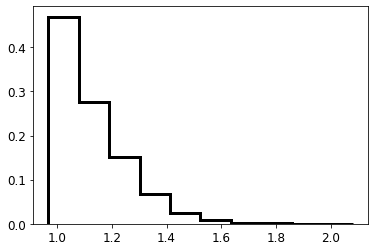

In [24]:
aux = np.divide( MET_SM[:,0], np.sqrt(ST_SM) ) / MET_sig_SM
weights = np.ones_like(aux)/len(aux)
plt.hist(aux, weights=weights, histtype = 'step', lw = 3, color = 'black')

for i in BPs2plot:
    weights = np.ones_like(photon_NP[i][:,j])/len(photon_NP[i][:,j])
    aux = np.divide( MET_NP[i][:,0], np.sqrt(ST_NP[i]) ) / MET_sig_NP[i]
    weights = np.ones_like(aux)/len(aux)
    plt.hist(aux, weights=weights, histtype = 'step', lw = 3, color = cmap(i))

plt.xlabel('$MET_{s, vieja} / MET_s$', fontsize = 14)
plt.ylabel('Fraction of events', fontsize = 14)
plt.savefig('../graph/METsVieja_METsNueva.pdf')

In [ ]:
aux = ST_SM / hadinfo_SM[:,0]
weights = np.ones_like(aux)/len(aux)
plt.hist(aux, weights=weights, histtype = 'step', lw = 3, color = 'black')

for i in BPs2plot:
    weights = np.ones_like(photon_NP[i][:,j])/len(photon_NP[i][:,j])
    aux = ST_NP[i] / hadinfo_NP[i][:,0]
    weights = np.ones_like(aux)/len(aux)
    plt.hist(aux, weights=weights, histtype = 'step', lw = 3, color = cmap(i))

plt.xlabel('$S_t / H_t$', fontsize = 14)
plt.ylabel('Fraction of events', fontsize = 14)
plt.savefig('../graph/st_ht.pdf')

In [ ]:
nbins = [np.concatenate((np.linspace(10,1000,15), [10000])), 15]

fig,ax = plt.subplots(2,2, gridspec_kw={'height_ratios': [1,0.4]}, figsize = (12,6))

# Photon info -----------------------------------------------------------------------------------------------------------------------
xlabels = [r"$p_{T}^{\gamma_{1}}$ [GeV]", r"$\eta^{\gamma_{1}}$", r"$\phi^{\gamma_{1}}$"]
xlims = [(0,1050), (-2.37,2.37), (-3,3)]
ylims = [(1e-5,1), (1e-4,1), (1e-4,1)]
bin_range = [[10,10000], [-2.37, 2.37], [-3, 3]]
for j in range(2):
    weights = np.ones_like(photon_SM[:,j])/len(photon_SM[:,j])
    h_sm = ax[0,j].hist(photon_SM[:,j], weights=weights, bins=nbins[j], range=bin_range[j], lw=2, edgecolor='black', histtype='step', zorder=20)
    ax[0,j].plot([],[], label='SM', color='black')

    for i in BPs2plot:
        weights = np.ones_like(photon_NP[i][:,j])/len(photon_NP[i][:,j])
        h_np = ax[0,j].hist(photon_NP[i][:,j], weights=weights, bins=nbins[j], range=bin_range[j], lw=2, edgecolor=cmap(i), histtype='step', zorder=2)
        ax[0,j].plot([],[], label=name[i], color=cmap(i))
        ax[1,j].step(h_sm[1][:-1], h_sm[0] / h_np[0], color=cmap(i))

    weights = np.ones_like(photon_Wgamma[:,j])/len(photon_Wgamma[:,j])
    ax[0,j].hist(photon_Wgamma[:,j], weights=weights, bins=nbins[j], range=bin_range[j], lw=2,linestyle='dotted', edgecolor=wgamma_color, histtype='step')
    ax[0,j].plot([],[], label=r"W $\gamma$", color='red', linestyle = ':')

    weights = np.ones_like(photon_Wjets[:,j])/len(photon_Wjets[:,j])
    ax[0,j].hist(photon_Wjets[:,j], weights=weights, bins=nbins[j], range=bin_range[j], lw=2,linestyle='--', edgecolor=wjets_color, histtype='step')
    ax[0,j].plot([],[], label="W jets", color='coral', linestyle = '--')

    weights = np.ones_like(photon_ttgamma[:,j])/len(photon_ttgamma[:,j])
    ax[0,j].hist(photon_ttgamma[:,j], weights=weights, bins=nbins[j], range=bin_range[j], lw=2,linestyle='-.', edgecolor=ttgamma_color, histtype='step')
    ax[0,j].plot([],[], label="tt $\gamma$", color='purple', linestyle = '-.')

    ax[0,j].grid()
    ax[1,j].grid()
    ax[1,j].set_xlabel(xlabels[j],fontsize=14)
    ax[1,j].set_ylabel("")
    #ax[0].set_xticks(fontsize=14)
    #ax[0].set_yticks(fontsize=14)
    ax[0,j].set_yscale('log')
    ax[0,j].set_xlim(xlims[j])
    ax[1,j].set_xlim(xlims[j])
    #ax[0,j].set_ylim(ylims[j])

    ax[1,j].axhline(y = 1, color = 'black')

    
#%weights = np.ones_like(mT_photon_SM)/len(mT_photon_SM)
#%h_sm = ax[0,3].hist(mT_photon_SM, weights=weights, bins=nbins, lw=2, edgecolor='black', histtype='step', zorder=20)
#%ax[0,3].plot([],[], label='SM', color='black')

#%for i in BPs2plot:
#%    weights = np.ones_like(mT_photon_NP[i])/len(mT_photon_NP[i])
#%    h_np = ax[0,3].hist(mT_photon_NP[i], weights=weights, bins=nbins, lw=2, edgecolor=cmap(i), histtype='step', zorder=2)
#%    ax[0,3].plot([],[], label=name[i], color=cmap(i))
#%    ax[1,3].step(h_sm[1][:-1], h_sm[0] / h_np[0], color=cmap(i))

#%weights = np.ones_like(mT_photon_Wgamma)/len(mT_photon_Wgamma)
#%ax[0,3].hist(mT_photon_Wgamma, weights=weights, bins=nbins, lw=2,linestyle='dotted', edgecolor=wgamma_color, histtype='step')
#%ax[0,3].plot([],[], label=r"W $\gamma$", color='red', linestyle = ':')

#%weights = np.ones_like(mT_photon_Wjets)/len(mT_photon_Wjets)
#%ax[0,3].hist(mT_photon_Wjets, weights=weights, bins=nbins, lw=2,linestyle='--', edgecolor=wjets_color, histtype='step')
#%ax[0,3].plot([],[], label="W jets", color='coral', linestyle = '--')

#%weights = np.ones_like(mT_photon_ttgamma)/len(mT_photon_ttgamma)
#%ax[0,3].hist(mT_photon_ttgamma, weights=weights, bins=nbins, lw=2,linestyle='-.', edgecolor=ttgamma_color, histtype='step')
#%ax[0,3].plot([],[], label="tt $\gamma$", color='purple', linestyle = '-.')

#%ax[0,3].grid()
#%ax[1,3].grid()
#%ax[1,3].set_xlabel(r"$m_{T}^{\gamma}$ [GeV]",fontsize=14)
#%ax[1,3].set_ylabel("")
#%ax[0,3].set_yscale('log')
#%ax[0,3].set_xlim(0,1000)
#%ax[1,3].set_xlim(0,1000)
#%ax[1,3].axhline(y = 1, color = 'black')

ax[1,0].set_ylabel("SM / NP", fontsize=14)
ax[0,0].set_ylabel("Fraction of Events",fontsize=14)
ax[0,1].legend(loc='upper right',fontsize=13,bbox_to_anchor=(0.70, 1.35), ncol = 5)
plt.savefig('../graph/photon_info_dist.pdf', bbox_inches='tight')

/tmp/ipykernel_518694/672526295.py:20: RuntimeWarning: divide by zero encountered in true_divide
  ax[1,j].step(h_sm[1][:-1], h_sm[0] / h_np[0], color=cmap(i))


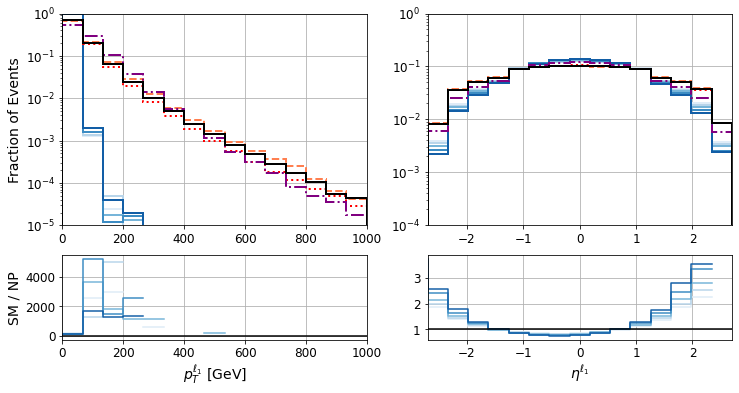

In [140]:
nbins = 15

fig,ax = plt.subplots(2,2, gridspec_kw={'height_ratios': [1,0.4]}, figsize = (12,6))

# Lepton info -----------------------------------------------------------------------------------------------------------------------
xlabels = [r"$p_{T}^{\ell_{1}}$ [GeV]", r"$\eta^{\ell_{1}}$", r"$\phi^{\ell_{1}}$"]
xlims = [(0,1000), (-2.7,2.7), (-3,3)]
ylims = [(1e-5,1), (1e-4,1), (1e-4,1)]
bin_range = [[10,1000], [-2.7, 2.7], [-3, 3]]

for j in range(2):
    weights = np.ones_like(lepton_SM[:,j])/len(lepton_SM[:,j])
    h_sm = ax[0,j].hist(lepton_SM[:,j], weights=weights, bins=nbins, range=bin_range[j], lw=2, edgecolor='black', histtype='step', zorder=20)
    ax[0,j].plot([],[], label='SM', color='black')

    for i in BPs2plot:
        weights = np.ones_like(lepton_NP[i][:,j])/len(lepton_NP[i][:,j])
        h_np = ax[0,j].hist(lepton_NP[i][:,j], weights=weights, bins=nbins, range=bin_range[j], lw=2, edgecolor=cmap(i), histtype='step', zorder=2)
        ax[0,j].plot([],[], label=name[i], color=cmap(i))
        ax[1,j].step(h_sm[1][:-1], h_sm[0] / h_np[0], color=cmap(i))

    weights = np.ones_like(lepton_Wgamma[:,j])/len(lepton_Wgamma[:,j])
    ax[0,j].hist(lepton_Wgamma[:,j], weights=weights, bins=nbins, range=bin_range[j], lw=2,linestyle='dotted', edgecolor=wgamma_color, histtype='step')
    ax[0,j].plot([],[], label=r"W $\gamma$", color='red', linestyle = ':')

    weights = np.ones_like(lepton_Wjets[:,j])/len(lepton_Wjets[:,j])
    ax[0,j].hist(lepton_Wjets[:,j], weights=weights, bins=nbins, range=bin_range[j], lw=2,linestyle='--', edgecolor=wjets_color, histtype='step')
    ax[0,j].plot([],[], label="W jets", color='coral', linestyle = '--')

    weights = np.ones_like(lepton_ttgamma[:,j])/len(lepton_ttgamma[:,j])
    ax[0,j].hist(lepton_ttgamma[:,j], weights=weights, bins=nbins, range=bin_range[j], lw=2,linestyle='-.', edgecolor=ttgamma_color, histtype='step')
    ax[0,j].plot([],[], label="tt $\gamma$", color='purple', linestyle = '-.')

    ax[0,j].grid()
    ax[1,j].grid()
    ax[1,j].set_xlabel(xlabels[j],fontsize=14)
    ax[1,j].set_ylabel("")
    #ax[0].set_xticks(fontsize=14)
    #ax[0].set_yticks(fontsize=14)
    ax[0,j].set_yscale('log')
    ax[0,j].set_xlim(xlims[j])
    ax[1,j].set_xlim(xlims[j])
    ax[0,j].set_ylim(ylims[j])

    ax[1,j].axhline(y = 1, color = 'black')

#%weights = np.ones_like(mT_lepton_SM)/len(mT_lepton_SM)
#%h_sm = ax[0,3].hist(mT_lepton_SM, weights=weights, bins=nbins, lw=2, edgecolor='black', histtype='step', zorder=20)
#%ax[0,3].plot([],[], label='SM', color='black')

#%for i in BPs2plot:
#%    weights = np.ones_like(mT_lepton_NP[i])/len(mT_lepton_NP[i])
#%    h_np = ax[0,3].hist(mT_lepton_NP[i], weights=weights, bins=nbins, lw=2, edgecolor=cmap(i), histtype='step', zorder=2)
#%    ax[0,3].plot([],[], label=name[i], color=cmap(i))
#%    ax[1,3].step(h_sm[1][:-1], h_sm[0] / h_np[0], color=cmap(i))

#%weights = np.ones_like(mT_lepton_Wgamma)/len(mT_lepton_Wgamma)
#%ax[0,3].hist(mT_lepton_Wgamma, weights=weights, bins=nbins, lw=2,linestyle='dotted', edgecolor=wgamma_color, histtype='step')
#%ax[0,3].plot([],[], label=r"W $\gamma$", color='red', linestyle = ':')

#%weights = np.ones_like(mT_lepton_Wjets)/len(mT_lepton_Wjets)
#%ax[0,3].hist(mT_lepton_Wjets, weights=weights, bins=nbins, lw=2,linestyle='--', edgecolor=wjets_color, histtype='step')
#%ax[0,3].plot([],[], label="W jets", color='coral', linestyle = '--')

#%weights = np.ones_like(mT_lepton_ttgamma)/len(mT_lepton_ttgamma)
#%ax[0,3].hist(mT_lepton_ttgamma, weights=weights, bins=nbins, lw=2,linestyle='-.', edgecolor=ttgamma_color, histtype='step')
#%ax[0,3].plot([],[], label="tt $\gamma$", color='purple', linestyle = '-.')

#%ax[0,3].grid()
#%ax[1,3].grid()
#%ax[1,3].set_xlabel(r"$m_{T}^{l}$ [GeV]",fontsize=14)
#%ax[1,3].set_ylabel("")
#ax[0].set_xticks(fontsize=14)
#ax[0].set_yticks(fontsize=14)
#%ax[0,3].set_yscale('log')
#%ax[0,3].set_xlim(0,1000)
#%ax[1,3].set_xlim(0,1000)
#%ax[1,3].axhline(y = 1, color = 'black')    
    
ax[1,0].set_ylabel("SM / NP", fontsize=14)
ax[0,0].set_ylabel("Fraction of Events",fontsize=14)
#ax[0,1].legend(loc='upper right',fontsize=9,bbox_to_anchor=(1.9, 1.25), ncol = 5)
plt.savefig('../graph/lepton_info_dist.pdf', bbox_inches='tight')

/tmp/ipykernel_518694/3327842876.py:20: RuntimeWarning: invalid value encountered in true_divide
  ax[1,j].step(h_sm[1][:-1], h_sm[0] / h_np[0], color=cmap(i))


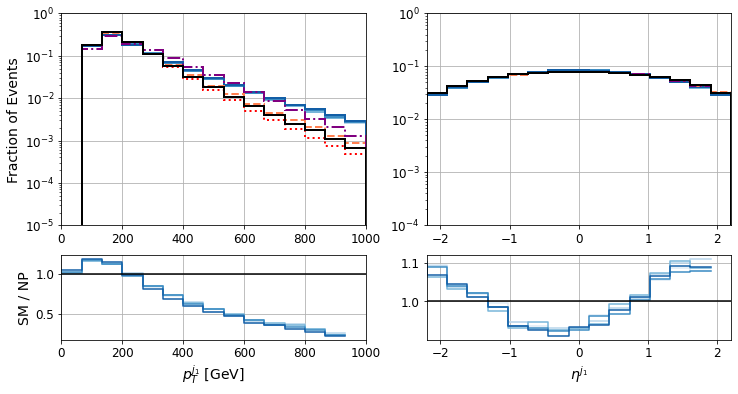

In [141]:
nbins = 15

fig,ax = plt.subplots(2,2, gridspec_kw={'height_ratios': [1,0.4]}, figsize = (12,6))

# Jet info -----------------------------------------------------------------------------------------------------------------------
xlabels = [r"$p_{T}^{j_{1}}$ [GeV]", r"$\eta^{j_{1}}$", r"$\phi^{j_{1}}$"]
xlims = [(0,1000), (-2.2,2.2), (-3,3)]
ylims = [(1e-5,1), (1e-4,1), (1e-4,1)]
bin_range = [[20,1000], [-2.2, 2.2], [-3, 3]]

for j in range(2):
    weights = np.ones_like(jet_SM[:,j])/len(jet_SM[:,j])
    h_sm = ax[0,j].hist(jet_SM[:,j], weights=weights, bins=nbins, range=bin_range[j], lw=2, edgecolor='black', histtype='step', zorder=20)
    ax[0,j].plot([],[], label='SM', color='black')

    for i in BPs2plot:
        weights = np.ones_like(jet_NP[i][:,j])/len(jet_NP[i][:,j])
        h_np = ax[0,j].hist(jet_NP[i][:,j], weights=weights, bins=nbins, range=bin_range[j], lw=2, edgecolor=cmap(i), histtype='step', zorder=2)
        ax[0,j].plot([],[], label=name[i], color=cmap(i))
        ax[1,j].step(h_sm[1][:-1], h_sm[0] / h_np[0], color=cmap(i))

    weights = np.ones_like(jet_Wgamma[:,j])/len(jet_Wgamma[:,j])
    ax[0,j].hist(jet_Wgamma[:,j], weights=weights, bins=nbins, range=bin_range[j], lw=2,linestyle='dotted', edgecolor=wgamma_color, histtype='step')
    ax[0,j].plot([],[], label=r"W $\gamma$", color='red', linestyle = ':')

    weights = np.ones_like(jet_Wjets[:,j])/len(jet_Wjets[:,j])
    ax[0,j].hist(jet_Wjets[:,j], weights=weights, bins=nbins, range=bin_range[j], lw=2,linestyle='--', edgecolor=wjets_color, histtype='step')
    ax[0,j].plot([],[], label="W jets", color='coral', linestyle = '--')

    weights = np.ones_like(jet_ttgamma[:,j])/len(jet_ttgamma[:,j])
    ax[0,j].hist(jet_ttgamma[:,j], weights=weights, bins=nbins, range=bin_range[j], lw=2,linestyle='-.', edgecolor=ttgamma_color, histtype='step')
    ax[0,j].plot([],[], label="tt $\gamma$", color='purple', linestyle = '-.')

    ax[0,j].grid()
    ax[1,j].grid()
    ax[1,j].set_xlabel(xlabels[j],fontsize=14)
    ax[1,j].set_ylabel("")
    #ax[0].set_xticks(fontsize=14)
    #ax[0].set_yticks(fontsize=14)
    ax[0,j].set_yscale('log')
    ax[0,j].set_xlim(xlims[j])
    ax[1,j].set_xlim(xlims[j])
    ax[0,j].set_ylim(ylims[j])

    ax[1,j].axhline(y = 1, color = 'black')

#%weights = np.ones_like(mT_jet_SM)/len(mT_jet_SM)
#%h_sm = ax[0,3].hist(mT_jet_SM, weights=weights, bins=nbins, lw=2, edgecolor='black', histtype='step', zorder=20)
#%ax[0,3].plot([],[], label='SM', color='black')

#%for i in BPs2plot:
#%    weights = np.ones_like(mT_jet_NP[i])/len(mT_jet_NP[i])
#%    h_np = ax[0,3].hist(mT_jet_NP[i], weights=weights, bins=nbins, lw=2, edgecolor=cmap(i), histtype='step', zorder=2)
#%    ax[0,3].plot([],[], label=name[i], color=cmap(i))
#%    ax[1,3].step(h_sm[1][:-1], h_sm[0] / h_np[0], color=cmap(i))

#%weights = np.ones_like(mT_jet_Wgamma)/len(mT_jet_Wgamma)
#%ax[0,3].hist(mT_jet_Wgamma, weights=weights, bins=nbins, lw=2,linestyle='dotted', edgecolor=wgamma_color, histtype='step')
#%ax[0,3].plot([],[], label=r"W $\gamma$", color='red', linestyle = ':')

#%weights = np.ones_like(mT_jet_Wjets)/len(mT_jet_Wjets)
#%ax[0,3].hist(mT_jet_Wjets, weights=weights, bins=nbins, lw=2,linestyle='--', edgecolor=wjets_color, histtype='step')
#%ax[0,3].plot([],[], label="W jets", color='coral', linestyle = '--')

#%weights = np.ones_like(mT_jet_ttgamma)/len(mT_jet_ttgamma)
#%ax[0,3].hist(mT_jet_ttgamma, weights=weights, bins=nbins, lw=2,linestyle='-.', edgecolor=ttgamma_color, histtype='step')
#%ax[0,3].plot([],[], label="tt $\gamma$", color='purple', linestyle = '-.')

#%ax[0,3].grid()
#%ax[1,3].grid()
#%ax[1,3].set_xlabel(r"$m_{T}^{jet}$ [GeV]",fontsize=14)
#%ax[1,3].set_ylabel("")
#%ax[0,3].set_yscale('log')
#%ax[0,3].set_xlim(0,1000)
#%ax[1,3].set_xlim(0,1000)
#%ax[1,3].axhline(y = 1, color = 'black')        
    
ax[1,0].set_ylabel("SM / NP", fontsize=14)
ax[0,0].set_ylabel("Fraction of Events",fontsize=14)
#ax[0,1].legend(loc='upper right',fontsize=9,bbox_to_anchor=(1.9, 1.25), ncol = 5)
plt.savefig('../graph/jet_info_dist.pdf', bbox_inches='tight')

/tmp/ipykernel_518694/679237493.py:16: RuntimeWarning: divide by zero encountered in true_divide
  ax[1,0].step(h_sm[1][:-1], h_sm[0] / h_np[0], color=cmap(i))
/tmp/ipykernel_518694/679237493.py:47: RuntimeWarning: invalid value encountered in true_divide
  ax[1,1].step(h_sm[1][:-1], h_sm[0] / h_np[0], color=cmap(i))
/tmp/ipykernel_518694/679237493.py:47: RuntimeWarning: divide by zero encountered in true_divide
  ax[1,1].step(h_sm[1][:-1], h_sm[0] / h_np[0], color=cmap(i))


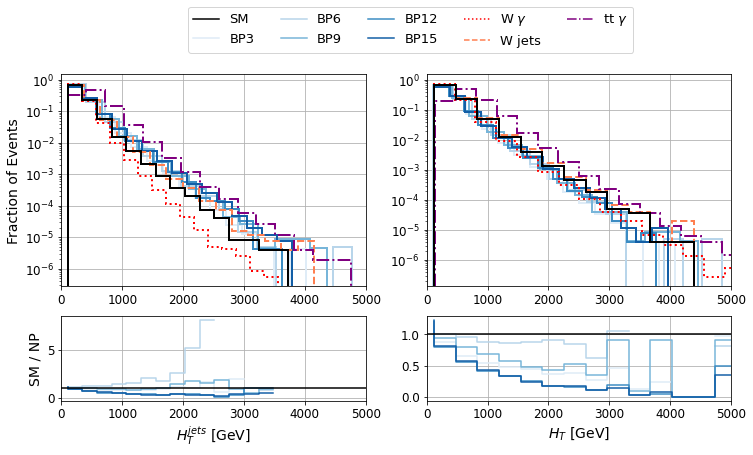

In [142]:
nbins = 15

fig,ax = plt.subplots(2,2, gridspec_kw={'height_ratios': [1,0.4]}, figsize = (12,6))

# Ht info -----------------------------------------------------------------------------------------------------------------------
xlabels = [r"$H_{T}^{jets}$ [GeV]", r"$H_{T}^{jets}$ [GeV]"]

weights = np.ones_like(hadinfo_SM[:,1])/len(hadinfo_SM[:,1])
h_sm = ax[0,0].hist(hadinfo_SM[:,1], weights=weights, bins=nbins, lw=2, edgecolor='black', histtype='step', zorder=20)
ax[0,0].plot([],[], label='SM', color='black')

for i in BPs2plot:
    weights = np.ones_like(hadinfo_NP[i][:,1])/len(hadinfo_NP[i][:,1])
    h_np = ax[0,0].hist(hadinfo_NP[i][:,1], weights=weights, bins=nbins, lw=2, edgecolor=cmap(i), histtype='step', zorder=2)
    ax[0,0].plot([],[], label=name[i], color=cmap(i))
    ax[1,0].step(h_sm[1][:-1], h_sm[0] / h_np[0], color=cmap(i))

weights = np.ones_like(hadinfo_Wgamma[:,1])/len(hadinfo_Wgamma[:,1])
ax[0,0].hist(hadinfo_Wgamma[:,1], weights=weights, bins=nbins, lw=2,linestyle='dotted', edgecolor=wgamma_color, histtype='step')
ax[0,0].plot([],[], label=r"W $\gamma$", color='red', linestyle = ':')

weights = np.ones_like(hadinfo_Wjets[:,1])/len(hadinfo_Wjets[:,1])
ax[0,0].hist(hadinfo_Wjets[:,1], weights=weights, bins=nbins, lw=2,linestyle='--', edgecolor=wjets_color, histtype='step')
ax[0,0].plot([],[], label="W jets", color='coral', linestyle = '--')

weights = np.ones_like(hadinfo_ttgamma[:,1])/len(hadinfo_ttgamma[:,1])
ax[0,0].hist(hadinfo_ttgamma[:,1], weights=weights, bins=nbins, lw=2,linestyle='-.', edgecolor=ttgamma_color, histtype='step')
ax[0,0].plot([],[], label="tt $\gamma$", color='purple', linestyle = '-.')

ax[0,0].grid()
ax[1,0].grid()
ax[1,0].set_xlabel(r"$H_{T}^{jets}$ [GeV]",fontsize=14)
ax[1,0].set_ylabel("")
ax[0,0].set_yscale('log')
ax[0,0].set_xlim(0,5000)
ax[1,0].set_xlim(0,5000)
ax[1,0].axhline(y = 1, color = 'black') 

weights = np.ones_like(hadinfo_SM[:,0])/len(hadinfo_SM[:,0])
h_sm = ax[0,1].hist(hadinfo_SM[:,0], weights=weights, bins=nbins, lw=2, edgecolor='black', histtype='step', zorder=20)
ax[0,1].plot([],[], label='SM', color='black')

for i in BPs2plot:
    weights = np.ones_like(hadinfo_NP[i][:,0])/len(hadinfo_NP[i][:,0])
    h_np = ax[0,1].hist(hadinfo_NP[i][:,0], weights=weights, bins=nbins, lw=2, edgecolor=cmap(i), histtype='step', zorder=2)
    ax[0,1].plot([],[], label=name[i], color=cmap(i))
    ax[1,1].step(h_sm[1][:-1], h_sm[0] / h_np[0], color=cmap(i))

weights = np.ones_like(hadinfo_Wgamma[:,0])/len(hadinfo_Wgamma[:,0])
ax[0,1].hist(hadinfo_Wgamma[:,0], weights=weights, bins=nbins, lw=2,linestyle='dotted', edgecolor=wgamma_color, histtype='step')
ax[0,1].plot([],[], label=r"W $\gamma$", color='red', linestyle = ':')

weights = np.ones_like(hadinfo_Wjets[:,0])/len(hadinfo_Wjets[:,0])
ax[0,1].hist(hadinfo_Wjets[:,0], weights=weights, bins=nbins, lw=2,linestyle='--', edgecolor=wjets_color, histtype='step')
ax[0,1].plot([],[], label="W jets", color='coral', linestyle = '--')

weights = np.ones_like(hadinfo_ttgamma[:,0])/len(hadinfo_ttgamma[:,0])
ax[0,1].hist(hadinfo_ttgamma[:,0], weights=weights, bins=nbins, lw=2,linestyle='-.', edgecolor=ttgamma_color, histtype='step')
ax[0,1].plot([],[], label="tt $\gamma$", color='purple', linestyle = '-.')

ax[0,1].grid()
ax[1,1].grid()
ax[1,1].set_xlabel(r"$H_{T}$ [GeV]",fontsize=14)
ax[1,1].set_ylabel("")
ax[0,1].set_yscale('log')
ax[0,1].set_xlim(0,5000)
ax[1,1].set_xlim(0,5000)
ax[1,1].axhline(y = 1, color = 'black')     
    
ax[0,0].set_ylabel("Fraction of Events",fontsize=14)
ax[1,0].set_ylabel("SM / NP", fontsize=14)
ax[0,1].legend(loc='upper right',fontsize=13,bbox_to_anchor=(0.70, 1.35), ncol = 5)

plt.savefig('../graph/HT_info_dist.pdf', bbox_inches='tight')

/tmp/ipykernel_518694/1945815204.py:13: RuntimeWarning: divide by zero encountered in true_divide
  ax[1,0].step(h_sm[1][:-1], h_sm[0] / h_np[0], color=cmap(i))
/tmp/ipykernel_518694/1945815204.py:44: RuntimeWarning: divide by zero encountered in true_divide
  ax[1,1].step(h_sm[1][:-1], h_sm[0] / h_np[0], color=cmap(i))
/tmp/ipykernel_518694/1945815204.py:44: RuntimeWarning: invalid value encountered in true_divide
  ax[1,1].step(h_sm[1][:-1], h_sm[0] / h_np[0], color=cmap(i))


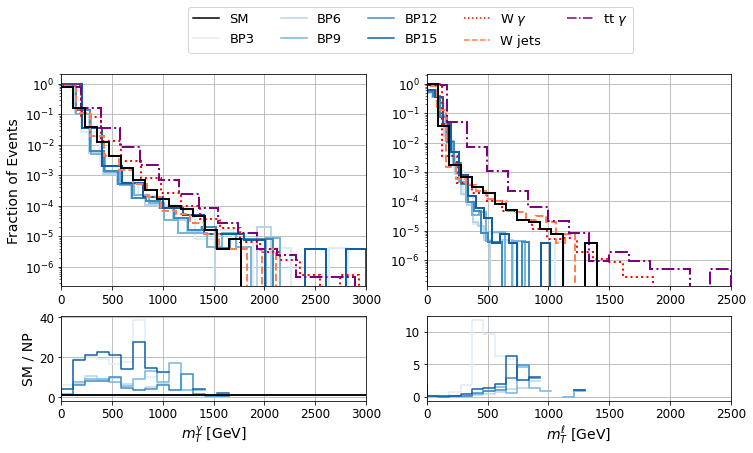

In [209]:
nbins = 15

fig,ax = plt.subplots(2,2, gridspec_kw={'height_ratios': [1,0.4]}, figsize = (12,6))   

weights = np.ones_like(mT_photon_SM)/len(mT_photon_SM)
h_sm = ax[0,0].hist(mT_photon_SM, weights=weights, bins=nbins, lw=2, edgecolor='black', histtype='step', zorder=20)
ax[0,0].plot([],[], label='SM', color='black')

for i in BPs2plot:
    weights = np.ones_like(mT_photon_NP[i])/len(mT_photon_NP[i])
    h_np = ax[0,0].hist(mT_photon_NP[i], weights=weights, bins=nbins, lw=2, edgecolor=cmap(i), histtype='step', zorder=2)
    ax[0,0].plot([],[], label=name[i], color=cmap(i))
    ax[1,0].step(h_sm[1][:-1], h_sm[0] / h_np[0], color=cmap(i))

weights = np.ones_like(mT_photon_Wgamma)/len(mT_photon_Wgamma)
ax[0,0].hist(mT_photon_Wgamma, weights=weights, bins=nbins, lw=2,linestyle='dotted', edgecolor=wgamma_color, histtype='step')
ax[0,0].plot([],[], label=r"W $\gamma$", color='red', linestyle = ':')

weights = np.ones_like(mT_photon_Wjets)/len(mT_photon_Wjets)
ax[0,0].hist(mT_photon_Wjets, weights=weights, bins=nbins, lw=2,linestyle='--', edgecolor=wjets_color, histtype='step')
ax[0,0].plot([],[], label="W jets", color='coral', linestyle = '--')

weights = np.ones_like(mT_photon_ttgamma)/len(mT_photon_ttgamma)
ax[0,0].hist(mT_photon_ttgamma, weights=weights, bins=nbins, lw=2,linestyle='-.', edgecolor=ttgamma_color, histtype='step')
ax[0,0].plot([],[], label="tt $\gamma$", color='purple', linestyle = '-.')

ax[0,0].grid()
ax[1,0].grid()
ax[1,0].set_xlabel(r"$m_{T}^{\gamma}$ [GeV]",fontsize=14)
ax[1,0].set_ylabel("")
ax[0,0].set_yscale('log')
ax[0,0].set_xlim(0,3000)
ax[1,0].set_xlim(0,3000)
ax[1,0].axhline(y = 1, color = 'black')

weights = np.ones_like(mT_lepton_SM)/len(mT_lepton_SM)
h_sm = ax[0,1].hist(mT_lepton_SM, weights=weights, bins=nbins, lw=2, edgecolor='black', histtype='step', zorder=20)
ax[0,1].plot([],[], label='SM', color='black')

for i in BPs2plot:
    weights = np.ones_like(mT_lepton_NP[i])/len(mT_lepton_NP[i])
    h_np = ax[0,1].hist(mT_lepton_NP[i], weights=weights, bins=nbins, lw=2, edgecolor=cmap(i), histtype='step', zorder=2)
    ax[0,1].plot([],[], label=name[i], color=cmap(i))
    ax[1,1].step(h_sm[1][:-1], h_sm[0] / h_np[0], color=cmap(i))

weights = np.ones_like(mT_lepton_Wgamma)/len(mT_lepton_Wgamma)
ax[0,1].hist(mT_lepton_Wgamma, weights=weights, bins=nbins, lw=2,linestyle='dotted', edgecolor=wgamma_color, histtype='step')
ax[0,1].plot([],[], label=r"W $\gamma$", color='red', linestyle = ':')

weights = np.ones_like(mT_lepton_Wjets)/len(mT_lepton_Wjets)
ax[0,1].hist(mT_lepton_Wjets, weights=weights, bins=nbins, lw=2,linestyle='--', edgecolor=wjets_color, histtype='step')
ax[0,1].plot([],[], label="W jets", color='coral', linestyle = '--')

weights = np.ones_like(mT_lepton_ttgamma)/len(mT_lepton_ttgamma)
ax[0,1].hist(mT_lepton_ttgamma, weights=weights, bins=nbins, lw=2,linestyle='-.', edgecolor=ttgamma_color, histtype='step')
ax[0,1].plot([],[], label="tt $\gamma$", color='purple', linestyle = '-.')

ax[0,1].grid()
ax[1,1].grid()
ax[1,1].set_xlabel(r"$m_{T}^{\ell}$ [GeV]",fontsize=14)
ax[1,1].set_ylabel("")
ax[0,1].set_yscale('log')
ax[0,1].set_xlim(0,2500)
ax[1,1].set_xlim(0,2500)
ax[1,0].axhline(y = 1, color = 'black')

ax[0,0].set_ylabel("Fraction of Events",fontsize=14)
ax[1,0].set_ylabel("SM / NP", fontsize=14)
ax[0,1].legend(loc='upper right',fontsize=13,bbox_to_anchor=(0.70, 1.35), ncol = 5)

plt.savefig('../graph/mt_photon_lepton_info_dist.pdf', bbox_inches='tight')

/tmp/ipykernel_518694/1094914450.py:13: RuntimeWarning: divide by zero encountered in true_divide
  ax[1,0].step(h_sm[1][:-1], h_sm[0] / h_np[0], color=cmap(i))


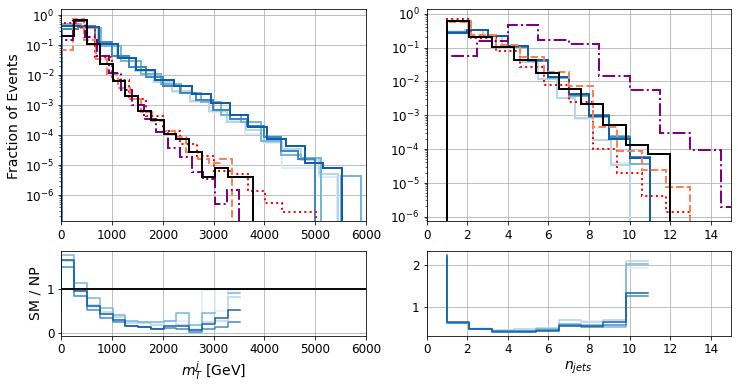

In [201]:
nbins = 15

fig,ax = plt.subplots(2,2, gridspec_kw={'height_ratios': [1,0.4]}, figsize = (12,6))   

weights = np.ones_like(mT_jet_SM)/len(mT_jet_SM)
h_sm = ax[0,0].hist(mT_jet_SM, weights=weights, bins=nbins, lw=2, edgecolor='black', histtype='step', zorder=20)
ax[0,0].plot([],[], label='SM', color='black')

for i in BPs2plot:
    weights = np.ones_like(mT_jet_NP[i])/len(mT_jet_NP[i])
    h_np = ax[0,0].hist(mT_jet_NP[i], weights=weights, bins=nbins, lw=2, edgecolor=cmap(i), histtype='step', zorder=2)
    ax[0,0].plot([],[], label=name[i], color=cmap(i))
    ax[1,0].step(h_sm[1][:-1], h_sm[0] / h_np[0], color=cmap(i))

weights = np.ones_like(mT_jet_Wgamma)/len(mT_jet_Wgamma)
ax[0,0].hist(mT_jet_Wgamma, weights=weights, bins=nbins, lw=2,linestyle='dotted', edgecolor=wgamma_color, histtype='step')
ax[0,0].plot([],[], label=r"W $\gamma$", color='red', linestyle = ':')

weights = np.ones_like(mT_jet_Wjets)/len(mT_jet_Wjets)
ax[0,0].hist(mT_jet_Wjets, weights=weights, bins=nbins, lw=2,linestyle='--', edgecolor=wjets_color, histtype='step')
ax[0,0].plot([],[], label="W jets", color='coral', linestyle = '--')

weights = np.ones_like(mT_jet_ttgamma)/len(mT_jet_ttgamma)
ax[0,0].hist(mT_jet_ttgamma, weights=weights, bins=nbins, lw=2,linestyle='-.', edgecolor=ttgamma_color, histtype='step')
ax[0,0].plot([],[], label="tt $\gamma$", color='purple', linestyle = '-.')

ax[0,0].grid()
ax[1,0].grid()
ax[1,0].set_xlabel(r"$m_{T}^{j}$ [GeV]",fontsize=14)
ax[1,0].set_ylabel("")
ax[0,0].set_yscale('log')
ax[0,0].set_xlim(0,6000)
ax[1,0].set_xlim(0,6000)
ax[1,0].axhline(y = 1, color = 'black')

# Num jets
nbins = 15
weights = np.ones_like(hadinfo_SM[:,2])/len(hadinfo_SM[:,2])
h_sm = ax[0,1].hist(hadinfo_SM[:,2], weights=weights, lw=2, edgecolor='black', histtype='step', zorder=20)
ax[0,1].plot([],[], label='SM', color='black')

for i in BPs2plot:
    weights = np.ones_like(hadinfo_NP[i][:,2])/len(hadinfo_NP[i][:,2])
    h_np = ax[0,1].hist(hadinfo_NP[i][:,2], weights=weights, lw=2, edgecolor=cmap(i), histtype='step', zorder=2)
    ax[0,1].plot([],[], label=name[i], color=cmap(i))
    ax[1,1].step(h_sm[1][:-1], h_sm[0] / h_np[0], color=cmap(i))

weights = np.ones_like(hadinfo_Wgamma[:,2])/len(hadinfo_Wgamma[:,2])
ax[0,1].hist(hadinfo_Wgamma[:,2], weights=weights, lw=2,linestyle='dotted', edgecolor=wgamma_color, histtype='step')
ax[0,1].plot([],[], label=r"W $\gamma$", color='red', linestyle = ':')

weights = np.ones_like(hadinfo_Wjets[:,2])/len(hadinfo_Wjets[:,2])
ax[0,1].hist(hadinfo_Wjets[:,2], weights=weights, lw=2,linestyle='--', edgecolor=wjets_color, histtype='step')
ax[0,1].plot([],[], label="W jets", color='coral', linestyle = '--')

weights = np.ones_like(hadinfo_ttgamma[:,2])/len(hadinfo_ttgamma[:,2])
ax[0,1].hist(hadinfo_ttgamma[:,2], weights=weights, lw=2,linestyle='-.', edgecolor=ttgamma_color, histtype='step')
ax[0,1].plot([],[], label="tt $\gamma$", color='purple', linestyle = '-.')

ax[0,1].grid()
ax[1,1].grid()
ax[1,1].set_xlabel(r"$n_{jets}$ ",fontsize=14)
ax[1,1].set_ylabel("")
ax[0,1].set_yscale('log')
ax[0,1].set_xlim(0,15)
ax[1,1].set_xlim(0,15)
ax[1,0].axhline(y = 1, color = 'black')

ax[0,0].set_ylabel("Fraction of Events",fontsize=14)
ax[1,0].set_ylabel("SM / NP", fontsize=14)
plt.savefig('../graph/mt_jet_njets_info_dist.pdf', bbox_inches='tight')

/tmp/ipykernel_518694/831172003.py:16: RuntimeWarning: invalid value encountered in true_divide
  ax[1,0].step(h_sm[1][:-1], h_sm[0] / h_np[0], color=cmap(i))
/tmp/ipykernel_518694/831172003.py:49: RuntimeWarning: invalid value encountered in true_divide
  ax[1,1].step(h_sm[1][:-1], h_sm[0] / h_np[0], color=cmap(i))


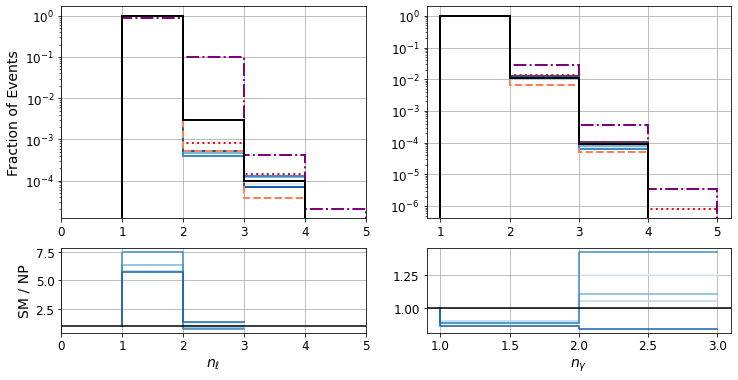

In [208]:
nbins = 15

fig,ax = plt.subplots(2,2, gridspec_kw={'height_ratios': [1,0.4]}, figsize = (12,6))   

# Num leptons
bins = [1,2,3,4,5]

weights = np.ones_like(lepton_SM[:,3])/len(lepton_SM[:,3])
h_sm = ax[0,0].hist(lepton_SM[:,3], weights=weights, lw=2, edgecolor='black', histtype='step', zorder=20, bins = bins)
ax[0,0].plot([],[], label='SM', color='black')

for i in BPs2plot:
    weights = np.ones_like(lepton_NP[i][:,3])/len(lepton_NP[i][:,3])
    h_np = ax[0,0].hist(lepton_NP[i][:,3], weights=weights, lw=2, edgecolor=cmap(i), histtype='step', zorder=2, bins = bins)
    ax[0,0].plot([],[], label=name[i], color=cmap(i))
    ax[1,0].step(h_sm[1][:-1], h_sm[0] / h_np[0], color=cmap(i))

weights = np.ones_like(lepton_Wgamma[:,3])/len(lepton_Wgamma[:,3])
ax[0,0].hist(lepton_Wgamma[:,3], weights=weights, lw=2,linestyle='dotted', edgecolor=wgamma_color, histtype='step', bins = bins)
ax[0,0].plot([],[], label=r"W $\gamma$", color='red', linestyle = ':')

weights = np.ones_like(lepton_Wjets[:,3])/len(lepton_Wjets[:,3])
ax[0,0].hist(lepton_Wjets[:,3], weights=weights, lw=2,linestyle='--', edgecolor=wjets_color, histtype='step', bins = bins)
ax[0,0].plot([],[], label="W jets", color='coral', linestyle = '--')

weights = np.ones_like(lepton_ttgamma[:,3])/len(lepton_ttgamma[:,3])
ax[0,0].hist(lepton_ttgamma[:,3], weights=weights, lw=2,linestyle='-.', edgecolor=ttgamma_color, histtype='step', bins = bins)
ax[0,0].plot([],[], label="tt $\gamma$", color='purple', linestyle = '-.')

ax[0,0].grid()
ax[1,0].grid()
ax[1,0].set_xlabel(r"$n_{\ell}$",fontsize=14)
ax[1,0].set_ylabel("")
ax[0,0].set_yscale('log')
ax[0,0].set_xlim(0,5)
ax[1,0].set_xlim(0,5)
ax[1,0].axhline(y = 1, color = 'black')

# Num photons
bins = [1,2,3,4,5]
weights = np.ones_like(photon_SM[:,3])/len(photon_SM[:,3])
h_sm = ax[0,1].hist(photon_SM[:,3], weights=weights, lw=2, edgecolor='black', histtype='step', zorder=20, bins = bins)
ax[0,1].plot([],[], label='SM', color='black')

for i in BPs2plot:
    weights = np.ones_like(photon_NP[i][:,3])/len(photon_NP[i][:,3])
    h_np = ax[0,1].hist(photon_NP[i][:,3], weights=weights, lw=2, edgecolor=cmap(i), histtype='step', zorder=2, bins = bins)
    ax[0,1].plot([],[], label=name[i], color=cmap(i))
    ax[1,1].step(h_sm[1][:-1], h_sm[0] / h_np[0], color=cmap(i))

weights = np.ones_like(photon_Wgamma[:,3])/len(photon_Wgamma[:,3])
ax[0,1].hist(photon_Wgamma[:,3], weights=weights, lw=2,linestyle='dotted', edgecolor=wgamma_color, histtype='step', bins = bins)
ax[0,1].plot([],[], label=r"W $\gamma$", color='red', linestyle = ':')

weights = np.ones_like(photon_Wjets[:,3])/len(photon_Wjets[:,3])
ax[0,1].hist(photon_Wjets[:,3], weights=weights, lw=2,linestyle='--', edgecolor=wjets_color, histtype='step', bins = bins)
ax[0,1].plot([],[], label="W jets", color='coral', linestyle = '--')

weights = np.ones_like(photon_ttgamma[:,3])/len(photon_ttgamma[:,3])
ax[0,1].hist(photon_ttgamma[:,3], weights=weights, lw=2,linestyle='-.', edgecolor=ttgamma_color, histtype='step', bins = bins)
ax[0,1].plot([],[], label="tt $\gamma$", color='purple', linestyle = '-.')

ax[0,1].grid()
ax[1,1].grid()
ax[1,1].set_xlabel(r"$n_{\gamma}$",fontsize=14)
ax[1,1].set_ylabel("")
ax[0,1].set_yscale('log')
ax[0,0].set_xlim(0,5)
ax[1,0].set_xlim(0,5)
ax[1,1].axhline(y = 1, color = 'black')

ax[0,0].set_ylabel("Fraction of Events",fontsize=14)
ax[1,0].set_ylabel("SM / NP", fontsize=14)
plt.savefig('../graph/nlep_nphoton_info_dist.pdf', bbox_inches='tight')

/tmp/ipykernel_518694/638331897.py:15: RuntimeWarning: divide by zero encountered in true_divide
  ax[1,0].step(h_sm[1][:-1], h_sm[0] / h_np[0], color=cmap(i))
/tmp/ipykernel_518694/638331897.py:48: RuntimeWarning: invalid value encountered in true_divide
  ax[1,1].step(h_sm[1][:-1], h_sm[0] / h_np[0], color=cmap(i))


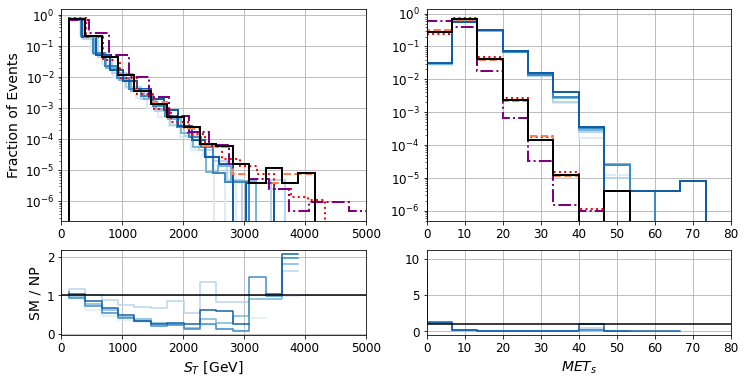

In [196]:
nbins = 15

fig,ax = plt.subplots(2,2, gridspec_kw={'height_ratios': [1,0.4]}, figsize = (12,6))

# ST info

weights = np.ones_like(ST_SM)/len(ST_SM)
h_sm = ax[0,0].hist(ST_SM, weights=weights, bins=nbins, lw=2, edgecolor='black', histtype='step', zorder=20)
ax[0,0].plot([],[], label='SM', color='black')

for i in BPs2plot:
    weights = np.ones_like(ST_NP[i])/len(ST_NP[i])
    h_np = ax[0,0].hist(ST_NP[i], weights=weights, bins=nbins, lw=2, edgecolor=cmap(i), histtype='step', zorder=2)
    ax[0,0].plot([],[], label=name[i], color=cmap(i))
    ax[1,0].step(h_sm[1][:-1], h_sm[0] / h_np[0], color=cmap(i))

weights = np.ones_like(ST_Wgamma)/len(ST_Wgamma)
ax[0,0].hist(ST_Wgamma, weights=weights, bins=nbins, lw=2,linestyle='dotted', edgecolor=wgamma_color, histtype='step')
ax[0,0].plot([],[], label=r"W $\gamma$", color='red', linestyle = ':')

weights = np.ones_like(ST_Wjets)/len(ST_Wjets)
ax[0,0].hist(ST_Wjets, weights=weights, bins=nbins, lw=2,linestyle='--', edgecolor=wjets_color, histtype='step')
ax[0,0].plot([],[], label="W jets", color='coral', linestyle = '--')

weights = np.ones_like(ST_ttgamma)/len(ST_ttgamma)
ax[0,0].hist(ST_ttgamma, weights=weights, bins=nbins, lw=2,linestyle='-.', edgecolor=ttgamma_color, histtype='step')
ax[0,0].plot([],[], label="tt $\gamma$", color='purple', linestyle = '-.')

ax[0,0].grid()
ax[1,0].grid()
ax[1,0].set_xlabel(r"$S_{T}$ [GeV]",fontsize=14)
ax[1,0].set_ylabel("")
ax[0,0].set_yscale('log')
ax[0,0].set_xlim(0,5000)
ax[1,0].set_xlim(0,5000)
ax[1,0].axhline(y = 1, color = 'black')

# Met info -----------------------------------------------------------------------------------------------------------------------

weights = np.ones_like(MET_sig_SM)/len(MET_sig_SM)
h_sm = ax[0,1].hist(MET_sig_SM, weights=weights, bins=nbins, range=[0,100], lw=2, edgecolor='black', histtype='step', zorder=20)
ax[0,1].plot([],[], label='SM', color='black')

for i in BPs2plot:
    weights = np.ones_like(MET_sig_NP[i])/len(MET_sig_NP[i])
    h_np = ax[0,1].hist(MET_sig_NP[i], weights=weights, bins=nbins, range=[0,100], lw=2, edgecolor=cmap(i), histtype='step', zorder=2)
    ax[0,1].plot([],[], label=name[i], color=cmap(i))
    ax[1,1].step(h_sm[1][:-1], h_sm[0] / h_np[0], color=cmap(i))

weights = np.ones_like(MET_sig_Wgamma)/len(MET_sig_Wgamma)
ax[0,1].hist(MET_sig_Wgamma, weights=weights, bins=nbins, range=[0,100], lw=2,linestyle='dotted', edgecolor=wgamma_color, histtype='step')
ax[0,1].plot([],[], label=r"W $\gamma$", color='red', linestyle = ':')

weights = np.ones_like(MET_sig_Wjets)/len(MET_sig_Wjets)
ax[0,1].hist(MET_sig_Wjets, weights=weights, bins=nbins, range=[0,100], lw=2,linestyle='--', edgecolor=wjets_color, histtype='step')
ax[0,1].plot([],[], label="W jets", color='coral', linestyle = '--')

weights = np.ones_like(MET_sig_ttgamma)/len(MET_sig_ttgamma)
ax[0,1].hist(MET_sig_ttgamma, weights=weights, bins=nbins, range=[0,100], lw=2,linestyle='-.', edgecolor=ttgamma_color, histtype='step')
ax[0,1].plot([],[], label="tt $\gamma$", color='purple', linestyle = '-.')

ax[0,1].grid()
ax[1,1].grid()
ax[1,1].set_xlabel('$MET_{s}$',fontsize=14)
ax[1,1].set_ylabel("")
ax[0,1].set_yscale('log')
ax[0,1].set_xlim(0,80)
ax[1,1].set_xlim(0,80)
ax[1,1].axhline(y = 1, color = 'black')
    
    
ax[0,0].set_ylabel("Fraction of Events",fontsize=14)
ax[1,0].set_ylabel("SM / NP", fontsize=14)
#ax[0,1].legend(loc='upper right',fontsize=9,bbox_to_anchor=(1.9, 1.25), ncol = 5)
plt.savefig('../graph/ST_METs_info_dist.pdf', bbox_inches='tight')

## old plots

/tmp/ipykernel_357983/2702610001.py:20: RuntimeWarning: invalid value encountered in true_divide
  ax[1,ij].step(h_sm[1][:-1], h_sm[0] / h_np[0], color=cmap(i))
/tmp/ipykernel_357983/2702610001.py:55: RuntimeWarning: divide by zero encountered in true_divide
  ax[1,2].step(h_sm[1][:-1], h_sm[0] / h_np[0], color=cmap(i))
/tmp/ipykernel_357983/2702610001.py:55: RuntimeWarning: invalid value encountered in true_divide
  ax[1,2].step(h_sm[1][:-1], h_sm[0] / h_np[0], color=cmap(i))
/tmp/ipykernel_357983/2702610001.py:86: RuntimeWarning: invalid value encountered in true_divide
  ax[1,3].step(h_sm[1][:-1], h_sm[0] / h_np[0], color=cmap(i))
/tmp/ipykernel_357983/2702610001.py:86: RuntimeWarning: divide by zero encountered in true_divide
  ax[1,3].step(h_sm[1][:-1], h_sm[0] / h_np[0], color=cmap(i))


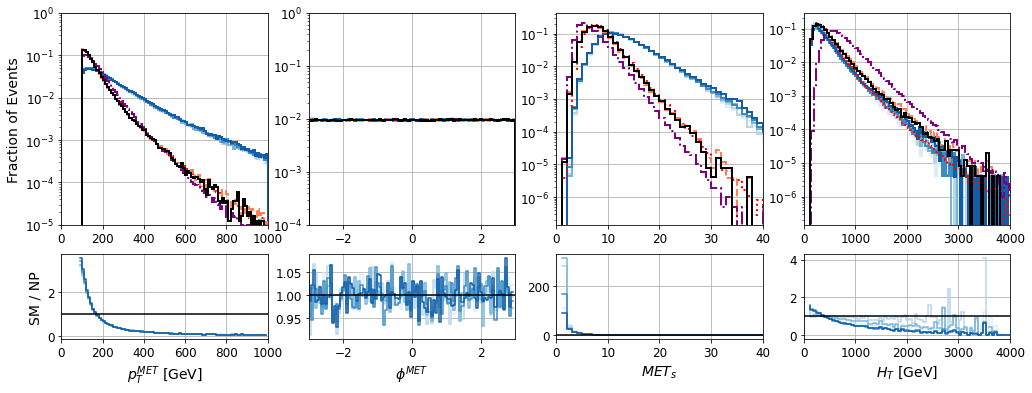

In [199]:
nbins = 100

fig,ax = plt.subplots(2,4, gridspec_kw={'height_ratios': [1,0.4]}, figsize = (17,6))

# Met info -----------------------------------------------------------------------------------------------------------------------
xlabels = [r"$p_{T}^{MET}$ [GeV]", r"$\eta^{MET}$", r"$\phi^{MET}$"]
xlims = [(0,1000), (-2.2,2.2), (-3,3)]
ylims = [(1e-5,1), (1e-4,1), (1e-4,1)]
bin_range = [[0,1000], [-2.2, 2.2], [-3, 3]]

for ij, j in enumerate([0,2]):
    weights = np.ones_like(MET_SM[:,j])/len(MET_SM[:,j])
    h_sm = ax[0,ij].hist(MET_SM[:,j], weights=weights, bins=nbins, range=bin_range[j], lw=2, edgecolor='black', histtype='step', zorder=20)
    ax[0,ij].plot([],[], label='SM', color='black')

    for i in BPs2plot:
        weights = np.ones_like(MET_NP[i][:,j])/len(MET_NP[i][:,j])
        h_np = ax[0,ij].hist(MET_NP[i][:,j], weights=weights, bins=nbins, range=bin_range[j], lw=2, edgecolor=cmap(i), histtype='step', zorder=2)
        ax[0,ij].plot([],[], label=name[i], color=cmap(i))
        ax[1,ij].step(h_sm[1][:-1], h_sm[0] / h_np[0], color=cmap(i))

    weights = np.ones_like(MET_Wgamma[:,j])/len(MET_Wgamma[:,j])
    ax[0,ij].hist(MET_Wgamma[:,j], weights=weights, bins=nbins, range=bin_range[j], lw=2,linestyle='dotted', edgecolor=wgamma_color, histtype='step')
    ax[0,ij].plot([],[], label=r"W $\gamma$", color='red', linestyle = ':')

    weights = np.ones_like(MET_Wjets[:,j])/len(MET_Wjets[:,j])
    ax[0,ij].hist(MET_Wjets[:,j], weights=weights, bins=nbins, range=bin_range[j], lw=2,linestyle='--', edgecolor=wjets_color, histtype='step')
    ax[0,ij].plot([],[], label="W jets", color='coral', linestyle = '--')

    weights = np.ones_like(MET_ttgamma[:,j])/len(MET_ttgamma[:,j])
    ax[0,ij].hist(MET_ttgamma[:,j], weights=weights, bins=nbins, range=bin_range[j], lw=2,linestyle='-.', edgecolor=ttgamma_color, histtype='step')
    ax[0,ij].plot([],[], label="tt $\gamma$", color='purple', linestyle = '-.')

    ax[0,ij].grid()
    ax[1,ij].grid()
    ax[1,ij].set_xlabel(xlabels[j],fontsize=14)
    ax[1,ij].set_ylabel("")
    #ax[0].set_xticks(fontsize=14)
    #ax[0].set_yticks(fontsize=14)
    ax[0,ij].set_yscale('log')
    ax[0,ij].set_xlim(xlims[j])
    ax[1,ij].set_xlim(xlims[j])
    ax[0,ij].set_ylim(ylims[j])

    ax[1,ij].axhline(y = 1, color = 'black')

weights = np.ones_like(MET_sig_SM)/len(MET_sig_SM)
h_sm = ax[0,2].hist(MET_sig_SM, weights=weights, bins=nbins, range=[0,100], lw=2, edgecolor='black', histtype='step', zorder=20)
ax[0,2].plot([],[], label='SM', color='black')

for i in BPs2plot:
    weights = np.ones_like(MET_sig_NP[i])/len(MET_sig_NP[i])
    h_np = ax[0,2].hist(MET_sig_NP[i], weights=weights, bins=nbins, range=[0,100], lw=2, edgecolor=cmap(i), histtype='step', zorder=2)
    ax[0,2].plot([],[], label=name[i], color=cmap(i))
    ax[1,2].step(h_sm[1][:-1], h_sm[0] / h_np[0], color=cmap(i))

weights = np.ones_like(MET_sig_Wgamma)/len(MET_sig_Wgamma)
ax[0,2].hist(MET_sig_Wgamma, weights=weights, bins=nbins, range=[0,100], lw=2,linestyle='dotted', edgecolor=wgamma_color, histtype='step')
ax[0,2].plot([],[], label=r"W $\gamma$", color='red', linestyle = ':')

weights = np.ones_like(MET_sig_Wjets)/len(MET_sig_Wjets)
ax[0,2].hist(MET_sig_Wjets, weights=weights, bins=nbins, range=[0,100], lw=2,linestyle='--', edgecolor=wjets_color, histtype='step')
ax[0,2].plot([],[], label="W jets", color='coral', linestyle = '--')

weights = np.ones_like(MET_sig_ttgamma)/len(MET_sig_ttgamma)
ax[0,2].hist(MET_sig_ttgamma, weights=weights, bins=nbins, range=[0,100], lw=2,linestyle='-.', edgecolor=ttgamma_color, histtype='step')
ax[0,2].plot([],[], label="tt $\gamma$", color='purple', linestyle = '-.')

ax[0,2].grid()
ax[1,2].grid()
ax[1,2].set_xlabel('$MET_{s}$',fontsize=14)
ax[1,2].set_ylabel("")
ax[0,2].set_yscale('log')
ax[0,2].set_xlim(0,40)
ax[1,2].set_xlim(0,40)
ax[1,2].axhline(y = 1, color = 'black')
    
weights = np.ones_like(hadinfo_SM[:,0])/len(hadinfo_SM[:,0])
h_sm = ax[0,3].hist(hadinfo_SM[:,0], weights=weights, bins=nbins, lw=2, edgecolor='black', histtype='step', zorder=20)
ax[0,3].plot([],[], label='SM', color='black')

for i in BPs2plot:
    weights = np.ones_like(hadinfo_NP[i][:,0])/len(hadinfo_NP[i][:,0])
    h_np = ax[0,3].hist(hadinfo_NP[i][:,0], weights=weights, bins=nbins, lw=2, edgecolor=cmap(i), histtype='step', zorder=2)
    ax[0,3].plot([],[], label=name[i], color=cmap(i))
    ax[1,3].step(h_sm[1][:-1], h_sm[0] / h_np[0], color=cmap(i))

weights = np.ones_like(hadinfo_Wgamma[:,0])/len(hadinfo_Wgamma[:,0])
ax[0,3].hist(hadinfo_Wgamma[:,0], weights=weights, bins=nbins, lw=2,linestyle='dotted', edgecolor=wgamma_color, histtype='step')
ax[0,3].plot([],[], label=r"W $\gamma$", color='red', linestyle = ':')

weights = np.ones_like(hadinfo_Wjets[:,0])/len(hadinfo_Wjets[:,0])
ax[0,3].hist(hadinfo_Wjets[:,0], weights=weights, bins=nbins, lw=2,linestyle='--', edgecolor=wjets_color, histtype='step')
ax[0,3].plot([],[], label="W jets", color='coral', linestyle = '--')

weights = np.ones_like(hadinfo_ttgamma[:,0])/len(hadinfo_ttgamma[:,0])
ax[0,3].hist(hadinfo_ttgamma[:,0], weights=weights, bins=nbins, lw=2,linestyle='-.', edgecolor=ttgamma_color, histtype='step')
ax[0,3].plot([],[], label="tt $\gamma$", color='purple', linestyle = '-.')

ax[0,3].grid()
ax[1,3].grid()
ax[1,3].set_xlabel(r"$H_{T}$ [GeV]",fontsize=14)
ax[1,3].set_ylabel("")
#ax[0].set_xticks(fontsize=14)
#ax[0].set_yticks(fontsize=14)
ax[0,3].set_yscale('log')
ax[0,3].set_xlim(0,4000)
ax[1,3].set_xlim(0,4000)
ax[1,3].axhline(y = 1, color = 'black')     
    
ax[0,0].set_ylabel("Fraction of Events",fontsize=14)
ax[1,0].set_ylabel("SM / NP", fontsize=14)
#ax[0,1].legend(loc='upper right',fontsize=9,bbox_to_anchor=(1.9, 1.25), ncol = 5)
plt.savefig('../graph/MET_info_dist.pdf', bbox_inches='tight')

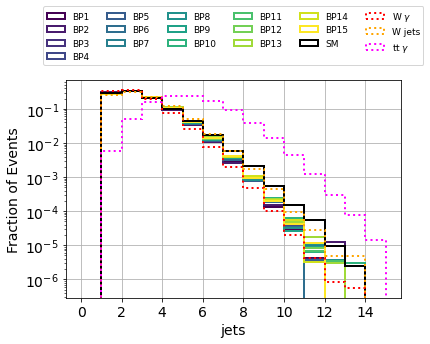

In [42]:
for i in range(len(photon_NP)):
    weights = np.ones_like(hadinfo_NP[i][:,1])/len(hadinfo_NP[i][:,1])
    plt.hist(hadinfo_NP[i][:,1], weights=weights, bins=15, range=[0,15], lw=2, edgecolor=cmap(i), histtype='step', label=name[i], zorder=2)
    
weights = np.ones_like(hadinfo_SM[:,1])/len(hadinfo_SM[:,1])
plt.hist(hadinfo_SM[:,1], weights=weights, bins=15, range=[0,15], lw=2, edgecolor='black', histtype='step', label="SM", zorder=2)
weights = np.ones_like(hadinfo_Wgamma[:,1])/len(hadinfo_Wgamma[:,1])
plt.hist(hadinfo_Wgamma[:,1], weights=weights, bins=15, range=[0,15], lw=2,linestyle='dotted', edgecolor='red', histtype='step', label=r"W $\gamma$")
weights = np.ones_like(hadinfo_Wjets[:,1])/len(hadinfo_Wjets[:,1])
plt.hist(hadinfo_Wjets[:,1], weights=weights, bins=15, range=[0,15], lw=2,linestyle='dotted', edgecolor='orange', histtype='step', label="W jets")
weights = np.ones_like(hadinfo_ttgamma[:,1])/len(hadinfo_ttgamma[:,1])
plt.hist(hadinfo_ttgamma[:,1], weights=weights, bins=15, range=[0,15], lw=2,linestyle='dotted', edgecolor='magenta', histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"jets",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='lower center',fontsize=9,bbox_to_anchor=(0.5, 1.05), ncol = 6)
plt.savefig('../graph/jets_dist.png', bbox_inches='tight')

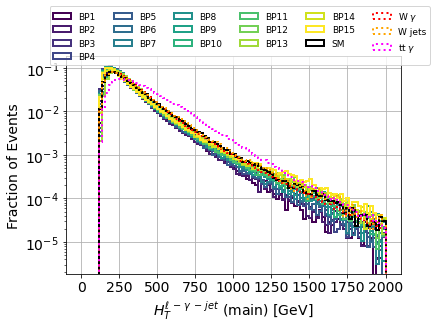

In [43]:
for i in range(len(photon_NP)):
    weights = np.ones_like(HT_main_NP[i])/len(HT_main_NP[i])
    plt.hist(HT_main_NP[i], weights=weights, bins=100, range=[0,2000], lw=2, edgecolor=cmap(i), histtype='step', label=name[i], zorder=2)
    
weights = np.ones_like(HT_main_SM)/len(HT_main_SM)
plt.hist(HT_main_SM, weights=weights, bins=100, range=[0,2000], lw=2, edgecolor='black', histtype='step', label="SM", zorder=2)
weights = np.ones_like(HT_main_Wgamma)/len(HT_main_Wgamma)
plt.hist(HT_main_Wgamma, weights=weights, bins=100, range=[0,2000], lw=2,linestyle='dotted', edgecolor='red', histtype='step', label=r"W $\gamma$")
weights = np.ones_like(HT_main_Wjets)/len(HT_main_Wjets)
plt.hist(HT_main_Wjets, weights=weights, bins=100, range=[0,2000], lw=2,linestyle='dotted', edgecolor='orange', histtype='step', label="W jets")
weights = np.ones_like(HT_main_ttgamma)/len(HT_main_ttgamma)
plt.hist(HT_main_ttgamma, weights=weights, bins=100, range=[0,2000], lw=2,linestyle='dotted', edgecolor='magenta', histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"$H_T^{\ell \,-\, \gamma \,-\, jet}$ (main) [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='upper right',fontsize=9,bbox_to_anchor=(1.1, 1.25), ncol = 6)
plt.savefig('../graph/Ht_dist.png', bbox_inches='tight')

## Correlation Plots

In [107]:
# bp correspond to benchmark points (bp + 1) !!!!
bp = 1
nobs = 150_000

df = pd.DataFrame()

lst = ['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$',
       'lepton $p_T$ [GeV]', 'lepton $\eta$', 'lepton $\phi$',
       'MET $p_T$ [GeV]', 'MET $\phi$',
       '$H_T$ (had) [GeV]', 'num_jets',
       '$H_T$ (main) [GeV]', 'MET sig [GeV]', '$m_{eff}$ [GeV]',
       '$m_T$ photon [GeV]', '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]',
       '$\Delta \phi$ (MET-photon)', '$\Delta \phi$ (MET-jet)', '$\Delta \phi$ (MET-lepton)', 
       '$\Delta R$ (photon-jet)', '$\Delta R$ (photon-lepton)', '$\Delta R$ (lepton-jet)', 
       'SM=0 - NP=1']

df[lst[0]]= np.concatenate([photon_SM[:,0],photon_NP[bp][:nobs,0]])
df[lst[1]]= np.concatenate([photon_SM[:,1],photon_NP[bp][:nobs,1]])
df[lst[2]]= np.concatenate([photon_SM[:,2],photon_NP[bp][:nobs,2]])

df[lst[3]]= np.concatenate([jet_SM[:,0],jet_NP[bp][:nobs,0]])
df[lst[4]]= np.concatenate([jet_SM[:,1],jet_NP[bp][:nobs,1]])
df[lst[5]]= np.concatenate([jet_SM[:,2],jet_NP[bp][:nobs,2]])

df[lst[6]]= np.concatenate([lepton_SM[:,0],lepton_NP[bp][:nobs,0]])
df[lst[7]]= np.concatenate([lepton_SM[:,1],lepton_NP[bp][:nobs,1]])
df[lst[8]]= np.concatenate([lepton_SM[:,2],lepton_NP[bp][:nobs,2]])

df[lst[9]]= np.concatenate([MET_SM[:,0],MET_NP[bp][:nobs,0]])
df[lst[10]]= np.concatenate([MET_SM[:,2],MET_NP[bp][:nobs,2]])

df[lst[11]]= np.concatenate([hadinfo_SM[:,0],hadinfo_NP[bp][:nobs,0]])
df[lst[12]]= np.concatenate([hadinfo_SM[:,1],hadinfo_NP[bp][:nobs,1]])

df[lst[13]]= np.concatenate([HT_main_SM,HT_main_NP[bp][:nobs]])
df[lst[14]]= np.concatenate([MET_sig_SM,MET_sig_NP[bp][:nobs]])
df[lst[15]]= np.concatenate([m_eff_SM,m_eff_NP[bp][:nobs]])

df[lst[16]]= np.concatenate([mT_photon_SM,mT_photon_NP[bp][:nobs]])
df[lst[17]]= np.concatenate([mT_jet_SM,mT_jet_NP[bp][:nobs]])
df[lst[18]]= np.concatenate([mT_lepton_SM,mT_lepton_NP[bp][:nobs]])

df[lst[19]]= np.concatenate([phi_MET_photon_SM,phi_MET_photon_NP[bp][:nobs]])
df[lst[20]]= np.concatenate([phi_MET_jet_SM,phi_MET_jet_NP[bp][:nobs]])
df[lst[21]]= np.concatenate([phi_MET_lepton_SM,phi_MET_lepton_NP[bp][:nobs]])

df[lst[22]]= np.concatenate([deltaR_photon_jet_SM,deltaR_photon_jet_NP[bp][:nobs]])
df[lst[23]]= np.concatenate([deltaR_photon_lepton_SM,deltaR_photon_lepton_NP[bp][:nobs]])
df[lst[24]]= np.concatenate([deltaR_lepton_jet_SM,deltaR_lepton_jet_NP[bp][:nobs]])

df[lst[25]]= np.concatenate([np.zeros(len(photon_SM)),np.ones(len(photon_NP[bp][:nobs]))])

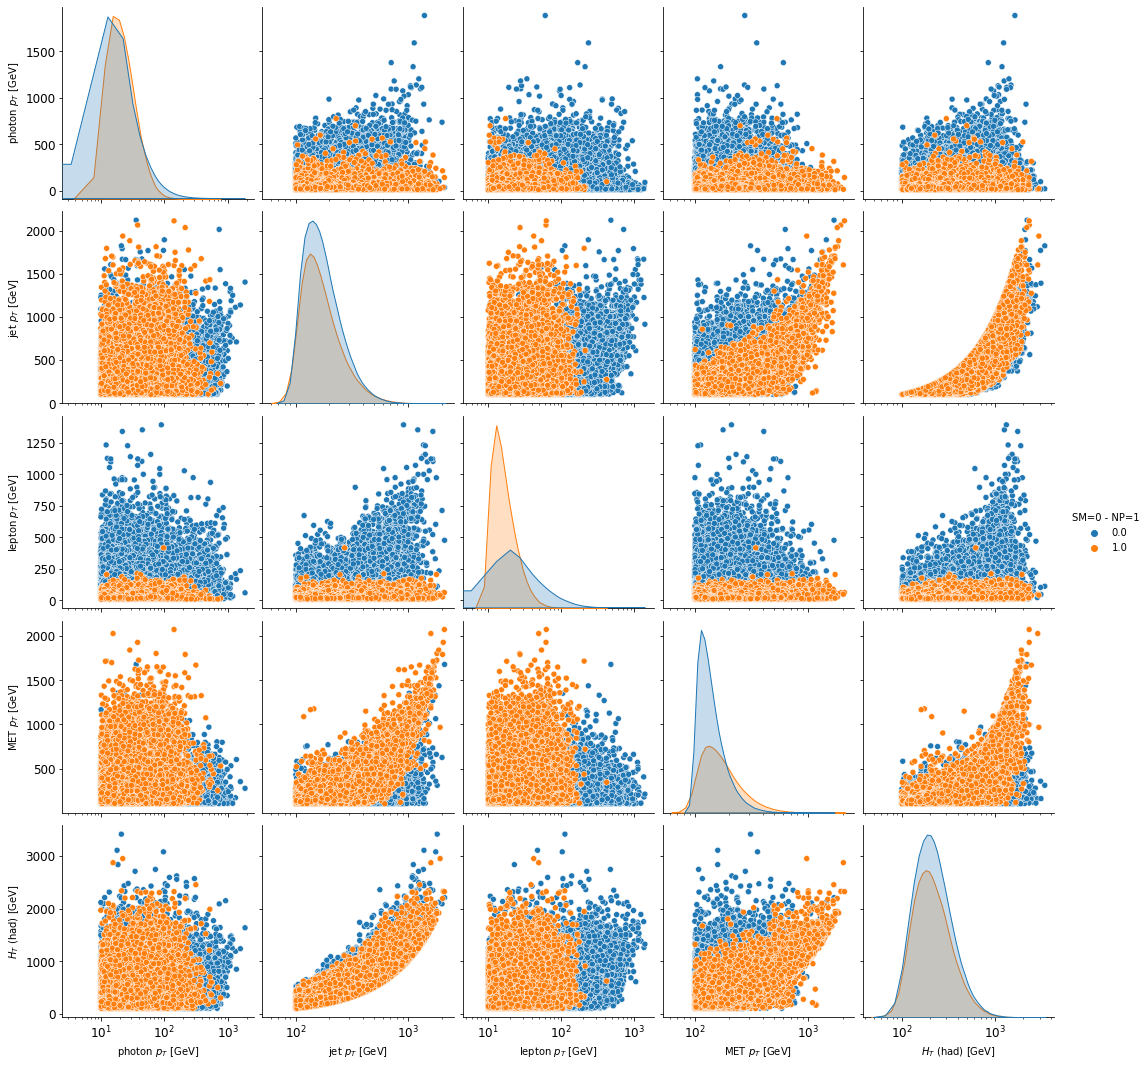

In [108]:
g = sns.pairplot(df, hue="SM=0 - NP=1", height=3,
                 x_vars=[lst[0],lst[3],lst[6],lst[9],lst[11]],
                 y_vars=[lst[0],lst[3],lst[6],lst[9],lst[11]])

log_columns = [lst[0],lst[3],lst[6],lst[9],lst[11]]

for ax in g.axes.flat:
    if ax.get_xlabel() in log_columns:
        ax.set(xscale="log")

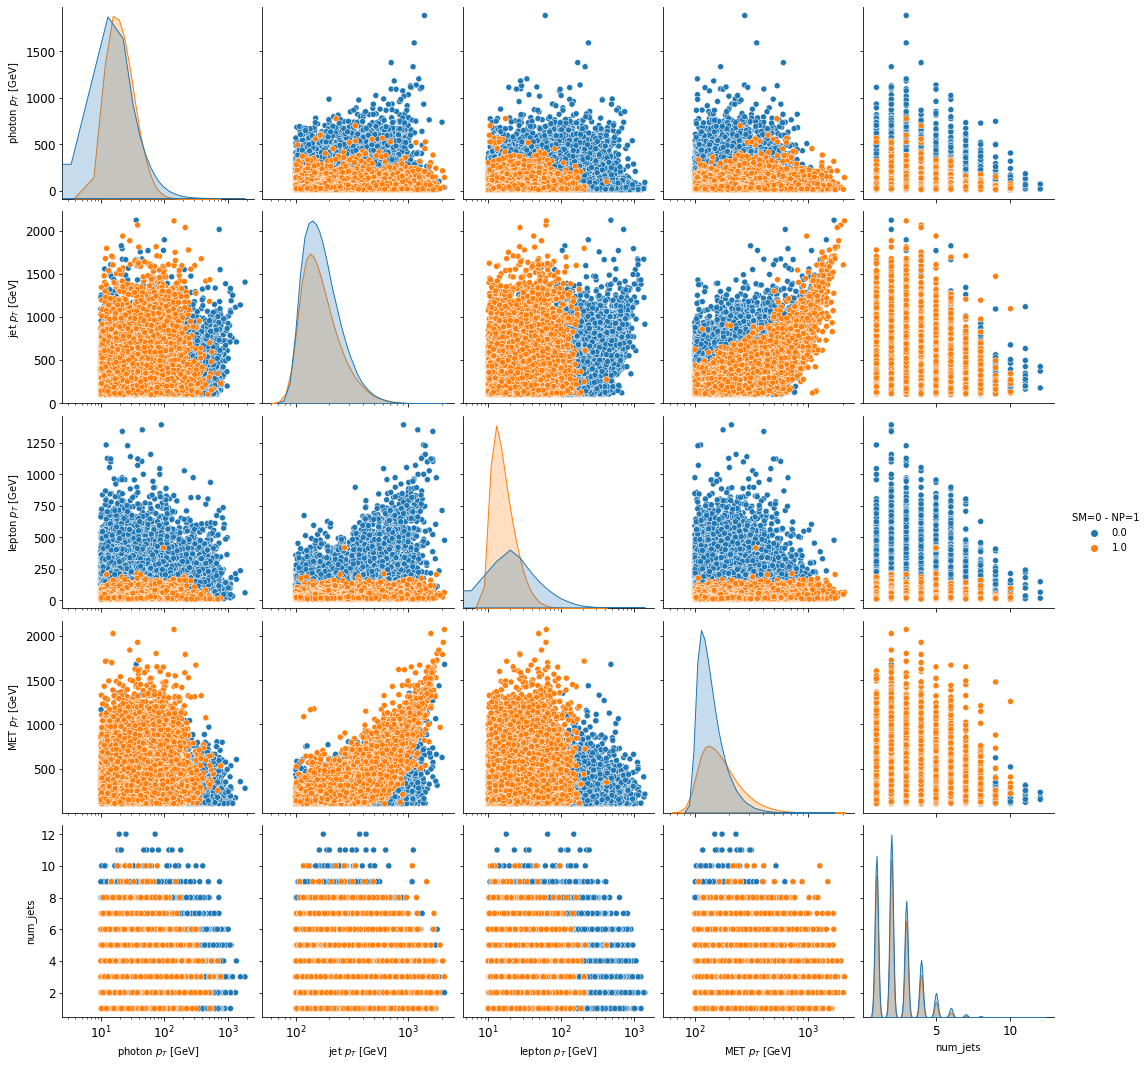

In [109]:
g = sns.pairplot(df, hue="SM=0 - NP=1", height=3,
                 x_vars=[lst[0],lst[3],lst[6],lst[9],lst[12]],
                 y_vars=[lst[0],lst[3],lst[6],lst[9],lst[12]])

log_columns = [lst[0],lst[3],lst[6],lst[9]]

for ax in g.axes.flat:
    if ax.get_xlabel() in log_columns:
        ax.set(xscale="log")

# Analysis

## training

In [76]:
# LOW LEVEL VARIABLES ----------------------

print(photon_SM.shape)
print(jet_SM.shape)
print(lepton_SM.shape)
print(MET_SM.shape)
#-------------------------------------------

# HIGH LEVEL VARIABLES ----------------------
print(hadinfo_SM.shape)
print(ST_SM.shape)
print(MET_sig_SM.shape)
print(m_eff_SM.shape)
print(mT_photon_SM.shape)
print(mT_jet_SM.shape)
print(mT_lepton_SM.shape)
#-------------------------------------------

(180000, 4)
(180000, 3)
(180000, 5)
(180000, 3)
(180000, 3)
(180000,)
(180000,)
(180000,)
(180000,)
(180000,)
(180000,)


In [113]:
# bp correspond to benchmark points (bp + 1) !!!!
bp = 6

# LOW LEVEL VARIABLES ----------------------


print(photon_NP[bp].shape)
print(jet_NP[bp].shape)
print(lepton_NP[bp].shape)
print(MET_NP[bp].shape)
#-------------------------------------------

# HIGH LEVEL VARIABLES ----------------------

print(hadinfo_NP[bp].shape)
print(ST_NP[bp].shape)
print(MET_sig_NP[bp].shape)
print(m_eff_NP[bp].shape)
print(mT_photon_NP[bp].shape)
print(mT_jet_NP[bp].shape)
print(mT_lepton_NP[bp].shape)
#-------------------------------------------

(315960, 4)
(315960, 3)
(315960, 5)
(315960, 3)
(315960, 3)
(315960,)
(315960,)
(315960,)
(315960,)
(315960,)
(315960,)


In [114]:
nobs = np.min( (len(photon_SM), len(photon_NP[bp])) )
nobs

180000

In [115]:
df = pd.DataFrame()

lst = ['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$',
       'lepton $p_T$ [GeV]', 'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$',
       '$H_T$ [GeV]', '$H_T$ (jets) [GeV]', 'num_jets',
       '$S_T$ [GeV]', 
       'MET sig [GeV]',# '$m_{eff}$ [GeV]',
       '$m_T$ photon [GeV]', '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]',
       #'$\Delta \phi$ (MET-photon)', '$\Delta \phi$ (MET-jet)', '$\Delta \phi$ (MET-lepton)', 
       #'$\Delta R$ (photon-jet)', '$\Delta R$ (photon-lepton)', '$\Delta R$ (lepton-jet)', 
       'SM=0 - NP=1']
#np.random.seed(28890)

SM_indices = np.random.choice(np.arange(len(photon_SM)), size = nobs, replace = False)

df[lst[0]]= np.concatenate([photon_SM[SM_indices,0],photon_NP[bp][:nobs,0]])
df[lst[1]]= np.concatenate([photon_SM[SM_indices,1],photon_NP[bp][:nobs,1]])
df[lst[2]]= np.concatenate([photon_SM[SM_indices,2],photon_NP[bp][:nobs,2]])
df[lst[3]]= np.concatenate([photon_SM[SM_indices,3],photon_NP[bp][:nobs,3]])

df[lst[4]]= np.concatenate([jet_SM[SM_indices,0],jet_NP[bp][:nobs,0]])
df[lst[5]]= np.concatenate([jet_SM[SM_indices,1],jet_NP[bp][:nobs,1]])
df[lst[6]]= np.concatenate([jet_SM[SM_indices,2],jet_NP[bp][:nobs,2]])

df[lst[7]]= np.concatenate([lepton_SM[SM_indices,0],lepton_NP[bp][:nobs,0]])
df[lst[8]]= np.concatenate([lepton_SM[SM_indices,1],lepton_NP[bp][:nobs,1]])
df[lst[9]]= np.concatenate([lepton_SM[SM_indices,2],lepton_NP[bp][:nobs,2]])
df[lst[10]]= np.concatenate([lepton_SM[SM_indices,3],lepton_NP[bp][:nobs,3]])
df[lst[11]]= np.concatenate([lepton_SM[SM_indices,4],lepton_NP[bp][:nobs,4]])

df[lst[12]]= np.concatenate([MET_SM[SM_indices,0],MET_NP[bp][:nobs,0]])
df[lst[13]]= np.concatenate([MET_SM[SM_indices,2],MET_NP[bp][:nobs,2]])

df[lst[14]]= np.concatenate([hadinfo_SM[SM_indices,0],hadinfo_NP[bp][:nobs,0]])
df[lst[15]]= np.concatenate([hadinfo_SM[SM_indices,1],hadinfo_NP[bp][:nobs,1]])
df[lst[16]]= np.concatenate([hadinfo_SM[SM_indices,2],hadinfo_NP[bp][:nobs,2]])

df[lst[17]]= np.concatenate([ST_SM[SM_indices], ST_NP[bp][:nobs]])
df[lst[18]]= np.concatenate([MET_sig_SM[SM_indices], MET_sig_NP[bp][:nobs]])
#df[lst[19]]= np.concatenate([m_eff_SM[SM_indices], m_eff_NP[bp][:nobs]])

df[lst[19]]= np.concatenate([mT_photon_SM[SM_indices], mT_photon_NP[bp][:nobs]])
df[lst[20]]= np.concatenate([mT_jet_SM[SM_indices], mT_jet_NP[bp][:nobs]])
df[lst[21]]= np.concatenate([mT_lepton_SM[SM_indices], mT_lepton_NP[bp][:nobs]])

#%df[lst[22]]= np.concatenate([phi_MET_photon_SM[SM_indices], phi_MET_photon_NP[bp][:nobs]])
#%df[lst[23]]= np.concatenate([phi_MET_jet_SM[SM_indices], phi_MET_jet_NP[bp][:nobs]])
#%df[lst[24]]= np.concatenate([phi_MET_lepton_SM[SM_indices], phi_MET_lepton_NP[bp][:nobs]])

#%df[lst[25]]= np.concatenate([deltaR_photon_jet_SM[SM_indices], deltaR_photon_jet_NP[bp][:nobs]])
#%df[lst[26]]= np.concatenate([deltaR_photon_lepton_SM[SM_indices], deltaR_photon_lepton_NP[bp][:nobs]])
#%df[lst[27]]= np.concatenate([deltaR_lepton_jet_SM[SM_indices], deltaR_lepton_jet_NP[bp][:nobs]])


df['bkg_flag']= np.concatenate( (bkg_flag[SM_indices], np.zeros(len(photon_NP[bp][:nobs]))) )

df[lst[22]]= np.concatenate([np.zeros(len(photon_SM[SM_indices])), np.ones(len(photon_NP[bp][:nobs]))])

df_array = np.asarray(df)
df

,photon $p_T$ [GeV],photon $\eta$,photon $\phi$,num photon,jet $p_T$ [GeV],jet $\eta$,jet $\phi$,lepton $p_T$ [GeV],lepton $\eta$,lepton $\phi$,...,$H_T$ [GeV],$H_T$ (jets) [GeV],num_jets,$S_T$ [GeV],MET sig [GeV],$m_T$ photon [GeV],$m_T$ jet [GeV],$m_T$ lepton [GeV],bkg_flag,SM=0 - NP=1
0,65.00,-1.934,1.677,1.0,223.73,-2.906,-1.908,14.26,-1.607,2.455,...,302.99,223.73,1.0,302.99,8.523774,54.655938,363.726720,57.199498,1.0,0.0
1,65.56,-0.804,2.252,1.0,215.00,0.520,2.545,21.35,-2.432,-2.425,...,456.99,370.08,4.0,301.91,7.163198,189.199411,356.411238,102.095863,1.0,0.0
2,22.99,1.786,-3.067,1.0,171.47,0.489,0.217,39.39,1.736,-2.302,...,233.85,171.47,1.0,233.85,6.602732,7.853527,260.094233,56.457352,1.0,0.0
3,17.27,-0.942,-0.844,1.0,188.56,-0.626,-2.723,104.91,-0.969,-0.285,...,553.26,431.08,4.0,310.74,5.287082,17.140458,276.397557,21.328359,1.0,0.0
4,10.67,-2.076,1.692,1.0,135.42,-1.412,-1.339,23.21,-2.189,2.921,...,169.30,135.42,1.0,169.30,9.679874,6.370632,258.558439,69.786520,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359995,60.06,1.057,-2.932,1.0,290.17,1.082,-1.173,19.77,0.443,2.412,...,755.84,676.01,4.0,370.00,22.239484,249.557405,842.281564,52.161351,0.0,1.0
359996,27.71,1.162,-0.224,1.0,233.25,-1.359,2.804,14.76,-0.155,3.067,...,275.72,233.25,1.0,275.72,13.917045,3.360673,464.037514,116.271109,0.0,1.0
359997,54.95,-0.111,2.808,1.0,150.44,1.185,-1.201,23.45,1.564,-0.628,...,263.98,185.58,2.0,228.84,8.656122,105.210320,284.656794,101.108557,0.0,1.0
359998,46.69,-0.648,1.972,1.0,177.10,1.116,0.971,48.53,1.125,-1.759,...,272.32,177.10,1.0,272.32,8.866133,151.916486,320.480265,18.584473,0.0,1.0


In [116]:
df_test = pd.DataFrame()

lst = ['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$',
       'lepton $p_T$ [GeV]', 'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$',
       '$H_T$ [GeV]', '$H_T$ (jets) [GeV]', 'num_jets',
       '$S_T$ [GeV]', 
       'MET sig [GeV]',# '$m_{eff}$ [GeV]',
       '$m_T$ photon [GeV]', '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]',
       #'$\Delta \phi$ (MET-photon)', '$\Delta \phi$ (MET-jet)', '$\Delta \phi$ (MET-lepton)', 
       #'$\Delta R$ (photon-jet)', '$\Delta R$ (photon-lepton)', '$\Delta R$ (lepton-jet)', 
       'SM=0 - NP=1']

SM_indices = np.random.choice(np.arange(len(photon_SM_pool)), size = len(photon_SM_pool), replace = False)

df_test[lst[0]]= np.concatenate([photon_SM_pool[SM_indices,0],photon_NP[bp][nobs:,0]])
df_test[lst[1]]= np.concatenate([photon_SM_pool[SM_indices,1],photon_NP[bp][nobs:,1]])
df_test[lst[2]]= np.concatenate([photon_SM_pool[SM_indices,2],photon_NP[bp][nobs:,2]])
df_test[lst[3]]= np.concatenate([photon_SM_pool[SM_indices,3],photon_NP[bp][nobs:,3]])

df_test[lst[4]]= np.concatenate([jet_SM_pool[SM_indices,0],jet_NP[bp][nobs:,0]])
df_test[lst[5]]= np.concatenate([jet_SM_pool[SM_indices,1],jet_NP[bp][nobs:,1]])
df_test[lst[6]]= np.concatenate([jet_SM_pool[SM_indices,2],jet_NP[bp][nobs:,2]])

df_test[lst[7]]= np.concatenate([lepton_SM_pool[SM_indices,0],lepton_NP[bp][nobs:,0]])
df_test[lst[8]]= np.concatenate([lepton_SM_pool[SM_indices,1],lepton_NP[bp][nobs:,1]])
df_test[lst[9]]= np.concatenate([lepton_SM_pool[SM_indices,2],lepton_NP[bp][nobs:,2]])
df_test[lst[10]]= np.concatenate([lepton_SM_pool[SM_indices,3],lepton_NP[bp][nobs:,3]])
df_test[lst[11]]= np.concatenate([lepton_SM_pool[SM_indices,4],lepton_NP[bp][nobs:,4]])

df_test[lst[12]]= np.concatenate([MET_SM_pool[SM_indices,0],MET_NP[bp][nobs:,0]])
df_test[lst[13]]= np.concatenate([MET_SM_pool[SM_indices,2],MET_NP[bp][nobs:,2]])

df_test[lst[14]]= np.concatenate([hadinfo_SM_pool[SM_indices,0],hadinfo_NP[bp][nobs:,0]])
df_test[lst[15]]= np.concatenate([hadinfo_SM_pool[SM_indices,1],hadinfo_NP[bp][nobs:,1]])
df_test[lst[16]]= np.concatenate([hadinfo_SM_pool[SM_indices,2],hadinfo_NP[bp][nobs:,2]])

df_test[lst[17]]= np.concatenate([ST_SM_pool[SM_indices], ST_NP[bp][nobs:]])
df_test[lst[18]]= np.concatenate([MET_sig_SM_pool[SM_indices], MET_sig_NP[bp][nobs:]])
#df_test[lst[19]]= np.concatenate([m_eff_SM_pool[SM_indices], m_eff_NP[bp][nobs:]])

df_test[lst[19]]= np.concatenate([mT_photon_SM_pool[SM_indices], mT_photon_NP[bp][nobs:]])
df_test[lst[20]]= np.concatenate([mT_jet_SM_pool[SM_indices], mT_jet_NP[bp][nobs:]])
df_test[lst[21]]= np.concatenate([mT_lepton_SM_pool[SM_indices], mT_lepton_NP[bp][nobs:]])

#%df_test[lst[22]]= np.concatenate([phi_MET_photon_SM_pool[SM_indices], phi_MET_photon_NP[bp][nobs:]])
#%df_test[lst[23]]= np.concatenate([phi_MET_jet_SM_pool[SM_indices], phi_MET_jet_NP[bp][nobs:]])
#%df_test[lst[24]]= np.concatenate([phi_MET_lepton_SM_pool[SM_indices], phi_MET_lepton_NP[bp][nobs:]])

#%df_test[lst[25]]= np.concatenate([deltaR_photon_jet_SM_pool[SM_indices], deltaR_photon_jet_NP[bp][nobs:]])
#%df_test[lst[26]]= np.concatenate([deltaR_photon_lepton_SM_pool[SM_indices], deltaR_photon_lepton_NP[bp][nobs:]])
#%df_test[lst[27]]= np.concatenate([deltaR_lepton_jet_SM_pool[SM_indices], deltaR_lepton_jet_NP[bp][nobs:]])


df_test['bkg_flag_pool']= np.concatenate( (bkg_flag_pool[SM_indices], np.zeros(len(photon_NP[bp][nobs:]))) )

df_test[lst[22]]= np.concatenate([np.zeros(len(photon_SM_pool[SM_indices])), np.ones(len(photon_NP[bp][nobs:]))])

df_test_array = np.asarray(df_test)
df_test

,photon $p_T$ [GeV],photon $\eta$,photon $\phi$,num photon,jet $p_T$ [GeV],jet $\eta$,jet $\phi$,lepton $p_T$ [GeV],lepton $\eta$,lepton $\phi$,...,$H_T$ [GeV],$H_T$ (jets) [GeV],num_jets,$S_T$ [GeV],MET sig [GeV],$m_T$ photon [GeV],$m_T$ jet [GeV],$m_T$ lepton [GeV],bkg_flag_pool,SM=0 - NP=1
0,230.25,2.246,-0.888,1.0,169.13,1.441,2.778,19.19,1.129,-0.761,...,418.57,169.13,1.0,418.57,6.345868,330.010900,158.803984,93.188114,1.0,0.0
1,36.41,1.082,-1.967,1.0,186.66,0.146,1.454,34.34,0.712,-1.050,...,285.72,214.97,2.0,257.41,6.993920,3.280051,295.146628,53.527408,1.0,0.0
2,412.37,0.201,-2.911,1.0,1213.76,-1.539,1.336,167.73,0.403,-1.368,...,1917.62,1337.52,3.0,1793.86,18.379956,746.679237,1953.903608,48.831464,2.0,0.0
3,27.77,-0.481,2.241,1.0,374.08,-0.247,-0.380,127.09,-0.728,-3.003,...,627.18,472.32,3.0,528.94,10.252136,51.115471,619.132272,76.051125,1.0,0.0
4,53.23,-0.471,0.856,1.0,146.82,1.321,-1.692,22.00,-1.176,-0.015,...,222.05,146.82,1.0,222.05,9.201185,89.816105,274.465583,91.772029,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480179,26.22,1.499,-2.885,1.0,399.13,-0.636,-1.933,47.55,1.057,1.531,...,537.10,463.33,2.0,472.90,17.727836,179.551712,808.895005,31.104378,0.0,1.0
480180,14.93,-0.313,-2.316,1.0,842.13,0.092,2.695,21.05,-0.560,-1.231,...,1162.75,1126.77,5.0,878.11,29.906637,186.780950,1848.045856,91.063948,0.0,1.0
480181,48.22,-0.171,-2.642,1.0,220.90,-2.730,-2.426,32.58,0.457,-0.270,...,353.38,272.58,2.0,301.70,13.173459,217.768049,467.649410,81.278813,0.0,1.0
480182,60.72,0.505,1.214,1.0,269.14,-0.399,-2.802,32.36,1.799,-0.418,...,499.19,406.11,2.0,362.22,14.336763,113.479965,587.136645,78.731428,0.0,1.0


In [117]:
nobs = len(df_array)

train_size = int(0.80 * nobs)
#%test_size  = int(0.15 * nobs)
val_size   = nobs - train_size #%- test_size 

random_indices = np.random.choice(np.arange(nobs), size = nobs, replace = False)

train_indices = random_indices[:train_size]
#%test_indices  = random_indices[train_size:(train_size + test_size)]
#%val_indices   = random_indices[(train_size + test_size):]
val_indices   = random_indices[train_size:]

In [118]:
print('Variables to analyze:', df.columns[:22])

Variables to analyze: Index(['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$', 'lepton $p_T$ [GeV]',
       'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$', '$H_T$ [GeV]', '$H_T$ (jets) [GeV]',
       'num_jets', '$S_T$ [GeV]', 'MET sig [GeV]', '$m_T$ photon [GeV]',
       '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]'],
      dtype='object')


In [119]:
print('Bkg flag:', df.columns[22]) # Just to check

Bkg flag: bkg_flag


In [120]:
X_train        = df_array[train_indices, :22]
bkg_flag_train = df_array[train_indices, 22]
y_mon_train    = df_array[train_indices, -1]

X_test        = df_test_array[:, :22]
bkg_flag_test = df_test_array[:, 22]
y_mon_test    = df_test_array[:, -1]

X_val        = df_array[val_indices, :22]
bkg_flag_val = df_array[val_indices, 22]
y_mon_val    = df_array[val_indices, -1]

In [121]:
ind_signal_train  = np.where(bkg_flag_train == 0)[0]
ind_wgamma_train  = np.where(bkg_flag_train == 1)[0] # W gamma
ind_wjets_train   = np.where(bkg_flag_train == 2)[0] # W jets
ind_ttgamma_train = np.where(bkg_flag_train == 3)[0] # tt gamma

if(len(ind_signal_train) < S_expected[bp]): print('There are less signal events {} than expected {}'.format(len(ind_signal_train), S_expected[bp]))

if(len(ind_wgamma_train) < Wgamma_expected): print('There are less Wgamma events {} than expected {}'.format(len(ind_wgamma_train), Wgamma_expected))
if(len(ind_ttgamma_train) < ttgamma_expected): print('There are less ttgamma events {} than expected {}'.format(len(ind_ttgamma_train), ttgamma_expected))
if(len(ind_wjets_train) < Wjets_expected): print('There are less Wjets events {} than expected {}'.format(len(ind_wjets_train), Wjets_expected))

In [122]:
ind_signal_test  = np.where(bkg_flag_test == 0)[0]
ind_wgamma_test  = np.where(bkg_flag_test == 1)[0] # W gamma
ind_wjets_test   = np.where(bkg_flag_test == 2)[0] # W jets
ind_ttgamma_test = np.where(bkg_flag_test == 3)[0] # tt gamma

if(len(ind_signal_test) < S_expected[bp]): print('There are less signal events {} than expected {}'.format(len(ind_signal_test), S_expected[bp]))

if(len(ind_wgamma_test) < Wgamma_expected): print('There are less Wgamma events {} than expected {}'.format(len(ind_wgamma_test), Wgamma_expected))
if(len(ind_ttgamma_test) < ttgamma_expected): print('There are less ttgamma events {} than expected {}'.format(len(ind_ttgamma_test), ttgamma_expected))
if(len(ind_wjets_test) < Wjets_expected): print('There are less Wjets events {} than expected {}'.format(len(ind_wjets_test), Wjets_expected))

In [123]:
# to normalize
x_scaler = preprocessing.MinMaxScaler()
x_scaler = x_scaler.fit(X_train)

X_mon_train = x_scaler.transform(X_train)
X_mon_test  = x_scaler.transform(X_test)
X_mon_val   = x_scaler.transform(X_val)

In [124]:
ind_signal  = np.where(bkg_flag_val == 0)[0]
ind_wgamma  = np.where(bkg_flag_val == 1)[0] # W gamma
ind_wjets   = np.where(bkg_flag_val == 2)[0] # W jets
ind_ttgamma = np.where(bkg_flag_val == 3)[0] # tt gamma

In [125]:
if(len(ind_signal) < S_expected[bp]): print('There are less signal events {} than expected {}'.format(len(ind_signal), S_expected[bp]))

if(len(ind_wgamma) < Wgamma_expected): print('There are less Wgamma events {} than expected {}'.format(len(ind_wgamma), Wgamma_expected))
if(len(ind_ttgamma) < ttgamma_expected): print('There are less ttgamma events {} than expected {}'.format(len(ind_ttgamma), ttgamma_expected))
if(len(ind_wjets) < Wjets_expected): print('There are less Wjets events {} than expected {}'.format(len(ind_wjets), Wjets_expected))

There are less Wgamma events 17432 than expected 58462.347349489064
There are less ttgamma events 840 than expected 2877.3979008
There are less Wjets events 17732 than expected 60057.888696312366


In [126]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators  = 500,
    learning_rate = 0.1,
    reg_lambda    = 0.0, reg_alpha = 0.0,
    early_stopping_rounds = 50,#early stopping
    eval_metric = 'logloss',
    gamma = 0.0, objective = 'binary:logistic',
    max_depth = 5)

# FIT
classifier.fit(X_mon_train, y_mon_train, 
               eval_set = [(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
               verbose  =True)

[0]	validation_0-logloss:0.65215	validation_1-logloss:0.65271
[1]	validation_0-logloss:0.61803	validation_1-logloss:0.61896
[2]	validation_0-logloss:0.58919	validation_1-logloss:0.59044
[3]	validation_0-logloss:0.56478	validation_1-logloss:0.56633
[4]	validation_0-logloss:0.54367	validation_1-logloss:0.54545
[5]	validation_0-logloss:0.52508	validation_1-logloss:0.52710
[6]	validation_0-logloss:0.50882	validation_1-logloss:0.51102
[7]	validation_0-logloss:0.49507	validation_1-logloss:0.49736
[8]	validation_0-logloss:0.48226	validation_1-logloss:0.48472
[9]	validation_0-logloss:0.47090	validation_1-logloss:0.47348
[10]	validation_0-logloss:0.46093	validation_1-logloss:0.46363
[11]	validation_0-logloss:0.45165	validation_1-logloss:0.45448
[12]	validation_0-logloss:0.44326	validation_1-logloss:0.44621
[13]	validation_0-logloss:0.43640	validation_1-logloss:0.43942
[14]	validation_0-logloss:0.42991	validation_1-logloss:0.43308
[15]	validation_0-logloss:0.42357	validation_1-logloss:0.42684
[1

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=50, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=0.0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [127]:
# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]

In [128]:
print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')


X_mon_train :  (288000, 22)
y_mon_train :  (288000,)
X_mon_val :  (72000, 22)
y_mon_val :  (72000,)
X_mon_test :  (480184, 22)
y_mon_test :  (480184,)



In [129]:
# Let's estimate the ROC Curve
nvals = 50
tpr_total   = np.zeros(nvals) 
fpr_total   = np.zeros(nvals) 
tpr_ttgamma = np.zeros(nvals) 
fpr_ttgamma = np.zeros(nvals) 
tpr_wgamma  = np.zeros(nvals) 
fpr_wgamma  = np.zeros(nvals) 
tpr_wjets   = np.zeros(nvals) 
fpr_wjets   = np.zeros(nvals) 

for ith, th in enumerate(np.linspace(0,1, nvals)):
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test != 0) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test != 0) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_total[ith] = len(tp) / (len(tp) + len(fn))
    fpr_total[ith] = len(fp) / (len(fp) + len(tn))
    
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test == 1) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test == 1) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_wgamma[ith] = len(tp) / (len(tp) + len(fn))
    fpr_wgamma[ith] = len(fp) / (len(fp) + len(tn))
    
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test == 2) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test == 2) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_wjets[ith] = len(tp) / (len(tp) + len(fn))
    fpr_wjets[ith] = len(fp) / (len(fp) + len(tn))
    
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test == 3) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test == 3) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_ttgamma[ith] = len(tp) / (len(tp) + len(fn))
    fpr_ttgamma[ith] = len(fp) / (len(fp) + len(tn))
    
auc_total = auc(fpr_total, tpr_total)
auc_wgamma = auc(fpr_wgamma, tpr_wgamma)
auc_wjets = auc(fpr_wjets, tpr_wjets)
auc_ttgamma = auc(fpr_ttgamma, tpr_ttgamma)

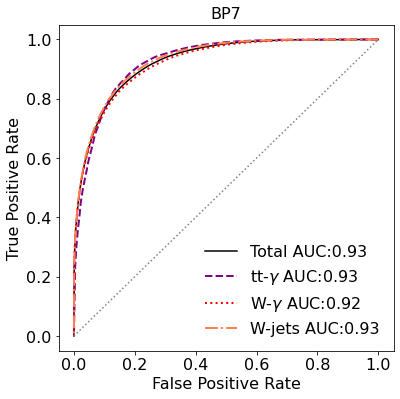

In [130]:
plt.figure(figsize=(6, 6))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.plot(fpr_total, tpr_total, c = 'black', label = 'Total AUC:{:.2f}'.format(auc_total))
plt.plot(fpr_ttgamma, tpr_ttgamma, c = ttgamma_color, linestyle = '--', lw = 2, label = 'tt-$\gamma$ AUC:{:.2f}'.format(auc_ttgamma))
plt.plot(fpr_wgamma, tpr_wgamma, c = wgamma_color, linestyle = ':', lw = 2, label = 'W-$\gamma$ AUC:{:.2f}'.format(auc_wgamma))
plt.plot(fpr_wjets, tpr_wjets, c = wjets_color, linestyle = '-.', lw = 2, label = 'W-jets AUC:{:.2f}'.format(auc_wjets))
plt.legend(frameon=False,fontsize=16)
plt.ylabel("True Positive Rate",fontsize=16)
plt.xlabel("False Positive Rate",fontsize=16)
plt.plot([0,1],[0,1],ls=":",color="grey")
plt.title(r"BP" + str(bp + 1),fontsize=16)

plt.savefig('../graph/ROC_BP' + str(bp + 1) + '_All.png', bbox_inches='tight')

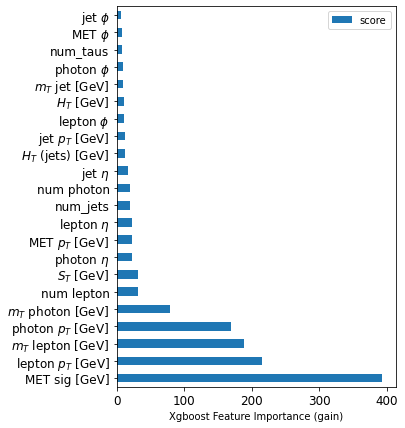

In [131]:
fig, ax = plt.subplots(figsize = (5,7))

feature_important = classifier.get_booster().get_score(importance_type='gain')
values = list(feature_important.values())

data = pd.DataFrame(data=values, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(len(lst) - 1, columns="score").plot(kind='barh', ax = ax) ## plot top 20 features

ax.set_xlabel("Xgboost Feature Importance (gain)")
ax.set_yticklabels(np.asarray(lst)[np.argsort(values)[::-1]])

plt.savefig('../graph/BP' + str(bp + 1) + '_featureImportance_All.png', bbox_inches='tight')

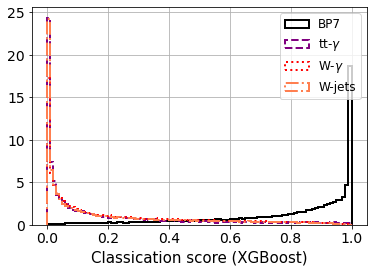

In [132]:
plt.hist(y_pred_xg[np.where(bkg_flag_test == 0)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = 'black', label = 'BP' + str(bp + 1), lw = 2)
plt.hist(y_pred_xg[np.where(bkg_flag_test == 3)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = ttgamma_color, linestyle = '--', lw = 2, label = 'tt-$\gamma$')
plt.hist(y_pred_xg[np.where(bkg_flag_test == 1)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = wgamma_color, linestyle = ':', lw = 2, label = 'W-$\gamma$')
plt.hist(y_pred_xg[np.where(bkg_flag_test == 2)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = wjets_color, linestyle = '-.', lw = 2, label = 'W-jets')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
#plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)
plt.savefig('../graph/MLOutput_dist_BP' + str(bp + 1) + '_All.png', bbox_inches="tight")

In [133]:
pred_XG_NP = y_pred_xg[np.where(bkg_flag_test == 0)[0]]
pred_XG_SM = y_pred_xg[np.where(bkg_flag_test != 0)[0]]

In [134]:
len(np.where(bkg_flag_test != 0)[0])

344224

In [135]:
len(np.where(bkg_flag_test == 0)[0])

135960

Text(0.5, 1.0, 'BP7')

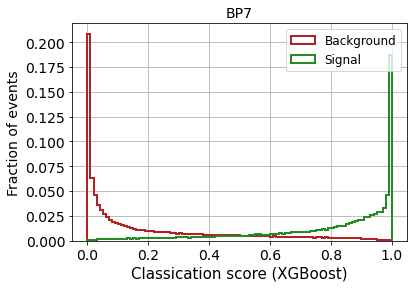

In [136]:
# XGBoost

########################
# CLASSIFICATION SCORE #
########################
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 100, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 100, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)
plt.title('BP' + str(bp + 1), fontsize=14)

#plt.savefig('../graph/' + '2monian-output.pdf', format="pdf", bbox_inches="tight")

In [137]:
S_expected[bp]

66.07734672000001

In [138]:
S_expected[bp] / np.sqrt(B_expected)

0.18964765838094205

In [139]:
print('MLL aproximated Z:')
print( MLL_aprox_discovery_ox(pred_XG_SM, pred_XG_NP, int(B_expected), int(S_expected[bp]))) 

MLL aproximated Z:
nan


/tmp/ipykernel_782804/1019789035.py:10: RuntimeWarning: invalid value encountered in double_scalars
  return (f0 + fB + fS)**0.5


## Sequential selection criteria

In [176]:
nbins = 10
indices_aux = np.arange(len(df_test_array))
        
n_np0      = len(np.where(df_test_array[:, 22] == 0)[0])
n_wgamma0  = len(np.where(df_test_array[:, 22] == 1)[0])
n_wjets0   = len(np.where(df_test_array[:, 22] == 2)[0])
n_ttgamma0 = len(np.where(df_test_array[:, 22] == 3)[0])

sup_cuts = {}
inf_cuts = {}
random_vars = np.random.choice(range(len(df_test.columns) - 2), size = 50, replace = True)

for ivar in random_vars:
    #print(indices_aux)
    cuts = np.linspace(np.min(df_test_array[indices_aux,ivar]), np.max(df_test_array[indices_aux,ivar]), nbins)
    Z_sup = np.zeros(nbins)
    Z_inf = np.zeros(nbins)

    indices = []
    Z = []
    for icut, cut in enumerate(cuts): 
        
        # Superior ------------------------------------------------------------------------------------
        indices_sup = indices_aux[np.where( (df_test_array[indices_aux,ivar] >= cut) )[0]]
        indices.append(indices_sup)
        n_np      = len(np.where(df_test_array[indices_sup, 22] == 0)[0])
        n_wgamma  = len(np.where(df_test_array[indices_sup, 22] == 1)[0])
        n_wjets   = len(np.where(df_test_array[indices_sup, 22] == 2)[0])
        n_ttgamma = len(np.where(df_test_array[indices_sup, 22] == 3)[0])

        ttgamma_expected = ttgamma_cross * 1000 * ttgamma_NLO * luminosidad * (n_ttgamma * ttgamma_aceptancia_init / n_ttgamma0)
        wgamma_expected  = Wgamma_cross * 1000 * Wgamma_NLO * luminosidad * (n_wgamma * Wgamma_aceptancia_init / n_wgamma0)
        wjets_expected   = Wjets_cross * 1000 * Wjets_NLO * luminosidad * (n_wjets * Wjets_aceptancia_init / n_wjets0)


        S_expected_aux = int(cross[bp] * luminosidad * (n_np * aceptancia[bp] / n_np0))

        # Formula discovery
        B_expected_aux = int(ttgamma_expected + wgamma_expected + wjets_expected)
        #if B_expected > 5: Z_sup[icut] = np.sqrt(2 * ((B_expected + S_expected) * np.log(1 + S_expected / B_expected) - S_expected))
        if (B_expected_aux > 5) and (S_expected_aux > 5): 
            Z_sup[icut] = np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux))
            Z.append( np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux)) )
        else:
            Z.append(0)
        #----------------------------------------------------------------------------------------------------

        # Inferior ------------------------------------------------------------------------------------
        indices_inf = indices_aux[np.where( (df_test_array[indices_aux,ivar] <= cut) )[0]]
        indices.append(indices_inf)
        
        n_np      = len(np.where(df_test_array[indices_inf, 22] == 0)[0])
        n_wgamma  = len(np.where(df_test_array[indices_inf, 22] == 1)[0])
        n_wjets   = len(np.where(df_test_array[indices_inf, 22] == 2)[0])
        n_ttgamma = len(np.where(df_test_array[indices_inf, 22] == 3)[0])

        ttgamma_expected = ttgamma_cross * 1000 * ttgamma_NLO * luminosidad * (n_ttgamma * ttgamma_aceptancia_init / n_ttgamma0)
        wgamma_expected  = Wgamma_cross * 1000 * Wgamma_NLO * luminosidad * (n_wgamma * Wgamma_aceptancia_init / n_wgamma0)
        wjets_expected   = Wjets_cross * 1000 * Wjets_NLO * luminosidad * (n_wjets * Wjets_aceptancia_init / n_wjets0)

        S_expected_aux = int(cross[bp] * luminosidad * (n_np * aceptancia[bp] / n_np0))

        # Formula discovery
        B_expected_aux = int(ttgamma_expected + wgamma_expected + wjets_expected)
        #if B_expected > 5: Z_inf[icut] = np.sqrt(2 * ((B_expected + S_expected) * np.log(1 + S_expected / B_expected) - S_expected))
        if (B_expected_aux > 5) and (S_expected_aux > 5): 
            Z_inf[icut] = np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux))
            Z.append( np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux)) )
        else:
            Z.append(0)
        #----------------------------------------------------------------------------------------------------
    max_cut = np.argmax(np.asarray(Z))
    #print('Z = ' + str(Z[max_cut]))
    indices_aux = indices[max_cut]
    max_cut = np.argmax((Z_inf, Z_sup))
    if max_cut >= len(Z_inf):
        print(df_test.columns[ivar] + ' >= ' + str(cuts[max_cut - len(Z_sup)]) + '; Z = ' + str(Z_sup[max_cut - len(Z_inf)]))
    #%    indices_aux = indices_aux[np.where( (df_test_array[indices_aux,ivar] >= cuts[max_cut - len(Z_sup)]) )[0]]
        if df.columns[ivar] in inf_cuts.keys():
            inf_cuts[df_test.columns[ivar]] = cuts[max_cut - len(Z_sup)]
        inf_cuts.setdefault(df_test.columns[ivar], cuts[max_cut - len(Z_sup)])
        sup_cuts.setdefault(df_test.columns[ivar], 999999)
    else:
        print(df_test.columns[ivar] + ' <= ' + str(cuts[max_cut]) + '; Z = ' + str(Z_inf[max_cut]))
    #%    indices_aux = indices_aux[np.where( (df_array[indices_aux,ivar] <= cuts[max_cut]) )[0]]
        if df.columns[ivar] in sup_cuts.keys():
            sup_cuts[df_test.columns[ivar]] = cuts[max_cut]
        sup_cuts.setdefault(df_test.columns[ivar], cuts[max_cut])
        inf_cuts.setdefault(df_test.columns[ivar], -999999)   
    
    
n_np = len(np.where(df_test_array[indices_aux, 22] == 0)[0])

n_wgamma  = len(np.where(df_test_array[indices_aux, 22] == 1)[0])
n_wjets   = len(np.where(df_test_array[indices_aux, 22] == 2)[0])
n_ttgamma = len(np.where(df_test_array[indices_aux, 22] == 3)[0])

ttgamma_expected = ttgamma_cross * 1000 * ttgamma_NLO * luminosidad * (n_ttgamma * ttgamma_aceptancia_init / n_ttgamma0)
wgamma_expected  = Wgamma_cross * 1000 * Wgamma_NLO * luminosidad * (n_wgamma * Wgamma_aceptancia_init / n_wgamma0)
wjets_expected   = Wjets_cross * 1000 * Wjets_NLO * luminosidad * (n_wjets * Wjets_aceptancia_init / n_wjets0)

S_expected_aux = int(cross[bp] * luminosidad * (n_np * aceptancia[bp] / n_np0))

# Formula discovery
B_expected_aux = int(ttgamma_expected + wgamma_expected + wjets_expected)
if (B_expected_aux > 5) and (S_expected_aux > 5): 
    print('\n')
    print('Z = ', np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux)))
    print('Expected Background = ' + str(B_expected_aux))
    print('Expected Signal = ' + str(S_expected_aux))

num_taus <= 1.1111111111111112; Z = 0.1894168011958533
lepton $\phi$ <= 3.142; Z = 0.1894168011958533
lepton $\eta$ <= 2.5; Z = 0.1894168011958533
photon $p_T$ [GeV] <= 422.34777777777776; Z = 0.18979313696496042
MET $p_T$ [GeV] <= 1316.0266666666666; Z = 0.1897962759660879
photon $p_T$ [GeV] <= 147.37333333333333; Z = 0.19149922277318665
jet $\phi$ <= 3.142; Z = 0.19149922277318665
$H_T$ [GeV] <= 2014.662222222222; Z = 0.1915981983224286
photon $\eta$ <= 2.369; Z = 0.1915981983224286
lepton $\eta$ <= 2.5; Z = 0.1915981983224286
jet $\phi$ <= 3.142; Z = 0.1915981983224286
$m_T$ photon [GeV] >= 79.75268493502531; Z = 0.21294846004153986
MET $\phi$ <= 3.142; Z = 0.21294846004153986
$S_T$ [GeV] <= 1117.6777777777777; Z = 0.21338775601568863
lepton $p_T$ [GeV] <= 94.03333333333333; Z = 0.22924115909490372
jet $p_T$ [GeV] <= 722.09; Z = 0.2294816163032677
photon $p_T$ [GeV] <= 116.84555555555558; Z = 0.23053192658004265
num lepton <= 1.0; Z = 0.2309003563222973
lepton $\phi$ <= 3.141; Z = 0

In [166]:
sup_cuts

{'photon $p_T$ [GeV]': 147.37333333333333,
 'num_jets': 6.0,
 'photon $\\phi$': 3.142,
 'MET sig [GeV]': 28.145523729711464,
 'MET $\\phi$': 3.142,
 '$m_T$ jet [GeV]': 1460.7209310297608,
 'jet $\\eta$': 3.0475555555555554,
 'MET $p_T$ [GeV]': 1242.2866666666666,
 'jet $p_T$ [GeV]': 706.23,
 '$H_T$ (jets) [GeV]': 1012.5,
 'lepton $\\phi$': 3.142,
 'lepton $\\eta$': 2.498,
 '$S_T$ [GeV]': 887.1899999999999,
 'photon $\\eta$': 2.369,
 '$m_T$ lepton [GeV]': 233.6597322087339,
 'lepton $p_T$ [GeV]': 94.03,
 '$H_T$ [GeV]': 1069.9933333333333,
 'num photon': 2.111111111111111,
 'num lepton': 1.0,
 '$m_T$ photon [GeV]': 504.51181435496505,
 'jet $\\phi$': 3.142}

In [167]:
inf_cuts

{'photon $p_T$ [GeV]': 25.27111111111111,
 'num_jets': -999999,
 'photon $\\phi$': -999999,
 'MET sig [GeV]': 11.433523686697644,
 'MET $\\phi$': -999999,
 '$m_T$ jet [GeV]': 185.81117425914954,
 'jet $\\eta$': -999999,
 'MET $p_T$ [GeV]': -999999,
 'jet $p_T$ [GeV]': -999999,
 '$H_T$ (jets) [GeV]': -999999,
 'lepton $\\phi$': -999999,
 'lepton $\\eta$': -999999,
 '$S_T$ [GeV]': -999999,
 'photon $\\eta$': -999999,
 '$m_T$ lepton [GeV]': -999999,
 'lepton $p_T$ [GeV]': -999999,
 '$H_T$ [GeV]': -999999,
 'num photon': -999999,
 'num lepton': -999999,
 '$m_T$ photon [GeV]': -999999,
 'jet $\\phi$': -999999}

In [168]:
write = True
if write:
    with open('../data/cuts/BP' + str(bp+1) + '_supCuts.txt', "w") as fp:
        json.dump(sup_cuts, fp)

    with open('../data/cuts/BP' + str(bp+1) + '_infCuts.txt', "w") as fp:
        json.dump(inf_cuts, fp)
else:
    with open('../data/cuts/BP' + str(bp+1) + '_supCuts.txt', "r") as fp:
        # Load the dictionary from the file
        sup_cuts = json.load(fp)
    with open('../data/cuts/BP' + str(bp+1) + '_infCuts.txt', "r") as fp:
        # Load the dictionary from the file
        inf_cuts = json.load(fp)

In [169]:
indices_aux = np.arange(len(df_test_array))

variables = list(sup_cuts.keys())
for i in range(len(variables)):
    ind_var = np.where(df_test.columns == variables[i])[0][0]
    indices_aux = indices_aux[np.where( (df_test_array[indices_aux, ind_var] <= sup_cuts[variables[i]]) & 
                            (df_test_array[indices_aux, ind_var] > inf_cuts[variables[i]])
                           )[0]]


In [170]:
n_np = len(np.where(df_test_array[indices_aux, 22] == 0)[0])

n_wgamma  = len(np.where(df_test_array[indices_aux, 22] == 1)[0])
n_wjets   = len(np.where(df_test_array[indices_aux, 22] == 2)[0])
n_ttgamma = len(np.where(df_test_array[indices_aux, 22] == 3)[0])

ttgamma_expected = ttgamma_cross * 1000 * ttgamma_NLO * luminosidad * (n_ttgamma * ttgamma_aceptancia_init / n_ttgamma0)
wgamma_expected  = Wgamma_cross * 1000 * Wgamma_NLO * luminosidad * (n_wgamma * Wgamma_aceptancia_init / n_wgamma0)
wjets_expected   = Wjets_cross * 1000 * Wjets_NLO * luminosidad * (n_wjets * Wjets_aceptancia_init / n_wjets0)

S_expected_aux = int(cross[bp] * luminosidad * (n_np * aceptancia[bp] / n_np0))

# Formula discovery
B_expected_aux = int(ttgamma_expected + wgamma_expected + wjets_expected)
if (B_expected_aux >= 5) and (S_expected_aux >= 5): 
    print('\n')
    print('Z = ', np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux)))
    print('Expected Background = ' + str(B_expected_aux))
    print('Expected Signal = ' + str(S_expected_aux))



Z =  0.282880558106999
Expected Background = 4992
Expected Signal = 20


In [171]:
nexperiments = 2000

SM_test_pool = np.where(df_test_array[:,23] == 0)[0]
NP_test_pool = np.where(df_test_array[:,23] == 1)[0]

q0_exp = np.zeros(nexperiments)
B_observed_exp = np.zeros(nexperiments)
S_observed_exp = np.zeros(nexperiments)
for nexp in tqdm(range(nexperiments)):
    # Let's create a pseudo-experiment
    SM_indices = np.random.choice(SM_test_pool, size = np.random.poisson(int(B_expected)), replace = False)
    NP_indices = np.random.choice(NP_test_pool, size = np.random.poisson(int(S_expected[bp])), replace = False)
    indices_aux = np.concatenate((NP_indices, SM_indices))

    #%print('At the beggining')
    #%print('\n')
    #%print('Total:' + str(len(indices_aux)))
    #%print('NP:' + str(len(np.where(df_test_array[indices_aux, 23] == 1)[0])))
    #%print('SM:' + str(len(np.where(df_test_array[indices_aux, 23] == 0)[0])))
    #%print('wgamma:' + str(len(np.where(df_test_array[indices_aux, 22] == 1)[0])))
    #%print('ttgamma:' + str(len(np.where(df_test_array[indices_aux, 22] == 3)[0])))
    #%print('wjets:' + str(len(np.where(df_test_array[indices_aux, 22] == 2)[0])))
    #%print('\n')
    # Let's make the cuts

    variables = list(sup_cuts.keys())
    for i in range(len(variables)):
        #print(variables[i] + '<=' + str(sup_cuts[variables[i]]))
        #print(variables[i] + '>=' + str(inf_cuts[variables[i]]))
        ind_var = np.where(df_test.columns == variables[i])[0][0]
        indices_aux = indices_aux[np.where( (df_test_array[indices_aux, ind_var] <= sup_cuts[variables[i]]) & 
                                (df_test_array[indices_aux, ind_var] > inf_cuts[variables[i]])
                               )[0]]

        #%print('Total:' + str(len(indices_aux)))
        #%print('NP:' + str(len(np.where(df_test_array[indices_aux, 23] == 1)[0])))
        #%print('SM:' + str(len(np.where(df_test_array[indices_aux, 23] == 0)[0])))
        #%print('wgamma:' + str(len(np.where(df_test_array[indices_aux, 22] == 1)[0])))
        #%print('ttgamma:' + str(len(np.where(df_test_array[indices_aux, 22] == 3)[0])))
        #%print('wjets:' + str(len(np.where(df_test_array[indices_aux, 22] == 2)[0])))
    # Let's calculate everything
    
    n_np = len(np.where(df_test_array[indices_aux, 22] == 0)[0])

    n_wgamma  = len(np.where(df_test_array[indices_aux, 22] == 1)[0])
    n_wjets   = len(np.where(df_test_array[indices_aux, 22] == 2)[0])
    n_ttgamma = len(np.where(df_test_array[indices_aux, 22] == 3)[0])

    #%print('At the end')
    #%print('\n')
    #%print('Total:' + str(len(indices_aux)))
    #%print('NP:' + str(len(np.where(df_test_array[indices_aux, 23] == 1)[0])))
    #%print('NP:' + str(len(np.where(df_test_array[indices_aux, 22] == 0)[0])))
    #%print('SM:' + str(len(np.where(df_test_array[indices_aux, 23] == 0)[0])))
    #%print('wgamma:' + str(len(np.where(df_test_array[indices_aux, 22] == 1)[0])))
    #%print('ttgamma:' + str(len(np.where(df_test_array[indices_aux, 22] == 3)[0])))
    #%print('wjets:' + str(len(np.where(df_test_array[indices_aux, 22] == 2)[0])))
    #%print('\n')

    #S_expected_aux = n_np
    S_observed_exp[nexp] = n_np

    # Formula discovery
    B_observed_exp[nexp] = n_ttgamma + n_wgamma + n_wjets
    
    N_observed = n_np + n_ttgamma + n_wgamma + n_wjets
    if (B_expected_aux >= 5) and (S_expected_aux > 5): 
        q0_exp[nexp] = -2 * N_observed * np.log(B_expected_aux / N_observed) -2 * (N_observed - B_expected_aux)
        #Z_exp[nexp] = np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux))
        #%print('\n')
        #%print('Z = ', Z_exp[nexp])
        #%print('Expected Background = ' + str(B_expected_aux))
        #%print('Expected Signal = ' + str(S_expected_aux))
    else:
        q0_exp[nexp] = -99
        #print('Expected Background = ' + str(B_observed_exp))
        #print('Expected Signal = ' + str(S_observed_exp))
    #%print('------------------------------------------')
        

100%|███████████████████████████████| 2000/2000 [00:33<00:00, 59.31it/s]


(array([ 12., 110., 288., 531., 503., 402., 112.,  34.,   6.,   2.]),
 array([ 7. , 10.2, 13.4, 16.6, 19.8, 23. , 26.2, 29.4, 32.6, 35.8, 39. ]),
 <BarContainer object of 10 artists>)

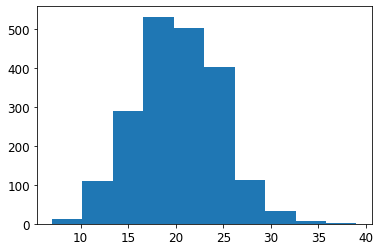

In [172]:
plt.hist(S_observed_exp)

In [173]:
print('Final results: for BP ' + str(bp+1) + '\n ')
print('Z = ' + str(np.sqrt(np.median(q0_exp))) + '; Z_std = ' + str(np.std(q0_exp) / (2 * np.sqrt(np.median(q0_exp)))))
print('B_exp = ' + str(np.mean(B_observed_exp)) + '; B_exp_std = ' + str(np.std(B_observed_exp)))
print('S_exp = ' + str(np.mean(S_observed_exp)) + '; S_exp_std = ' + str(np.std(S_observed_exp)))

Final results: for BP 7
 
Z = 0.5668971136169676; Z_std = 0.8981026392002711
B_exp = 4989.4085; B_exp_std = 56.35643377423735
S_exp = 20.0455; S_exp_std = 4.375206252281142


## BinnedLikelihood

In [149]:
print(pred_XG_SM.shape)
print(pred_XG_NP.shape)

(344224,)
(135960,)


In [150]:
B_expected = int(B_expected)

In [151]:
MIN_EVS = 5 # min number of background events that we allow per bin
range_dat = [[0,1]] # range of our data (between 0 and 1 if its the ML output)

bins_to_test=range(1,500) # number of bins we are testing to see if condition holds

# FIND THE NUMBER OF BINS:
num_bins = max_num_bins(pred_XG_SM, int(B_expected), range_dat, MIN_EVS, bins_to_test)

print('\n FOR BIN LIKELIHOOD WE ARE SETTING:')
print('min number of Background events allowed per bin: ', MIN_EVS)
print('number of bins we are going to use: ', num_bins)
print('range of our data: ', range_dat)

At least 5 B events per bin, range = [[0, 1]]:
# bins:  477 OK

 FOR BIN LIKELIHOOD WE ARE SETTING:
min number of Background events allowed per bin:  5
number of bins we are going to use:  477
range of our data:  [[0, 1]]


In [152]:
# Z Poisson Bin Likelihood (Asimov data set)
D_or_E = 'discovery'
store_Z_asimov = []

Z_asimov = Z_BL_asimov(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), 25, range_dat, MIN_EVS, linear_bins=True) 
store_Z_asimov.append( Z_asimov )
    
    
print('\n FINAL RESULT for BP' + str(bp+1) + ':\n')
print(store_Z_asimov)


 FINAL RESULT for BP7:

[1.1165085057908959]


B_expected:  121397
S_expected:  66.07734672000001

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


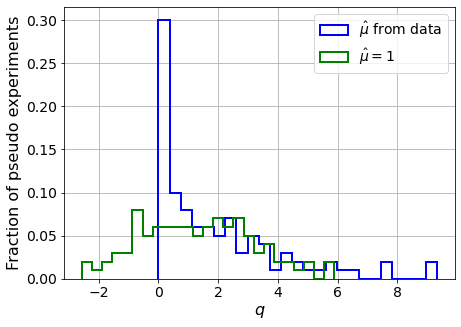

muhat mean:  1.017
Z_bins:  1.1431602901287212
std Z_bins:  0.9256336180824144
Z_bins mu=0:  1.1430476050028262
std Z_bins mu=0:  0.8147269645285783

--------


 FINAL RESULT:

[[1.1431602901287212, 0.9256336180824144, 1.017, 1.1430476050028262, 0.8147269645285783]]


In [153]:
# requested number of pseudo experiments
num_pseudo = 100

# OPTION 2 (mu_hat with more precision) (slower, not so bad for bin likelihood)
store_Z_BL = []

    
print('B_expected: ', B_expected)
print('S_expected: ', S_expected[bp])
print('')

#Z_BL = BL_test_fast(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), num_pseudo, 25, range_dat, MIN_EVS, linear_bins=True, path = '../graph/BP' + str(bp+1) + '/') 
Z_BL = BL_test_fast(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), num_pseudo, 25, range_dat, MIN_EVS, linear_bins=True) 

store_Z_BL.append( list(Z_BL) )

print('muhat mean: ', Z_BL[2])
print('Z_bins: ', Z_BL[0])
print('std Z_bins: ', Z_BL[1])
print('Z_bins mu=0: ', Z_BL[3])
print('std Z_bins mu=0: ', Z_BL[4])
print('')
print('--------\n')
    
    
    
print('\n FINAL RESULT:\n')
print(store_Z_BL)

B_expected:  121397
S_expected:  66.07734672000001

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


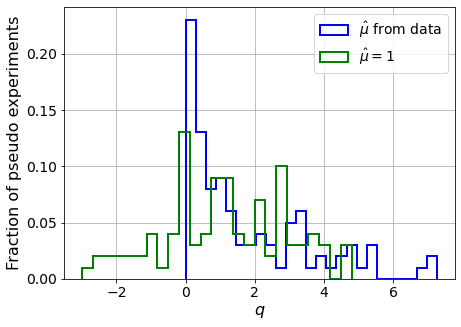

muhat mean:  0.9549118627155706
Z_bins:  1.0467574145988419
std Z_bins:  0.8606940770145759
Z_bins mu=0:  1.0443446538478138
std Z_bins mu=0:  0.8547378001940017

--------


 FINAL RESULT:

[[1.0467574145988419, 0.8606940770145759, 0.9549118627155706, 1.0443446538478138, 0.8547378001940017]]


In [154]:
# requested number of pseudo experiments
num_pseudo = 100

# OPTION 2 (mu_hat with more precision) (slower, not so bad for bin likelihood)
store_Z_BL = []

    
print('B_expected: ', B_expected)
print('S_expected: ', S_expected[bp])
print('')

#Z_BL = BL_test_fsolve(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), num_pseudo, 25, range_dat, MIN_EVS, linear_bins=True, path = '../graph/BP' + str(bp+1) + '/') 
Z_BL = BL_test_fsolve(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), num_pseudo, 25, range_dat, MIN_EVS, linear_bins=True) 

store_Z_BL.append( list(Z_BL) )

print('muhat mean: ', Z_BL[2])
print('Z_bins: ', Z_BL[0])
print('std Z_bins: ', Z_BL[1])
print('Z_bins mu=0: ', Z_BL[3])
print('std Z_bins mu=0: ', Z_BL[4])
print('')
print('--------\n')
    
    
    
print('\n FINAL RESULT:\n')
print(store_Z_BL)

## KDE

(array([0.04450251, 0.05403876, 0.10489875, 0.17165255, 0.18754631,
        0.18754631, 0.34966261, 0.58488983, 1.1348141 , 7.21258596]),
 array([0.003186  , 0.10286566, 0.20254532, 0.302225  , 0.40190464,
        0.5015843 , 0.60126394, 0.7009436 , 0.8006233 , 0.90030295,
        0.9999826 ], dtype=float32),
 [<matplotlib.patches.Polygon at 0x7f1af5a91a60>])

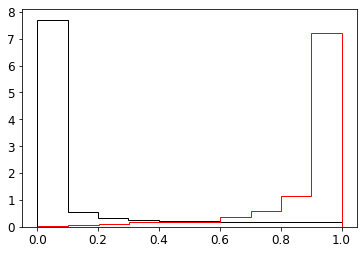

In [131]:
plt.hist(pred_XG_SM, histtype = 'step', color = 'black',density = True)
plt.hist(pred_XG_NP, histtype = 'step', color = 'red',density = True)

In [69]:
print(pred_XG_SM.shape)
print(pred_XG_NP.shape)

(324225,)
(3156,)


In [70]:
pred_XG_NP_aux = np.random.choice(pred_XG_NP, size = len(pred_XG_SM), replace = True)

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
 27735.86231659 26752.29302056 25611.05470044 24307.96249729
 22849.81326958 21224.51952095 19422.04855104 17446.43512815
 15308.70343448 12952.55080784 10379.13375836  7615.52732546
  4665.53042056  1533.78475602 -1695.83914524 -4949.62243899]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf  6826.72268981  6785.42334897


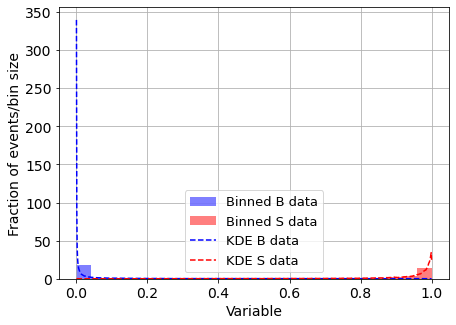

KDE Kernel:  epanechnikov
Background bandwidth:  0.0007122485584859914
Signal bandwidth:  0.0019008479046983867


In [52]:
# USE KDE TO ESTIMATE THE CLASSIFIER OUTPUT PDFs

# outputs:
# 1st -> background PDF
# 2nd -> signal PDF
# 3rd -> (normalization factor of the background PDF)**-1
# 4th -> (normalization factor of the signal PDF)**-1
# 5th -> background bandwidth
# 6th -> signal bandwidth
kde_bkg, kde_sig, norm_factor_SM, norm_factor_NP, B_bandwidth, S_bandwidth = KDE_fitter(pred_XG_SM, pred_XG_NP, 
                                                                                        50000, # Numero de datos para fitear
                                                                                        np.logspace(-4.0, 0.05, 20), 
                                                                                        set_kernel='epanechnikov')

In [53]:
# range (~between 0 and 1)
min_val = 0#np.min([np.min(pred_XG_SM),np.min(pred_XG_NP)])
max_val = 1#np.max([np.max(pred_XG_SM),np.max(pred_XG_NP)])

s_vals = np.linspace(min_val,max_val,10)



# evaluate the densities for each value of s (~bins)
dens_bkg = np.exp(kde_bkg.score_samples(np.c_[s_vals, np.zeros(len(s_vals)) ]) )
dens_sig = np.exp(kde_sig.score_samples(np.c_[s_vals, np.ones(len(s_vals)) ]) )



# Normalize to 1
# Area
factor_aux_SM = sum(dens_bkg*(s_vals[1]-s_vals[0]))
factor_aux_NP = sum(dens_sig*(s_vals[1]-s_vals[0]))

# normalize
dens_bkg = dens_bkg / norm_factor_SM
dens_sig = dens_sig / norm_factor_NP



# We can do a quick Z bin-loglikelihood calculation using the computed KDE
# this is to check the KDE here, because we use KDE to avoid binning


# in each ensemble we use B=50k
print('B_expected: ', int(B_expected))

# values of S / sqrt{B} to test
soversqrtB = [int(S_expected[bp]) / np.sqrt(B_expected)] #np.linspace(SsqrtB[0],SsqrtB[-1],100)



# Let's find out the expected number of B and S events in each bin:

# total number of B * B_pdf value in each bin * bin size
Bd = B_expected*dens_bkg*(s_vals[1]-s_vals[0])



# If a bins has no expected background events replace that zero for the minimum B_bin=/=0

# find the minimum
Bd_noceros = []
for i in range(len(Bd)):
    if Bd[i]!=0:
        Bd_noceros.append(Bd[i])

min_back = min(Bd_noceros)

# replace the zeros
for i in range(len(Bd)):
    if Bd[i]==0:
        Bd[i] = min_back




# Now calculate Z using the Binned Likelihood formula

Zvals = np.zeros(len(soversqrtB))

for nval, val in enumerate(soversqrtB):
    # S events in each bin:
    # value of S/sqrt{B} * sqrt{B} * S_pdf value in each bin * bin size
    Sd = val*np.sqrt(B_expected)*dens_sig*(s_vals[1]-s_vals[0])
   
    # Z value:
    Zvals[nval]= np.sqrt(2.0*np.sum(((Sd+Bd)*np.log(1.0+Sd/Bd)-Sd))) # Discovery
    #Zvals[nval]= np.sqrt(2.0*np.sum(Bd*np.log(Bd/(Sd+Bd))+Sd)) # Exclusion

B_expected:  121397


In [54]:
Zvals

array([44.23813226])

In [55]:
# FOR EXCLUSION:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

print('This may take a while...')

pB_B_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
print('1 done')
pS_B_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )
print('2 done')

# Normalize
pB_B_data = pB_B_data / norm_factor_SM
pS_B_data = pS_B_data / norm_factor_NP

This may take a while...
1 done
2 done


In [56]:
D_or_E = "discovery"
if D_or_E == "discovery":

    # FOR DISCOVERY:
    # we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

    pB_S_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_NP, np.zeros(len(pred_XG_NP)) ]) )
    print('3 done')
    pS_S_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ]) )
    print('4 done')

    # Normalize
    pB_S_data = pB_S_data / norm_factor_SM
    pS_S_data = pS_S_data / norm_factor_NP
    
else:
    # dummies
    pB_S_data = 1
    pS_S_data = 1

3 done
4 done


In [57]:
print(np.min(pB_B_data))
print(np.min(pB_S_data))
print(np.min(pS_S_data))
print(np.min(pS_B_data))

0.02120753148821159
0.0159119617006882
0.017762716460895802
0.0


In [58]:
print('MLL/KDE aproximated Z:')
print( MLL_aprox_discovery_KDE(pB_B_data, pS_B_data, pB_S_data, pS_S_data, int(B_expected), int(S_expected[bp])) )

MLL/KDE aproximated Z:
nan


/tmp/ipykernel_782804/1019789035.py:23: RuntimeWarning: invalid value encountered in double_scalars
  return (f0 + fB + fS)**0.5


In [59]:
pspb_B_data = np.mean(pS_B_data/pB_B_data)
pspb_S_data = np.mean(pS_S_data/pB_S_data)

f0 = -2 * S_expected[bp]
fB = 2 * B_expected * np.log( 1 + (pspb_B_data * S_expected[bp] / B_expected) )
fS = 2 * S_expected[bp] * np.log( 1 + (pspb_S_data * S_expected[bp] / B_expected) )

In [60]:
f0

-668.07399857

In [61]:
fB

666.7298593994695

In [62]:
fS

202.78351838775112

In [63]:
(f0 + fB + fS)

201.4393792172207

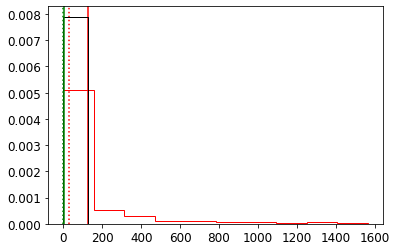

In [64]:
plt.hist(pS_S_data/pB_S_data, histtype = 'step', color = 'red', density = True)
plt.axvline(x = np.mean(pS_S_data/pB_S_data), color = 'red')
plt.axvline(x = np.median(pS_S_data/pB_S_data), color = 'red', ls = ':')

plt.hist(pS_B_data/pB_B_data, histtype = 'step', color = 'black', density = True)
plt.axvline(x = np.mean(pS_B_data/pB_B_data), color = 'green')
plt.axvline(x = np.median(pS_B_data/pB_B_data), color = 'green', ls = ':')

0.003762435475556333
29.444358148937173
0.999359560089379
128.884693752499


Text(0, 0.5, 'ML')

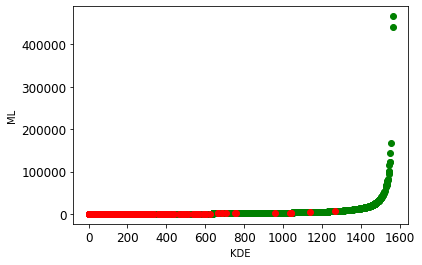

In [65]:
print( np.median([im / (1 - im) for im in pred_XG_SM]) )
print( np.median([im / (1 - im) for im in pred_XG_NP]) )
   
print( np.mean(pS_B_data/pB_B_data) )
print( np.mean(pS_S_data/pB_S_data) )

plt.scatter( (pS_S_data/pB_S_data), [im / (1 - im) for im in pred_XG_NP], color = 'green')
plt.scatter( (pS_B_data/pB_B_data), [im / (1 - im) for im in pred_XG_SM], color = 'red')
plt.xlabel('KDE')
plt.ylabel('ML')

B_expected:  121397
S_expected:  334



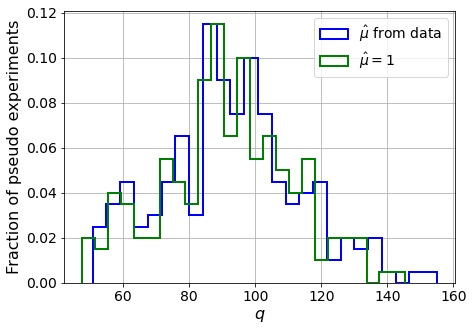

muhat mean:  1.09975
Z_MLL:  9.574783597472567
std Z_MLL:  1.085909584845715
Z_MLL mu=1:  9.566889822784669
std Z_MLL mu=1:  1.0342782488654625

--------


 FINAL RESULT:

[[9.574783597472567, 1.085909584845715, 1.09975, 9.566889822784669, 1.0342782488654625]]


In [66]:
# OPTION 1 (faster)
store_Z_MLL = []

    
print('B_expected: ', int(B_expected))
print('S_expected: ', int(S_expected[bp]))
print('')

Z_MLL = MLL_test_fast(D_or_E, pB_B_data, pS_B_data, pB_S_data, pS_S_data, B_expected, int(S_expected[bp]), num_pseudo = 200)
#Z_MLL = MLL_test_fsolve(D_or_E, pB_B_data, pS_B_data, pB_S_data, pS_S_data, B_expected, int(S_expected[bp]), num_pseudo, path = '../graph/BP' + str(bp+1) + '/')

store_Z_MLL.append( list(Z_MLL) )

print('muhat mean: ', Z_MLL[2])
print('Z_MLL: ', Z_MLL[0])
print('std Z_MLL: ', Z_MLL[1])
print('Z_MLL mu=1: ', Z_MLL[3])
print('std Z_MLL mu=1: ', Z_MLL[4])
print('')
print('--------\n')
    
    
print('\n FINAL RESULT:\n')
print(store_Z_MLL)

In [163]:
unnombre = 1200
otro = 2000
x = np.concatenate([ pS_B_data[unnombre:(unnombre + B_expected)], pS_S_data[otro:(otro+int(S_expected[bp]))] ])
y = np.concatenate([ pB_B_data[unnombre:(unnombre + B_expected)], pB_S_data[otro:(otro+int(S_expected[bp]))] ])

muhat = np.linspace(-1,2,100)
algo = []
for i in muhat:
    algo.append(  sum ( (x*1.) / ( (x * i * S_expected[bp]) + (y * B_expected) ) ))

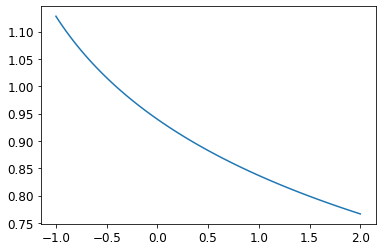

In [164]:
plt.plot(muhat, np.asarray(algo))

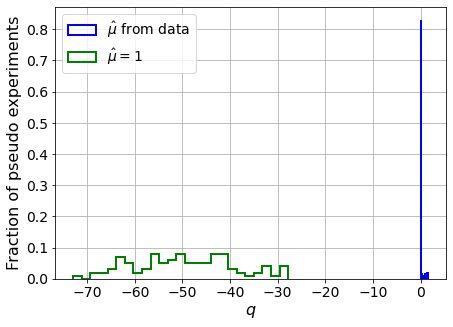

muhat mean:  -0.05918124613384672
Z_MLL:  0.0
std Z_MLL:  inf
Z_MLL mu=1:  7.066331911815719
std Z_MLL mu=1:  0.7389951880691812

--------



/home/martinrios/martin/trabajos/susyatLHC/codes/AUX_MLL_BL.py:1305: RuntimeWarning: divide by zero encountered in double_scalars
  Z_MLL_std = np.std(q_muhat_MLL) / (2.*Z_MLL)


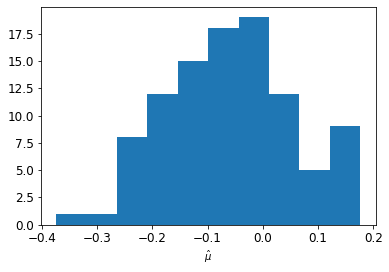

In [72]:
Z_MLL_fast = MLL_test_fsolve(D_or_E, pB_B_data, pS_B_data, pB_S_data, pS_S_data, B_expected, int(S_expected[bp]), num_pseudo, path = '../graph/BP' + str(bp+1) + '/')
print('muhat mean: ', Z_MLL_fast[2])
print('Z_MLL: ', Z_MLL_fast[0])
print('std Z_MLL: ', Z_MLL_fast[1])
print('Z_MLL mu=1: ', Z_MLL_fast[3])
print('std Z_MLL mu=1: ', Z_MLL_fast[4])
print('')
print('--------\n')

In [ ]:
print('muhat mean: ', Z_MLL_solved[2])
print('Z_MLL: ', Z_MLL_solved[0])
print('std Z_MLL: ', Z_MLL_solved[1])
print('Z_MLL mu=1: ', Z_MLL_solved[3])
print('std Z_MLL mu=1: ', Z_MLL_solved[4])
print('')
print('--------\n')


## Test ML

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf  8012.23396311  7798.1825559
  7515.86145348  7166.59687316  6738.83122822  6222.86164508
  5605.9025212   4862.61728431  3939.66271443  2799.96258215
  1404.17421012  -290.08406303 -2333.92184111 -5157.64683925]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf  7387.75642585  7300.0655172   7133.57768767
 

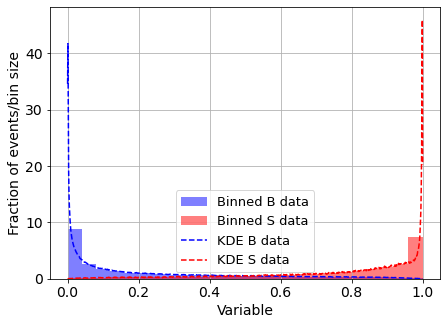

KDE Kernel:  epanechnikov
Background bandwidth:  0.0019008479046983867
Signal bandwidth:  0.0011635618505359071


In [155]:
# USE KDE TO ESTIMATE THE CLASSIFIER OUTPUT PDFs

# outputs:
# 1st -> background PDF
# 2nd -> signal PDF
# 3rd -> (normalization factor of the background PDF)**-1
# 4th -> (normalization factor of the signal PDF)**-1
# 5th -> background bandwidth
# 6th -> signal bandwidth
kde_bkg, kde_sig, norm_factor_SM, norm_factor_NP, B_bandwidth, S_bandwidth = KDE_fitter(pred_XG_SM, pred_XG_NP, 
                                                                                        50000, # Numero de datos para fitear
                                                                                        np.logspace(-4.0, 0.05, 20), 
                                                                                        set_kernel='epanechnikov')

In [156]:
print(norm_factor_SM)
print(norm_factor_NP)

439.8512593146135
729.5002712170974


In [157]:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

print('This may take a while...')

pB_B_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
print('1 done')
pS_B_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )
print('2 done')

# Normalize
pB_B_data = pB_B_data / norm_factor_SM
pS_B_data = pS_B_data / norm_factor_NP

This may take a while...
1 done
2 done


In [158]:
# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

pB_S_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_NP, np.zeros(len(pred_XG_NP)) ]) )
print('3 done')
pS_S_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ]) )
print('4 done')

# Normalize
pB_S_data = pB_S_data / norm_factor_SM
pS_S_data = pS_S_data / norm_factor_NP
   

3 done
4 done


(array([107244.,   6441.,   3395.,   2163.,   1779.,   1784.,   2039.,
          2402.,   2825.,   5888.]),
 array([7.54585547e-03, 4.64851862e+00, 9.28949138e+00, 1.39304641e+01,
        1.85714369e+01, 2.32124097e+01, 2.78533824e+01, 3.24943552e+01,
        3.71353279e+01, 4.17763007e+01, 4.64172735e+01]),
 [<matplotlib.patches.Polygon at 0x7f920c619040>])

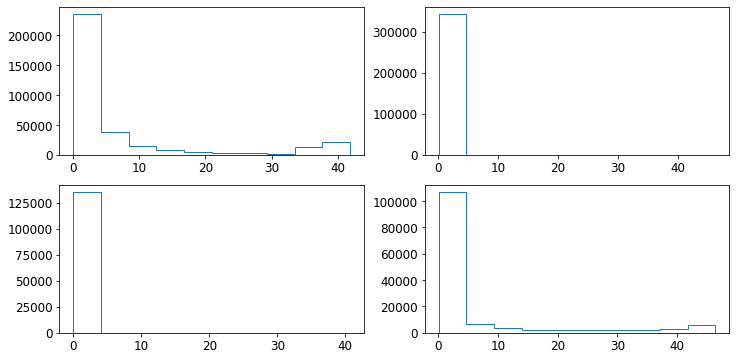

In [159]:
fig,ax = plt.subplots(2,2, figsize = (12,6))

ax[0,0].hist(pB_B_data, histtype = 'step')
ax[0,1].hist(pS_B_data, histtype = 'step')

ax[1,0].hist(pB_S_data, histtype = 'step')
ax[1,1].hist(pS_S_data, histtype = 'step')

In [160]:
# indeces (to later build a random pseudo experiment)
indices_B = [i for i in range(len(pS_B_data))]
indices_S = [i for i in range(len(pS_S_data))]
        
        

In [161]:
muhat_selected_MLL_list = []
q_muhat_MLL = []
q_muhat_MLL_mu = []

# loop over the number of pseudo experiments
#np.random.seed(91218)
for its in tqdm(range(2000)):

    # this pseudo-exp has B_rand number of B events
    B_rand = np.random.poisson(int(B_expected))

    ran_ind = np.random.choice(indices_B, B_rand)

    pB_B_data_shuf = []
    pS_B_data_shuf = []

    # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
    for i in ran_ind:
        pB_B_data_shuf.append(pB_B_data[i])
        pS_B_data_shuf.append(pS_B_data[i])

    pB_B_data_shuf  = np.array(pB_B_data_shuf)
    pS_B_data_shuf  = np.array(pS_B_data_shuf)



    # this pseudo-exp has S_rand number of S events
    S_rand = np.random.poisson(int(S_expected[bp]))

    ran_ind = np.random.choice(indices_S, S_rand)

    pB_S_data_shuf = []
    pS_S_data_shuf = []

    # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
    for i in ran_ind:
        pB_S_data_shuf.append(pB_S_data[i])
        pS_S_data_shuf.append(pS_S_data[i])

    pB_S_data_shuf  = np.array(pB_S_data_shuf)
    pS_S_data_shuf  = np.array(pS_S_data_shuf)
    
    # p_b(o(x_ensemble)) =  concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble)) 
    prob_x_given_B = np.concatenate([pB_B_data_shuf,pB_S_data_shuf])

    # p_s(o(x_ensemble)) =  concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble)) 
    prob_x_given_S = np.concatenate([pS_B_data_shuf,pS_S_data_shuf])



    # NOW WE HAVE p_{s,b}(x_ensemble) for this particular pseudo_experiment

    # approximation: mu_hat=1 (discovery)
    q_muhat_MLL_mu.append( 2 * ( ( -1. * int(S_expected[bp])) + sum( [np.log( 1 + ( (1.*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )



    # ESTIMATE mu_hat for this particular ensemble (implicit equation)
    B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

    # reference points
    sum_muhat_zero = sum ( [(x*1.) / ( (x * (0) * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
    sum_muhat_two = sum ( [(x*1.) / ( (x * 2. * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )


    # we need (implicit eq. for mu_hat) = 1
    # conditions considering the reference points
    if (sum_muhat_zero < sum_muhat_two < 1) or (1 < sum_muhat_two < sum_muhat_zero):
        print('muhat = 2.1')
        muhat_selected_MLL = 2.1

        print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
        print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
        print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
        print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

    elif (sum_muhat_two < sum_muhat_zero < 1) or (1 < sum_muhat_zero < sum_muhat_two):
        print('muhat = -0.1')
        muhat_selected_MLL = -0.1

        print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
        print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
        print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
        print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

    elif sum_muhat_zero < 1 < sum_muhat_two:
        #print('muhat ~ 1')

        # grid, mu_hat is around 1
        muhat_test = np.arange(0, 2., 0.05)

        for vv in range(len(muhat_test)):

            mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

            if mu_hat_condition_equal_1 > 1:
                muhat_selected_MLL = muhat_test[vv]
                break

    elif sum_muhat_two < 1 < sum_muhat_zero:
        #print('muhat ~ 1')

        # grid, mu_hat is around 1
        muhat_test = np.arange(0, 2., 0.05)

        for vv in range(len(muhat_test)):

            mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

            if mu_hat_condition_equal_1 < 1:
                muhat_selected_MLL = muhat_test[vv]
                break


    # save the computed mu_hat (within range) for each pseudo_experiment
    muhat_selected_MLL_list.append(muhat_selected_MLL)


    # compute the test statistic for each pseudo_exp considering mu_hat
    if muhat_selected_MLL > 0:
        q_muhat_MLL.append( 2 * ( (-1.*muhat_selected_MLL * int(S_expected[bp])) + sum( [np.log( 1 + ( (muhat_selected_MLL*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )

    else:
        q_muhat_MLL.append( 0 )

  0%|                                  | 2/2000 [00:02<33:04,  1.01it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.31408118060194906
<p_{s}(Sdata)> = 10.78230657019025
<p_{b}(Bdata)> = 7.080695913708643
<p_{s}(Bdata)> = 0.3318764819872362


  1%|▎                                | 16/2000 [00:28<50:38,  1.53s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3837470077676444
<p_{s}(Sdata)> = 4.360533291734825
<p_{b}(Bdata)> = 7.145267804357636
<p_{s}(Bdata)> = 0.32746096699802135


  2%|▋                                | 42/2000 [01:07<37:02,  1.13s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4127959141784368
<p_{s}(Sdata)> = 4.576030176615738
<p_{b}(Bdata)> = 7.126395178364072
<p_{s}(Bdata)> = 0.32926855728706705


  4%|█▎                               | 80/2000 [02:05<34:25,  1.08s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.31293570408290566
<p_{s}(Sdata)> = 8.325948892908025
<p_{b}(Bdata)> = 7.146984428533834
<p_{s}(Bdata)> = 0.33203047381940615


  6%|█▊                              | 112/2000 [02:53<36:59,  1.18s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3185713139966634
<p_{s}(Sdata)> = 4.560861025264874
<p_{b}(Bdata)> = 7.128092871573471
<p_{s}(Bdata)> = 0.32705803132572947


  6%|█▊                              | 116/2000 [02:57<30:54,  1.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29342075043164967
<p_{s}(Sdata)> = 2.768891395458035
<p_{b}(Bdata)> = 7.177701897712213
<p_{s}(Bdata)> = 0.3282051239045324


  9%|██▊                             | 178/2000 [04:28<31:36,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.36013053356411645
<p_{s}(Sdata)> = 3.338514553340874
<p_{b}(Bdata)> = 7.162169614256619
<p_{s}(Bdata)> = 0.32849924282291326


  9%|██▉                             | 187/2000 [04:38<27:33,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33061822462789836
<p_{s}(Sdata)> = 3.9700393560215597
<p_{b}(Bdata)> = 7.144432828836566
<p_{s}(Bdata)> = 0.32995985898325125


  9%|███                             | 188/2000 [04:39<23:48,  1.27it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.29453153020791845
<p_{s}(Sdata)> = 8.918887844263224
<p_{b}(Bdata)> = 7.137757923137215
<p_{s}(Bdata)> = 0.3309222738979881


 10%|███▎                            | 209/2000 [05:08<26:34,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.379313226547783
<p_{s}(Sdata)> = 4.945843418599091
<p_{b}(Bdata)> = 7.126748894145839
<p_{s}(Bdata)> = 0.32481292344777973


 11%|███▌                            | 221/2000 [05:24<30:52,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.447627590035458
<p_{s}(Sdata)> = 3.139826311094619
<p_{b}(Bdata)> = 7.126915447399928
<p_{s}(Bdata)> = 0.3282268688047886


 13%|████▏                           | 263/2000 [06:29<38:18,  1.32s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4233038598603509
<p_{s}(Sdata)> = 2.6963253388371533
<p_{b}(Bdata)> = 7.116262369629387
<p_{s}(Bdata)> = 0.3295046705950457


 14%|████▍                           | 281/2000 [06:52<31:38,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.30177728836748813
<p_{s}(Sdata)> = 4.767847673913453
<p_{b}(Bdata)> = 7.1204234029099265
<p_{s}(Bdata)> = 0.32745481632483425


 16%|█████                           | 317/2000 [07:46<28:20,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3899971720963288
<p_{s}(Sdata)> = 4.915584628487253
<p_{b}(Bdata)> = 7.172624391057235
<p_{s}(Bdata)> = 0.3296986951181843


 17%|█████▎                          | 333/2000 [08:08<30:08,  1.08s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2682537415998963
<p_{s}(Sdata)> = 7.039124496199624
<p_{b}(Bdata)> = 7.160299781456691
<p_{s}(Bdata)> = 0.3318132135646134


 17%|█████▍                          | 336/2000 [08:12<33:39,  1.21s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.36277852715336484
<p_{s}(Sdata)> = 4.4491489062264575
<p_{b}(Bdata)> = 7.103891263198426
<p_{s}(Bdata)> = 0.3268153589688869


 17%|█████▌                          | 346/2000 [08:25<26:55,  1.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31253358915397056
<p_{s}(Sdata)> = 5.252947034785915
<p_{b}(Bdata)> = 7.144897644021775
<p_{s}(Bdata)> = 0.32717585987981024


 19%|██████▏                         | 384/2000 [09:21<31:00,  1.15s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3232903148724432
<p_{s}(Sdata)> = 4.933837151247783
<p_{b}(Bdata)> = 7.153856397811397
<p_{s}(Bdata)> = 0.3266327405193841


 20%|██████▎                         | 392/2000 [09:32<29:29,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.36951265467469235
<p_{s}(Sdata)> = 2.5303801682994953
<p_{b}(Bdata)> = 7.145379262344987
<p_{s}(Bdata)> = 0.33083346278016335


 24%|███████▌                        | 471/2000 [11:43<27:22,  1.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3677498717928835
<p_{s}(Sdata)> = 4.6778478103418175
<p_{b}(Bdata)> = 7.161820237904088
<p_{s}(Bdata)> = 0.3272032025346844


 29%|█████████▎                      | 584/2000 [14:36<25:37,  1.09s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3250774939238155
<p_{s}(Sdata)> = 5.984164343892872
<p_{b}(Bdata)> = 7.101238107878206
<p_{s}(Bdata)> = 0.3274028965381161


 29%|█████████▍                      | 587/2000 [14:39<25:40,  1.09s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.3013992090897092
<p_{s}(Sdata)> = 8.71870820227957
<p_{b}(Bdata)> = 7.179381849523653
<p_{s}(Bdata)> = 0.3332471086661441


 30%|█████████▌                      | 600/2000 [14:57<23:09,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4334295919349435
<p_{s}(Sdata)> = 4.152508457268389
<p_{b}(Bdata)> = 7.04246439836516
<p_{s}(Bdata)> = 0.33094562549889683


 32%|██████████▎                     | 648/2000 [16:11<28:18,  1.26s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.39270334426892317
<p_{s}(Sdata)> = 4.288330948181147
<p_{b}(Bdata)> = 7.154721431597064
<p_{s}(Bdata)> = 0.325087423313186


 33%|██████████▋                     | 667/2000 [16:40<26:59,  1.22s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.29303698407073453
<p_{s}(Sdata)> = 8.895700605975959
<p_{b}(Bdata)> = 7.168216719679964
<p_{s}(Bdata)> = 0.33254199660832084


 34%|██████████▉                     | 687/2000 [17:06<21:07,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3122958872411226
<p_{s}(Sdata)> = 6.89548522823168
<p_{b}(Bdata)> = 7.117094733032723
<p_{s}(Bdata)> = 0.32788292860546253


 35%|███████████▎                    | 708/2000 [17:38<25:43,  1.19s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.5735137738193551
<p_{s}(Sdata)> = 4.346091393425484
<p_{b}(Bdata)> = 7.138309829335953
<p_{s}(Bdata)> = 0.32673161312227883


 37%|███████████▉                    | 743/2000 [18:28<28:13,  1.35s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.40187946243633466
<p_{s}(Sdata)> = 4.905866143423169
<p_{b}(Bdata)> = 7.124490768576454
<p_{s}(Bdata)> = 0.3264187441668646


 39%|████████████▍                   | 779/2000 [19:20<22:32,  1.11s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.27202185583519434
<p_{s}(Sdata)> = 12.867338074659616
<p_{b}(Bdata)> = 7.11221434458919
<p_{s}(Bdata)> = 0.32883924313832397


 41%|█████████████                   | 817/2000 [20:20<21:07,  1.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.340878893931007
<p_{s}(Sdata)> = 3.7148754380623146
<p_{b}(Bdata)> = 7.136279343491962
<p_{s}(Bdata)> = 0.3301694651925428


 41%|█████████████▎                  | 829/2000 [20:37<23:52,  1.22s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.32790965849959264
<p_{s}(Sdata)> = 3.9547579611331436
<p_{b}(Bdata)> = 7.127620036213172
<p_{s}(Bdata)> = 0.32795555299828155


 42%|█████████████▎                  | 835/2000 [20:46<24:43,  1.27s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2541354134993059
<p_{s}(Sdata)> = 10.750557460961527
<p_{b}(Bdata)> = 7.1499214976493795
<p_{s}(Bdata)> = 0.3323679949674278


 43%|█████████████▊                  | 861/2000 [21:24<23:44,  1.25s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3327366517966724
<p_{s}(Sdata)> = 2.688835309301385
<p_{b}(Bdata)> = 7.168933308345212
<p_{s}(Bdata)> = 0.32948919188562953


 44%|██████████████                  | 882/2000 [21:54<23:22,  1.25s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2876198626649598
<p_{s}(Sdata)> = 3.5804569588641875
<p_{b}(Bdata)> = 7.136883333651594
<p_{s}(Bdata)> = 0.3288398420322826


 45%|██████████████▍                 | 902/2000 [22:25<21:35,  1.18s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2828203157332802
<p_{s}(Sdata)> = 5.476442783528015
<p_{b}(Bdata)> = 7.155739488377988
<p_{s}(Bdata)> = 0.3273529360572414


 46%|██████████████▋                 | 918/2000 [22:56<37:31,  2.08s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.29090689024133987
<p_{s}(Sdata)> = 6.567370726581363
<p_{b}(Bdata)> = 7.080220000333414
<p_{s}(Bdata)> = 0.3341704592171849


 47%|██████████████▉                 | 933/2000 [23:30<32:35,  1.83s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.32765128481074773
<p_{s}(Sdata)> = 5.065158472080501
<p_{b}(Bdata)> = 7.196791206921568
<p_{s}(Bdata)> = 0.3278525297909261


 47%|███████████████                 | 943/2000 [23:53<32:02,  1.82s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3187476682189538
<p_{s}(Sdata)> = 6.198582862749888
<p_{b}(Bdata)> = 7.1256313813794065
<p_{s}(Bdata)> = 0.3272750992171789


 48%|███████████████▍                | 965/2000 [24:48<34:30,  2.00s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3468455664567975
<p_{s}(Sdata)> = 5.6900716248976275
<p_{b}(Bdata)> = 7.150807315441808
<p_{s}(Bdata)> = 0.326697334973071


 49%|███████████████▌                | 976/2000 [25:17<44:15,  2.59s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2909122991619378
<p_{s}(Sdata)> = 11.671385229869507
<p_{b}(Bdata)> = 7.1022551667380585
<p_{s}(Bdata)> = 0.3318532012088445


 49%|███████████████▋                | 982/2000 [25:31<35:00,  2.06s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.6757625285101879
<p_{s}(Sdata)> = 3.576513718602689
<p_{b}(Bdata)> = 7.112256128982582
<p_{s}(Bdata)> = 0.32859264454901627


 51%|███████████████▊               | 1023/2000 [27:13<35:20,  2.17s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.27904452191263585
<p_{s}(Sdata)> = 9.886908213801677
<p_{b}(Bdata)> = 7.168646436173642
<p_{s}(Bdata)> = 0.33066524022009613


 52%|████████████████▏              | 1042/2000 [28:01<33:11,  2.08s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3444981957226318
<p_{s}(Sdata)> = 4.380994793615573
<p_{b}(Bdata)> = 7.162493725033562
<p_{s}(Bdata)> = 0.32897754923646494


 54%|████████████████▌              | 1070/2000 [29:11<33:06,  2.14s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2684380310263515
<p_{s}(Sdata)> = 4.877293161584681
<p_{b}(Bdata)> = 7.094994699795328
<p_{s}(Bdata)> = 0.32894117981783655


 54%|████████████████▋              | 1073/2000 [29:16<28:34,  1.85s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.34279146753655665
<p_{s}(Sdata)> = 5.148924879776526
<p_{b}(Bdata)> = 7.143810250216007
<p_{s}(Bdata)> = 0.3272342467273883


 54%|████████████████▊              | 1086/2000 [29:48<29:37,  1.94s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.34727419964975936
<p_{s}(Sdata)> = 3.2480723037715302
<p_{b}(Bdata)> = 7.170331121891347
<p_{s}(Bdata)> = 0.32878325583954177


 58%|██████████████████             | 1163/2000 [31:50<15:01,  1.08s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.2704401325937817
<p_{s}(Sdata)> = 5.325619343912026
<p_{b}(Bdata)> = 7.1888202208135805
<p_{s}(Bdata)> = 0.325755011892606


 59%|██████████████████▍            | 1187/2000 [32:26<16:25,  1.21s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.28395124617376755
<p_{s}(Sdata)> = 4.5544543062946925
<p_{b}(Bdata)> = 7.169471662654877
<p_{s}(Bdata)> = 0.3285393573051823


 60%|██████████████████▌            | 1201/2000 [32:42<13:54,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.32172521359517
<p_{s}(Sdata)> = 3.795848740042963
<p_{b}(Bdata)> = 7.098235942695279
<p_{s}(Bdata)> = 0.328320096823152


 61%|██████████████████▉            | 1219/2000 [33:05<10:40,  1.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4244974733919635
<p_{s}(Sdata)> = 5.246635525701761
<p_{b}(Bdata)> = 7.1162647475327985
<p_{s}(Bdata)> = 0.3277920411498331


 63%|███████████████████▍           | 1257/2000 [33:58<15:00,  1.21s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3618194634034111
<p_{s}(Sdata)> = 3.5914107535516733
<p_{b}(Bdata)> = 7.1191565875070655
<p_{s}(Bdata)> = 0.32877015540186927


 64%|███████████████████▋           | 1274/2000 [34:20<12:28,  1.03s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.46822900936627626
<p_{s}(Sdata)> = 3.6412328347871172
<p_{b}(Bdata)> = 7.159063411410254
<p_{s}(Bdata)> = 0.3285753902441615


 68%|█████████████████████▏         | 1367/2000 [36:31<11:24,  1.08s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3112389626409633
<p_{s}(Sdata)> = 3.7259519020792164
<p_{b}(Bdata)> = 7.1446647594441135
<p_{s}(Bdata)> = 0.32939570148464536


 71%|█████████████████████▉         | 1414/2000 [37:43<11:18,  1.16s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4079486597878785
<p_{s}(Sdata)> = 5.023494089820411
<p_{b}(Bdata)> = 7.116454727257377
<p_{s}(Bdata)> = 0.327545322150604


 74%|███████████████████████        | 1488/2000 [39:29<08:20,  1.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35287202315856986
<p_{s}(Sdata)> = 4.476232884549685
<p_{b}(Bdata)> = 7.123236031379028
<p_{s}(Bdata)> = 0.3270468064191467


 75%|███████████████████████▎       | 1502/2000 [39:48<09:26,  1.14s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.23255621486946607
<p_{s}(Sdata)> = 9.011720195279612
<p_{b}(Bdata)> = 7.058096722474604
<p_{s}(Bdata)> = 0.33238032507415805


 81%|█████████████████████████      | 1618/2000 [42:31<07:50,  1.23s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.3209327800872507
<p_{s}(Sdata)> = 7.990316800668656
<p_{b}(Bdata)> = 7.084609211192859
<p_{s}(Bdata)> = 0.33257750098461963


 90%|███████████████████████████▉   | 1805/2000 [47:01<03:30,  1.08s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3855453624618646
<p_{s}(Sdata)> = 2.7184617446142445
<p_{b}(Bdata)> = 7.089885294339217
<p_{s}(Bdata)> = 0.3287975190006553


 92%|████████████████████████████▌  | 1843/2000 [47:55<03:22,  1.29s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3459623992225793
<p_{s}(Sdata)> = 3.6625224142846484
<p_{b}(Bdata)> = 7.122835200431634
<p_{s}(Bdata)> = 0.32711957536661346


 95%|█████████████████████████████▍ | 1896/2000 [49:12<02:28,  1.43s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.25592327099681395
<p_{s}(Sdata)> = 10.675615970064024
<p_{b}(Bdata)> = 7.050119448723855
<p_{s}(Bdata)> = 0.3328929279317417


 95%|█████████████████████████████▌ | 1909/2000 [49:29<01:33,  1.03s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4683192904951658
<p_{s}(Sdata)> = 4.870963911187801
<p_{b}(Bdata)> = 7.144591392003223
<p_{s}(Bdata)> = 0.328796072388011


 98%|██████████████████████████████▏| 1950/2000 [50:29<00:53,  1.06s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3061874089187901
<p_{s}(Sdata)> = 4.391444201491932
<p_{b}(Bdata)> = 7.170210104970814
<p_{s}(Bdata)> = 0.32861295839882937


 98%|██████████████████████████████▍| 1965/2000 [50:53<00:41,  1.17s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.34232536718300366
<p_{s}(Sdata)> = 4.547004717595118
<p_{b}(Bdata)> = 7.139146995822705
<p_{s}(Bdata)> = 0.3263872026533854


100%|███████████████████████████████| 2000/2000 [51:45<00:00,  1.55s/it]


Text(0, 0.5, 'condicion')

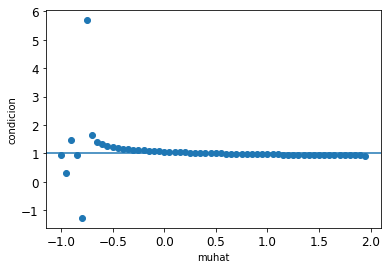

In [162]:
muhat_test = np.arange(-1, 2., 0.05)
result = []
for i in muhat_test:
    result.append( sum ( [(x*1.) / ( (x * i * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] ) )
result = np.asarray(result)
plt.scatter(muhat_test, result)
plt.axhline(y = 1)
plt.xlabel('muhat')
plt.ylabel('condicion')

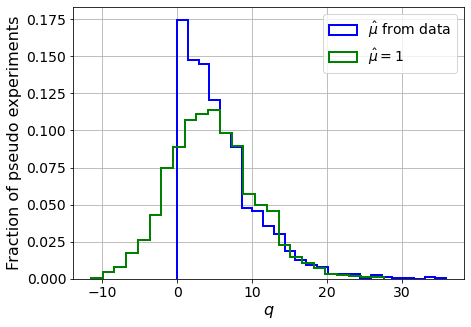

2.1583982726498068 1.1784110556386485 0.81615 2.0950450760594883 1.355643832490581


In [163]:
# Histogram of q_muhats
plt.figure(figsize=(7,5))

weights = np.ones_like(q_muhat_MLL)/float(len(q_muhat_MLL))
plt.hist(q_muhat_MLL, 25, weights=weights, histtype='step', color='blue', linewidth=2, label=r'$\hat{\mu}$ from data')

weights = np.ones_like(q_muhat_MLL_mu)/float(len(q_muhat_MLL_mu))
plt.hist(q_muhat_MLL_mu, 25, weights=weights, histtype='step', color='green', linewidth=2, label=r'$\hat{\mu}=1$')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q$",fontsize=16)
plt.ylabel("Fraction of pseudo experiments",fontsize=16)
plt.grid()
plt.legend(fontsize=14)
plt.show()



# With the calculation of mu_hat
muhat_mean_MLL = np.mean(muhat_selected_MLL_list)

Z_MLL = abs( np.median(q_muhat_MLL) )**0.5
Z_MLL_std = np.std(q_muhat_MLL) / (2.*Z_MLL)


# With the approximation of mu_hat
Z_MLL_mu = abs( np.median(q_muhat_MLL_mu) )**0.5
Z_MLL_std_mu = np.std(q_muhat_MLL_mu) / (2.*Z_MLL_mu)


print( Z_MLL, Z_MLL_std, muhat_mean_MLL, Z_MLL_mu, Z_MLL_std_mu)

## Working points (old)

In [88]:
# Working point
treshold = np.linspace(0.6, 1, 11)

Sexp = []
Bexp = []
for ith, th in enumerate(treshold):
    signalok = len(np.where( y_pred_xg[np.where(bkg_flag_val == 0)[0]] > th)[0])
    backok   = len(np.where( y_pred_xg[np.where(bkg_flag_val != 0)[0]] > th)[0])

    frac_sig = signalok / len(pred_XG_NP)
    frac_bkg = backok / len(pred_XG_SM)

    Sexp.append(S_expected[bp] * frac_sig)
    Bexp.append(B_expected * frac_bkg)

    #print('treshold: ', th)
    #print('Sexp: ', Sexp[ith])
    #print('Bexp: ', Bexp[ith])
    #print('SsqrtB: ', Sexp[ith] / np.sqrt(Bexp[ith]))
    #print('Sig stat full: ', ( 2.* ( (Sexp[ith] + Bexp[ith]) * np.log(1 + (Sexp/[ith]Bexp[ith]) ) - Sexp[ith] ) )**0.5 )
Sexp = np.asarray(Sexp)
Bexp = np.asarray(Bexp)

SsqrtB = Sexp / np.sqrt(Bexp)
Sig_full = ( 2.* ( (Sexp + Bexp) * np.log(1 + (Sexp/Bexp) ) - Sexp ) )**0.5 

/tmp/ipykernel_427342/1077839631.py:24: RuntimeWarning: invalid value encountered in true_divide
  SsqrtB = Sexp / np.sqrt(Bexp)
/tmp/ipykernel_427342/1077839631.py:25: RuntimeWarning: invalid value encountered in true_divide
  Sig_full = ( 2.* ( (Sexp + Bexp) * np.log(1 + (Sexp/Bexp) ) - Sexp ) )**0.5


## Binned likelihood (super experiment)  (old)

In [ ]:
##############
# PARAMETERS #
##############

# requested number of ensembles
n_ensembles = 5000


## LQ up 1400 GeV:
#S_expected = 7 # 6.6095293118432

# ratio S_expected/B_expected (signal ratio)
#SB_ratio = [0.0006, 0.001, 0.0016, 0.0025, 0.005, 0.0075, 0.01, 0.025]

# SOME USEFUL DERIVATED PARAMETERS:

# S/\sqrt{B}
SB_ratio = S_expected[bp]/(1.*B_expected) 
# S/\sqrt{B}
SsqrtB = S_expected[bp]/(B_expected)**0.5

In [ ]:
# Les't use an integer number of possible ensembles
N_ensembles_back = len(pred_XG_SM) / B_expected
N_events_back = N_ensembles_back * B_expected

N_ensembles_sig = len(pred_XG_NP) / S_expected[bp]
N_events_sig = N_ensembles_sig * S_expected[bp]
    
bins = np.linspace(10, 25, 15).astype('int')
Z_bins = np.zeros(len(bins))

for ib, nbin in enumerate(bins):
    # bin the parameter space of all background events
    hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(nbin), range = [[0, 1]])
    # now divide by the number of possible ensembles
    back_prom = hist_back.T.ravel()/N_ensembles_back

    # same for signal
    hist_sig, _ = np.histogramdd([pred_XG_NP], bins=binedges_back, range = [[0, 1]])
    sig_prom = hist_sig.T.ravel()/N_ensembles_sig        

    if np.min(back_prom) > 5:
        # then the signif Z^binned-Asimov:
        Z_bins[ib] = ( 2* sum( ( (back_prom + sig_prom) * np.log( 1 + (sig_prom / back_prom) ) ) - sig_prom ) )**0.5

In [ ]:
N_ensembles_sig

In [ ]:
N_ensembles_back

In [ ]:
fig,ax = plt.subplots(1,1)

ax2 = ax.twiny()

ax.plot(bins[np.where(Z_bins>0)[0]], Z_bins[np.where(Z_bins>0)[0]], color = 'coral', linewidth =2, label = '# Bins')
ax.set_xlabel('Nbins', fontsize=14)
ax.set_ylabel('Z', fontsize=14)
ax.legend(frameon = False, loc = 'upper left', bbox_to_anchor = (0.02,0.9))

ax2.plot(treshold, Sig_full, color = 'darkcyan', linewidth = 2, ls = '--', label = 'WP')
ax2.set_xlabel('Working Point', fontsize=14)
ax2.legend(frameon = False, loc = 'upper left', bbox_to_anchor = (0.02,0.8))

ax.text(0.05, 0.9, 'BP' + str(bp + 1), fontsize=14, transform = ax.transAxes)

plt.savefig('../graph/Z_WP+Bins_BP' + str(bp + 1) + '_All.png', bbox_inches='tight')

## Binned likelihood (pseudo experiments)  (old)

In [ ]:
ntrials = 5000 # number of iterations, to search the optimal binning

MIN_EVS = 5 # minimum number of events per bin

n_ensembles = 5000 # number of pseudo experiments to compute Z

In [ ]:
plt.hist(pred_XG_NP,density = True)
for i in range(20):
    pred_NP_aux = np.random.choice(pred_XG_NP, size = np.random.poisson(int(S_expected[bp])), replace = True)
    plt.hist(pred_NP_aux, histtype = 'step', color = 'black',density = True)

In [ ]:
plt.hist(pred_XG_SM)
for i in range(20):
    pred_SM_aux = np.random.choice(pred_XG_SM, size = np.random.poisson(int(B_expected)), replace = True)
    plt.hist(pred_SM_aux, histtype = 'step', color = 'black')

In [ ]:
print(' NUMBER OF BINS')

divs_B = int(len(pred_XG_SM) / B_expected)

B_1 = []
B_2 = []
B_3 = []

for it in range(divs_B):
    pred_SM_aux = np.random.choice(pred_XG_SM, size = np.random.poisson(int(B_expected)), replace = True)
    pred_NP_aux = np.random.choice(pred_XG_NP, size = np.random.poisson(int(S_expected[bp])), replace = False)
    
    datB_grid_SM = pred_SM_aux
    datB_grid_NP = pred_NP_aux

    B_hist1 = np.histogram_bin_edges(datB_grid_SM, bins = 'fd')
    B_hist2 = np.histogram_bin_edges(datB_grid_SM, bins = 'doane')
    B_hist3 = np.histogram_bin_edges(datB_grid_SM, bins = 'sturges')
    
    B_1.append(len(B_hist1))
    B_2.append(len(B_hist2))
    B_3.append(len(B_hist3))



B_1_mean = int(np.mean(B_1))
B_2_mean = int(np.mean(B_2))
B_3_mean = int(np.mean(B_3))


B_hist1 = plt.hist(datB_grid_SM, bins = B_1_mean, histtype = 'step', label = 'fd')
B_hist2 = plt.hist(datB_grid_SM, bins = B_2_mean, histtype = 'step', label = 'doane')
B_hist3 = plt.hist(datB_grid_SM, bins = B_3_mean, histtype = 'step', label = 'sturges')
plt.legend()
plt.show()


print('fd', B_1_mean)
print('doane', B_2_mean)
print('sturges', B_3_mean)
print(' ')


# SAVE THE OPTIMAL BIN NUMBER
B_bins_mean = [B_1_mean, B_2_mean, B_3_mean]

In [ ]:
mu = np.random.normal(0, np.sqrt(B_expected))

In [ ]:
mu

In [ ]:
# Tratemos de calcular f(q0|u=0)
#  Es decir la distribucion del estadistico q0 para
#  pseud-experimentos con solo background

B_bins_mean = np.linspace(10, 25, 15).astype('int')#[10,20,30,40,50,60,70,100]

num_pseudo_exp = 1000
q0_bins = []
for j_it in tqdm(range(len(B_bins_mean))):
    
    hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(B_bins_mean[j_it]), range = [[0,1]])
    back_prom = hist_back.T.ravel() / (len(pred_XG_SM) / B_expected)
    q0 = []
    for kk in range(num_pseudo_exp):

        pred_SM_aux = np.random.choice(pred_XG_SM, size = np.random.poisson(int(B_expected)), replace = True)

        # bin the parameter space of all background events
        hist_back_pseudo, _ = np.histogramdd([pred_SM_aux], bins = binedges_back)
        back_prom_pseudo = hist_back_pseudo.T.ravel()
        #%back_prom_pseudo = np.asarray([np.random.poisson(int(i)) for i in hist_back])
        q0_aux = 2 * np.sum( back_prom_pseudo * np.log(back_prom_pseudo / back_prom) + back_prom - back_prom_pseudo )
        if q0_aux >= 0:
            q0.append( q0_aux )
        else: q0.append(0)
    q0_bins.append(q0)

In [ ]:
plt.plot(B_bins_mean, np.mean(np.asarray(q0_bins), axis = 1))
plt.fill_between(B_bins_mean, np.mean(np.asarray(q0_bins), axis = 1) + np.std(np.asarray(q0_bins), axis = 1), np.mean(np.asarray(q0_bins), axis = 1) - np.std(np.asarray(q0_bins), axis = 1))

In [ ]:
from scipy.stats import chi2

In [ ]:
#for i in range(len(B_bins_mean)):
    #plt.hist(q0_bins[i], histtype = 'step', density = True)

i = 14
plt.hist(q0_bins[i], histtype = 'step', density = True, lw = 2)
q0 = np.linspace(1,100, 100)
plt.plot(q0, np.exp(-q0/2) / np.sqrt(q0) / np.sqrt(2 * np.pi) / 2, c = 'black', lw=2)
plt.xlabel('q0')

df = B_bins_mean[i]
x = np.linspace(0,300, 100)
plt.plot(x, chi2.pdf(x, df),
       'r-', lw=5, alpha=0.6, label='chi2 pdf')

#plt.xlim(0,50)

In [ ]:
1 - chi2.cdf(50,B_bins_mean[i])

In [ ]:
q0 = np.linspace(1,100, 100)
z = np.sqrt(q0)
z0 = []
for i in q0:
    pval = len(np.where(np.asarray(q0_bins[j_it]) > i)[0]) / len(q0_bins[j_it])
    z0.append( erfinv(1 - pval) )
z0 = np.asarray(z0)

In [ ]:
plt.plot(q0,z0)

In [ ]:
plt.scatter(z0, z)

In [ ]:
from scipy.special import erfinv

In [ ]:
B_bins_mean = np.linspace(10, 25, 15).astype('int')#[10,20,30,40,50,60,70,100]
Z_bins      = []
Z_bins_full = []
Z_bins_super_exp = []
Z_bins_super_exp_min = []
Z_bins_super_exp_max = []
Z_bins_count = []
q0_full = []
#Z_bins_XG_CV_stat_aux_zeros = []

num_pseudo_exp = 1000
#%num_histos = 15
for j_it in tqdm(range(len(B_bins_mean))):
    
    # Loop for making lot of histograms
    #%Z_bins_histos = []
    #%for bb in range(num_histos): 
    # Loop for making lot of pseudo experiment for a fix histo
    #pred_SM_aux = np.random.choice(pred_XG_SM, size = len(), replace = True)
    hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(B_bins_mean[j_it]), range = [[0,1]])
    bin_edges = binedges_back[0]
    back_prom = hist_back.T.ravel() / (len(pred_XG_SM) / B_expected)

    hist_sig, _ = np.histogramdd([pred_XG_NP], bins=binedges_back)
    sig_prom0 = hist_sig.T.ravel() / (len(pred_XG_NP) / S_expected[bp])
    n_total = sig_prom0 + back_prom
    #%Z_bins_super_exp.append( ( 2* sum( ( back_prom * np.log( back_prom / (sig_prom+back_prom) ) ) + sig_prom ) )**0.5 ) # Exclusion
    Z_bins_super_exp.append(np.sqrt(2 * np.sum(n_total * np.log(n_total / back_prom) + back_prom - n_total))) # Discovery
    n_total = (sig_prom0 + np.sqrt(sig_prom0)) + (back_prom - np.sqrt(back_prom))
    Z_bins_super_exp_max.append(np.sqrt(2 * np.sum(n_total * np.log(n_total / (back_prom - np.sqrt(back_prom))) + (back_prom - np.sqrt(back_prom)) - n_total))) # Discovery
    n_total = (sig_prom0 - np.sqrt(sig_prom0)) + (back_prom + np.sqrt(back_prom))
    Z_bins_super_exp_min.append(np.sqrt(2 * np.sum(n_total * np.log(n_total / (back_prom + np.sqrt(back_prom))) + (back_prom + np.sqrt(back_prom)) - n_total))) # Discovery
    
    Z_bins_pseudo_exp      = []
    Z_bins_pseudo_exp_full = []
    Z_bins_pseudo_count    = []
    q0_pseudo = []
    for kk in range(num_pseudo_exp):

        pred_SM_aux = np.random.choice(pred_XG_SM, size = np.random.poisson(int(B_expected)), replace = True)
        pred_NP_aux = np.random.choice(pred_XG_NP, size = np.random.poisson(int(S_expected[bp])), replace = False)

        # estimate the variance in each bin as ~ (upB - downB)/2 


        # bin the parameter space of all background events
        hist_back_pseudo, _ = np.histogramdd([pred_SM_aux], bins = binedges_back)
        back_prom_pseudo = hist_back_pseudo.T.ravel()

        if min(hist_back_pseudo) >= MIN_EVS:
            #print('ok j_it={} ; bb={} ; kk={}'.format(j_it, bb, kk))

            # same for signal
            hist_sig_pseudo, _ = np.histogramdd([pred_NP_aux], bins = binedges_back)
            sig_prom_pseudo = hist_sig_pseudo.T.ravel()

            # then the signif Z^binned-Asimov:            
            sig_prom   = sig_prom_pseudo
            back_prom0 = back_prom #+ np.sqrt(back_prom)
            n_total = sig_prom + back_prom
            Z_bins_pseudo_exp.append(np.sqrt(2 * np.sum(n_total * np.log(n_total / back_prom) + back_prom - n_total))) # Discovery
            #Z_bins_pseudo_exp.append( ( 2* sum( ( back_prom0 * np.log( back_prom0 / (sig_prom+back_prom0) ) ) + sig_prom ) )**0.5 ) # Exclusion
            
            # then the signif Z^binned:            
            sig_prom = sig_prom_pseudo + back_prom_pseudo - back_prom# - np.sqrt(back_prom)
            sig_prom[np.where(sig_prom < 0)[0]] = 0            
            n_total = sig_prom + back_prom
            B_hat = 0.5* ( (back_prom-sig_prom) + ((back_prom+sig_prom)**2. - ( (4.*back_prom*sig_prom*(np.sqrt(back_prom)**2))/((np.sqrt(back_prom)**2)+back_prom) ))**0.5 )
            #Z_bins_pseudo_exp_full.append(np.sqrt(2 * np.sum(n_total * np.log(n_total / back_prom) + back_prom - n_total))) # Discovery
            Z_bins_pseudo_exp_full.append( abs( 2* sum( ( back_prom * np.log( back_prom/(sig_prom + B_hat) ) ) - ( (back_prom**2/(np.sqrt(back_prom)**2))*np.log(B_hat/back_prom) ) + ( (B_hat-back_prom)*(1+(back_prom/(np.sqrt(back_prom)**2))) ) + sig_prom ) )**0.5)

            n_total = sig_prom_pseudo + back_prom_pseudo
            q0_aux = 2 * np.sum(n_total * np.log(n_total / back_prom) + back_prom - n_total)
            pval = len(np.where(np.asarray(q0_bins[j_it]) > q0_aux)[0]) / len(q0_bins[j_it])
            if pval == 0: pval = 1e-7
            Z_bins_pseudo_count.append( erfinv(1 - pval) )
            q0_pseudo.append( q0_aux )
        else:
            #Z_bins_pseudo_exp.append(-9999)
            print('No ok j_it={} ; bb={} ; kk={}'.format(j_it, bb, kk))
        #%Z_bins_histos.append(Z_bins_pseudo_exp)
    Z_bins.append(Z_bins_pseudo_exp)
    Z_bins_full.append(Z_bins_pseudo_exp_full)
    Z_bins_count.append(Z_bins_pseudo_count)
    q0_full.append( q0_pseudo )

In [ ]:
for i in range(len(B_bins_mean)):
    plt.hist(q0_full[i], histtype = 'step')

In [ ]:
plt.plot(B_bins_mean, np.mean(np.asarray(q0_full), axis = 1))
plt.fill_between(B_bins_mean, np.mean(np.asarray(q0_full), axis = 1) + np.std(np.asarray(q0_full), axis = 1), np.mean(np.asarray(q0_full), axis = 1) - np.std(np.asarray(q0_full), axis = 1))

In [ ]:
for i in range(len(B_bins_mean)):
    plt.errorbar(B_bins_mean[i], np.mean(Z_bins[i]), np.std(Z_bins[i]), marker = 'o', capsize = 5, color = 'darkcyan')
    plt.errorbar(B_bins_mean[i], np.mean(Z_bins_full[i]), np.std(Z_bins_full[i]), marker = 'x', capsize = 5, color = 'coral')
    plt.errorbar(B_bins_mean[i], np.mean(Z_bins_count[i]), np.std(Z_bins_count[i]), marker = 'x', capsize = 5, color = 'red')
    mean_aux = np.zeros(len(Z_bins[i]))

#plt.errorbar(B_bins_mean, Z_bins_super_exp, yerr=np.asarray((Z_bins_super_exp_min, Z_bins_super_exp_max)), marker = 'v', color = 'black', zorder = 0, capsize = 5)
    
plt.xlabel('N bins')
plt.ylabel('Z')

## unbinned  (old)

In [ ]:
# USE KDE TO ESTIMATE THE CLASSIFIER OUTPUT PDFs



# FIND THE BANDWIDTH  # CHECK IF GOOD RESULTS WITH THIS PARAMETERS
bandwidth = np.logspace(-4.0, 0.05, 50)
num_evs_toKDE = 20000


kde = KernelDensity(kernel='epanechnikov')
grid = GridSearchCV(kde, {'bandwidth': bandwidth})
grid.fit(np.c_[pred_XG_SM[:num_evs_toKDE]])
print('Background: ', grid.best_estimator_)

SM_bandwidth = grid.best_estimator_.bandwidth



kde = KernelDensity(kernel='epanechnikov')
grid = GridSearchCV(kde, {'bandwidth': bandwidth})
grid.fit(np.c_[pred_XG_NP[:num_evs_toKDE]])
print('Signal: ', grid.best_estimator_)

NP_bandwidth = grid.best_estimator_.bandwidth



# with each calculated bandwidth estimate the pdf with KDE to the classifier output (for background and signal)
# notice: epanechnikov kernel
kde_bkg = KernelDensity(kernel="epanechnikov", bandwidth=SM_bandwidth).fit(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ])
kde_sig = KernelDensity(kernel="epanechnikov", bandwidth=NP_bandwidth).fit(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ])



# TO NORMALIZE TO 1, COMPUTE THE AREA

# range
min_val = np.min([np.min(pred_XG_SM),np.min(pred_XG_NP)])
max_val = np.max([np.max(pred_XG_SM),np.max(pred_XG_NP)])

s_vals = np.linspace(min_val,max_val,1000)


# evaluate the densities for each value of s (~bins)
dens_bkg = np.exp(kde_bkg.score_samples(np.c_[s_vals, np.zeros(len(s_vals)) ]) )
dens_sig = np.exp(kde_sig.score_samples(np.c_[s_vals, np.ones(len(s_vals)) ]) )


# Area
factor_aux_SM = sum(dens_bkg*(s_vals[1]-s_vals[0]))
factor_aux_NP = sum(dens_sig*(s_vals[1]-s_vals[0]))

# normalize
dens_bkg = dens_bkg / factor_aux_SM
dens_sig = dens_sig / factor_aux_NP



# plot to check the estimation 

plt.figure(figsize=(7,5))

plt.hist(pred_XG_SM, 25, range=[0,1], density=True, color='blue',alpha=0.5, linewidth=2, label=r'Binned $\tilde{p}_{b}(o(x))$');
plt.hist(pred_XG_NP, 25, range=[0,1], density=True, color='red',alpha=0.5, linewidth=2, label=r'Binned $\tilde{p}_{s}(o(x))$');

plt.plot(s_vals,dens_bkg,color='blue',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');
plt.plot(s_vals,dens_sig,color='red',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.xlabel("Classication score (XGBoost)",fontsize=14)
plt.ylabel("Fraction of events/bin size",fontsize=14)
plt.grid()
plt.legend(loc='upper center',fontsize=13)
plt.show()

In [ ]:
#####################################################################
# EVALUATE EVERY POINT IN THE KDE (its faster to de it all at once) #
#####################################################################

# evaluate every BACKGROUND point in the BACKGROUND PDF (obtained with KDE)
KDE_SM_pred_SM = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )

# evaluate every BACKGROUND point in the SIGNAL (yes signal) PDF (obtained with KDE)
KDE_NP_pred_SM = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )


# Normalize

KDE_SM_pred_SM = KDE_SM_pred_SM / factor_aux_SM
KDE_NP_pred_SM = KDE_NP_pred_SM / factor_aux_NP

In [ ]:
store_muhat_mean_MLL_KDE = []

store_Z_MLL_KDE = []
store_Z_MLL_KDE_mu0 = []

store_Z_MLL_KDE_std = []
store_Z_MLL_KDE_std_mu0 = []


indices = [i for i in range(len(KDE_NP_pred_SM))]


# this loops computes everything for different cases
# for example, for different multiple of S_expected = [100,200,300]
# replace    for iii in range(0,1):     --->    for iii in range(len(S_expected)):
# and replace everywhere    S_expected  --->    S_expected[iii]
for iii in range(0,1):
    
    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected[bp])
    print('n_ensembles (initial): ', n_ensembles)


    # to construct ensembles B and S events are taken from Poisson distributions
    mu = S_expected[bp] + B_expected


    # Letś find the number of events per ensemble such that we get at least one ensemble populated if events are taken from a Poisson distribution

    # around the mean its populated so let's try (proposed range to be checked)
    list_events_per_ensembles = [i for i in range(int(mu*0.9),int(mu*1.1))]
    to_check = len(list_events_per_ensembles)

    # I want at least one ensemble populated
    list_nums_ensembles = [ int( poisson.pmf(list_events_per_ensembles[i],mu)*n_ensembles ) for i in range(len(list_events_per_ensembles)) ]



    # Remove from the list the elements without at least 1 ensemble possible
    for i in range(len(list_events_per_ensembles)):
        if list_nums_ensembles[i] > 1:
            list_events_per_ensembles = list_events_per_ensembles[i:]
            list_nums_ensembles = list_nums_ensembles[i:]
            break


    for i in range(len(list_events_per_ensembles)):
        if list_nums_ensembles[i] < 1:
            list_events_per_ensembles = list_events_per_ensembles[:i]
            list_nums_ensembles = list_nums_ensembles[:i]
            break

    print('\n If ', to_check, ' = ', len(list_events_per_ensembles), '   then the proposed range has to be extended')

    print('n_ensembles (actual): ', sum(list_nums_ensembles))



    # lists of S and B events per ensemble, w.r.t the total of number of events per ensemble found above:

    p_berno = S_expected[bp]/(S_expected[bp]+B_expected)

    list_S_per_ensembles = []
    list_B_per_ensembles = []

    for jj in range(len(list_events_per_ensembles)):
        list_S_per_ensembles.append( int(p_berno * list_events_per_ensembles[jj]) )
        list_B_per_ensembles.append( list_events_per_ensembles[jj] - int(p_berno * list_events_per_ensembles[jj]) )

    ######
    # NOW I HAVE 4 LISTS:
    # list_events_per_ensembles     list with the number of events per ensemble (its a range)
    # list_nums_ensembles           list with the number of ensembles, w.r.t the 1st list
    # list_S_per_ensembles          list with the number of signal events in each ensembles, w.r.t the 1st list
    # list_B_per_ensembles          list with the number of background events in each ensembles, w.r.t the 1st list
    ######



    print('\n This may take long... \n')
    
    
    #############################
    # NOW LETS APPLY THE METHOD #
    #############################

    muhat_selected_KDE_list = []
    q_muhat_KDE = []
    q_muhat_KDE_mu0 = []
    
    for bb in range(len(list_nums_ensembles)):

        for kk in range(list_nums_ensembles[bb]):
            
            # KDE
            ran_ind = np.random.choice(indices, list_B_per_ensembles[bb])

            KDE_SM_pred_SM_shuf = []
            KDE_NP_pred_SM_shuf = []

            for i in ran_ind:
                KDE_SM_pred_SM_shuf.append(KDE_SM_pred_SM[i])
                KDE_NP_pred_SM_shuf.append(KDE_NP_pred_SM[i])

            KDE_SM_pred_SM_shuf  = np.array(KDE_SM_pred_SM_shuf)
            KDE_NP_pred_SM_shuf  = np.array(KDE_NP_pred_SM_shuf)





            # p_b(o(x_ensemble)) =    concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble))  NOTICE THE o(x)
            prob_x_given_B = np.ndarray.tolist( KDE_SM_pred_SM_shuf ) #+ np.ndarray.tolist( KDE_SM_pred_NP_shuf )

            # p_s(o(x_ensemble)) =    concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble))  NOTICE THE o(x)
            prob_x_given_S = np.ndarray.tolist( KDE_NP_pred_SM_shuf ) #+ np.ndarray.tolist( KDE_NP_pred_NP_shuf )



            

            # NOW WE HAVE p_{s,b}(x_ensemble) for this particular ensemble
            # WE NEED TO ESTIMATE mu_hat for this particular ensemble
            # we are going to obtain a mu_hat with a grid of values for this particular ensemble

            B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]
            
            sum_muhat_zero = sum ( [(x*1.) / ( (x * 0. * S_expected[bp]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
            sum_muhat_one = sum ( [(x*1.) / ( (x * 1. * S_expected[bp]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

            # grid, mu_hat is around 1
            muhat_test = np.arange(0., 1., 0.05).tolist()

            muhat_selected_KDE = 0.0

            if sum_muhat_zero < sum_muhat_one and sum_muhat_zero < 1:

                for vv in range(len(muhat_test)):

                    mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected[bp]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                    if mu_hat_condition_equal_1 > 1:
                        muhat_selected_KDE = muhat_test[vv]
                        break

            elif sum_muhat_zero > sum_muhat_one and sum_muhat_zero > 1:

                for vv in range(len(muhat_test)):

                    mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected[bp]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                    if mu_hat_condition_equal_1 < 1:
                        muhat_selected_KDE = muhat_test[vv]
                        break


            muhat_selected_KDE_list.append(muhat_selected_KDE)



            # NOW THAT WE HAVE mu_hat FOR THIS ENSEMBLE, CALCULATE THE TEST STATISTIC FOR THIS ENSEMBLE
            # and append it (we need the median over lots of ensembles)
            #q_muhat.append( 2 * ( (-1.*muhat_selected * S_expected) + sum( [np.log( 1 + ( (muhat_selected*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
            #q_muhat_mu0.append( 2 * ( (-1.*1. * S_expected) + sum( [np.log( 1 + ( (1.*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
            # EXCLUSION:
            q_muhat_KDE.append( 2 * ( ( (1.-muhat_selected_KDE) * S_expected ) - sum( [np.log( ( (B_expected*y) + (S_expected[bp]*x) ) / ( (B_expected*y) + (muhat_selected_KDE*S_expected[bp]*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
            q_muhat_KDE_mu0.append( 2 * ( ( (1.-0.) * S_expected[bp] ) - sum( [np.log( ( (B_expected*y) + (S_expected[bp]*x) ) / ( (B_expected*y) + (0.*S_expected[bp]*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )


    # Histogram of q_muhats

    weights = np.ones_like(q_muhat_KDE)/float(len(q_muhat_KDE))
    nMIX, binsMIX, patchesMIX = plt.hist(q_muhat_KDE, 25, histtype='step', color='blue', linewidth=2)
    #%nMIX, binsMIX, patchesMIX = plt.hist(q_muhat_KDE, 25, weights=weights, histtype='step', color='blue', linewidth=2)
    #plt.xlim(0,1)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
    plt.ylabel("Fraction of ensembles",fontsize=16)
    plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected[bp]),fontsize=14)
    plt.grid()
    #plt.legend(fontsize=14)
    plt.show()


    # Finally calculate muhat_mean and Z_gaussian
    
    # Remove nan if any
    q_muhat_KDE_mu0 = [x for x in q_muhat_KDE_mu0 if x == x]
    for jk in range(len(q_muhat_KDE_mu0)):
        if q_muhat_KDE_mu0[jk] < 0:
            q_muhat_KDE_mu0[jk] = 0

    q_muhat_KDE_median_mu0 = np.median(q_muhat_KDE_mu0)
    Z_KDE_mu0 = abs(q_muhat_KDE_median_mu0)**0.5
    store_Z_MLL_KDE_mu0.append(Z_KDE_mu0)
    
    q_muhat_KDE_std_mu0 = np.std(q_muhat_KDE_mu0)
    Z_KDE_std_mu0 = q_muhat_KDE_std_mu0/(2.*Z_KDE_mu0)
    store_Z_MLL_KDE_std_mu0.append(Z_KDE_std_mu0)
    

    # Finally calculate muhat_mean and Z_gaussian
    muhat_mean_MLL_KDE = np.mean(muhat_selected_KDE_list)
    store_muhat_mean_MLL_KDE.append(muhat_mean_MLL_KDE)

    # Remove nan if any
    q_muhat_KDE = [x for x in q_muhat_KDE if x == x]
    for jk in range(len(q_muhat_KDE)):
        if q_muhat_KDE[jk] < 0:
            q_muhat_KDE[jk] = 0

    q_muhat_KDE_median = np.median(q_muhat_KDE)
    Z_KDE = abs(q_muhat_KDE_median)**0.5
    store_Z_MLL_KDE.append(Z_KDE)
    
    q_muhat_KDE_std = np.std(q_muhat_KDE)
    Z_KDE_std = q_muhat_KDE_std/(2.*Z_KDE)
    store_Z_MLL_KDE_std.append(Z_KDE_std)

    print('muhat mean: ', muhat_mean_MLL_KDE)
    print('median q_muhat_KDE: ', q_muhat_KDE_median)
    print('Z_KDE: ', Z_KDE)
    print('Z_KDE mu=0: ', Z_KDE_mu0)
    print('std Z_KDE: ', Z_KDE_std)
    print('std Z_KDE mu=0: ', Z_KDE_std_mu0)

    print('\n -------------------------------- \n')
    
    
store_Z_MLL_KDE_plus = [i+j for i, j in zip(store_Z_MLL_KDE, store_Z_MLL_KDE_std)]
store_Z_MLL_KDE_min = [i-j for i, j in zip(store_Z_MLL_KDE, store_Z_MLL_KDE_std)]

store_Z_MLL_KDE_mu0_plus = [i+j for i, j in zip(store_Z_MLL_KDE_mu0, store_Z_MLL_KDE_std_mu0)]
store_Z_MLL_KDE_mu0_min = [i-j for i, j in zip(store_Z_MLL_KDE_mu0, store_Z_MLL_KDE_std_mu0)]

In [ ]:
# FIND THE BANDWIDTH  # CHECK IF GOOD RESULTS WITH THIS PARAMETERS
bandwidth = np.logspace(-4.0, 0.05, 50)
num_evs_toKDE = 2000

Z_bins = []

num_pseudo_exp = 10
num_kdes = 3

# Loop for making KDEs
Z_bins_kde = []
    
store_muhat_mean_MLL_KDE = []
store_Z_MLL_KDE = []
store_Z_MLL_KDE_std = []
store_Z_MLL_KDE_mu0 = []
store_Z_MLL_KDE_std_mu0 = []
for bb in tqdm(range(num_kdes)): 
    # Loop for making lot of pseudo experiment for a fix histo
    pred_SM_aux = np.random.choice(pred_XG_SM, size = num_evs_toKDE, replace = True)
    pred_NP_aux = np.random.choice(pred_XG_NP, size = num_evs_toKDE, replace = False)

    kde = KernelDensity(kernel='epanechnikov')
    grid = GridSearchCV(kde, {'bandwidth': bandwidth})
    grid.fit(np.c_[pred_SM_aux])
    print('Background: ', grid.best_estimator_)

    SM_bandwidth = grid.best_estimator_.bandwidth

    kde = KernelDensity(kernel='epanechnikov')
    grid = GridSearchCV(kde, {'bandwidth': bandwidth})
    grid.fit(np.c_[pred_NP_aux])
    print('Signal: ', grid.best_estimator_)

    NP_bandwidth = grid.best_estimator_.bandwidth

    # with each calculated bandwidth estimate the pdf with KDE to the classifier output (for background and signal)
    # notice: epanechnikov kernel
    kde_bkg = KernelDensity(kernel="epanechnikov", bandwidth=SM_bandwidth).fit(np.c_[pred_SM_aux, np.zeros(len(pred_SM_aux)) ])
    kde_sig = KernelDensity(kernel="epanechnikov", bandwidth=NP_bandwidth).fit(np.c_[pred_NP_aux, np.ones(len(pred_NP_aux)) ])

    # TO NORMALIZE TO 1, COMPUTE THE AREA

    # range
    min_val = np.min([np.min(pred_SM_aux),np.min(pred_NP_aux)])
    max_val = np.max([np.max(pred_SM_aux),np.max(pred_NP_aux)])

    s_vals = np.linspace(min_val,max_val,1000)

    # evaluate the densities for each value of s (~bins)
    dens_bkg = np.exp(kde_bkg.score_samples(np.c_[s_vals, np.zeros(len(s_vals)) ]) )
    dens_sig = np.exp(kde_sig.score_samples(np.c_[s_vals, np.ones(len(s_vals)) ]) )

    # Area
    factor_aux_SM = sum(dens_bkg * (s_vals[1]-s_vals[0]))
    factor_aux_NP = sum(dens_sig * (s_vals[1]-s_vals[0]))

    # normalize
    dens_bkg = dens_bkg / factor_aux_SM
    dens_sig = dens_sig / factor_aux_NP

    # plot to check the estimation 

    plt.figure(figsize=(7,5))

    plt.hist(pred_SM_aux, 250, range=[0,1], density=True, color='blue',alpha=0.5, linewidth=2, label=r'Binned $\tilde{p}_{b}(o(x))$');
    plt.hist(pred_NP_aux, 250, range=[0,1], density=True, color='red',alpha=0.5, linewidth=2, label=r'Binned $\tilde{p}_{s}(o(x))$');

    plt.plot(s_vals,dens_bkg,color='blue',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');
    plt.plot(s_vals,dens_sig,color='red',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    #plt.yscale('log')
    plt.xlabel("Classication score (XGBoost)",fontsize=14)
    plt.ylabel("Fraction of events/bin size",fontsize=14)
    plt.grid()
    plt.legend(loc='upper center',fontsize=13)
    plt.show()

    Z_bins_pseudo_exp = []
    muhat_selected_KDE_list = []
    q_muhat_KDE = []
    q_muhat_KDE_mu0 = []
    for kk in range(num_pseudo_exp):       

        pred_SM_aux = np.random.choice(pred_XG_SM, size = num_evs_toKDE, replace = True)
        pred_NP_aux = np.random.choice(pred_XG_NP, size = num_evs_toKDE, replace = False)

        # evaluate every BACKGROUND point in the BACKGROUND PDF (obtained with KDE)
        KDE_SM_pred_SM = np.exp(kde_bkg.score_samples(np.c_[pred_SM_aux, np.zeros(len(pred_SM_aux)) ]) )

        # evaluate every BACKGROUND point in the SIGNAL (yes signal) PDF (obtained with KDE)
        KDE_NP_pred_SM = np.exp(kde_sig.score_samples(np.c_[pred_SM_aux, np.ones(len(pred_SM_aux)) ]) )

        # Normalize

        KDE_SM_pred_SM = KDE_SM_pred_SM / factor_aux_SM
        KDE_NP_pred_SM = KDE_NP_pred_SM / factor_aux_NP

        # p_b(o(x_ensemble)) =    concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble))  NOTICE THE o(x)
        prob_x_given_B = np.ndarray.tolist( KDE_SM_pred_SM ) #+ np.ndarray.tolist( KDE_SM_pred_NP_shuf )

        # p_s(o(x_ensemble)) =    concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble))  NOTICE THE o(x)
        prob_x_given_S = np.ndarray.tolist( KDE_NP_pred_SM ) #+ np.ndarray.tolist( KDE_NP_pred_NP_shuf )

        # NOW WE HAVE p_{s,b}(x_ensemble) for this particular ensemble
        # WE NEED TO ESTIMATE mu_hat for this particular ensemble
        # we are going to obtain a mu_hat with a grid of values for this particular ensemble

        B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

        sum_muhat_zero = sum ( [(x*1.) / ( (x * 0. * S_expected[bp]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
        sum_muhat_one = sum ( [(x*1.) / ( (x * 1. * S_expected[bp]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

        # grid, mu_hat is around 1
        muhat_test = np.arange(0., 1., 0.05).tolist()

        muhat_selected_KDE = 0.0

        if sum_muhat_zero < sum_muhat_one and sum_muhat_zero < 1:

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected[bp]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 > 1:
                    muhat_selected_KDE = muhat_test[vv]
                    break

        elif sum_muhat_zero > sum_muhat_one and sum_muhat_zero > 1:

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected[bp]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 < 1:
                    muhat_selected_KDE = muhat_test[vv]
                    break


        muhat_selected_KDE_list.append(muhat_selected_KDE)

        # NOW THAT WE HAVE mu_hat FOR THIS ENSEMBLE, CALCULATE THE TEST STATISTIC FOR THIS ENSEMBLE
        # and append it (we need the median over lots of ensembles)
        #q_muhat.append( 2 * ( (-1.*muhat_selected * S_expected) + sum( [np.log( 1 + ( (muhat_selected*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
        #q_muhat_mu0.append( 2 * ( (-1.*1. * S_expected) + sum( [np.log( 1 + ( (1.*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
        # EXCLUSION:
        q_muhat_KDE.append( 2 * ( ( (1.-muhat_selected_KDE) * S_expected[bp] ) - sum( [np.log( ( (B_expected*y) + (S_expected[bp]*x) ) / ( (B_expected*y) + (muhat_selected_KDE*S_expected[bp]*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
        q_muhat_KDE_mu0.append( 2 * ( ( (1.-0.) * S_expected[bp] ) - sum( [np.log( ( (B_expected*y) + (S_expected[bp]*x) ) / ( (B_expected*y) + (0.*S_expected[bp]*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )


    # Histogram of q_muhats

    weights = np.ones_like(q_muhat_KDE)/float(len(q_muhat_KDE))
    nMIX, binsMIX, patchesMIX = plt.hist(q_muhat_KDE, 25, weights=weights, histtype='step', color='blue', linewidth=2)
    #plt.xlim(0,1)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
    plt.ylabel("Fraction of ensembles",fontsize=16)
    plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected[bp]),fontsize=14)
    plt.grid()
    #plt.legend(fontsize=14)
    plt.show()


    # Finally calculate muhat_mean and Z_gaussian

    # Remove nan if any
    q_muhat_KDE_mu0 = [x for x in q_muhat_KDE_mu0 if x == x]
    for jk in range(len(q_muhat_KDE_mu0)):
        if q_muhat_KDE_mu0[jk] < 0:
            q_muhat_KDE_mu0[jk] = 0

    q_muhat_KDE_median_mu0 = np.median(q_muhat_KDE_mu0)
    Z_KDE_mu0 = abs(q_muhat_KDE_median_mu0)**0.5
    store_Z_MLL_KDE_mu0.append(Z_KDE_mu0)

    q_muhat_KDE_std_mu0 = np.std(q_muhat_KDE_mu0)
    Z_KDE_std_mu0 = q_muhat_KDE_std_mu0/(2.*Z_KDE_mu0)
    store_Z_MLL_KDE_std_mu0.append(Z_KDE_std_mu0)


    # Finally calculate muhat_mean and Z_gaussian
    muhat_mean_MLL_KDE = np.mean(muhat_selected_KDE_list)
    store_muhat_mean_MLL_KDE.append(muhat_mean_MLL_KDE)

    # Remove nan if any
    q_muhat_KDE = [x for x in q_muhat_KDE if x == x]
    for jk in range(len(q_muhat_KDE)):
        if q_muhat_KDE[jk] < 0:
            q_muhat_KDE[jk] = 0

    q_muhat_KDE_median = np.median(q_muhat_KDE)
    Z_KDE = abs(q_muhat_KDE_median)**0.5
    store_Z_MLL_KDE.append(Z_KDE)

    q_muhat_KDE_std = np.std(q_muhat_KDE)
    Z_KDE_std = q_muhat_KDE_std/(2.*Z_KDE)
    store_Z_MLL_KDE_std.append(Z_KDE_std)

    print('muhat mean: ', muhat_mean_MLL_KDE)
    print('median q_muhat_KDE: ', q_muhat_KDE_median)
    print('Z_KDE: ', Z_KDE)
    print('Z_KDE mu=0: ', Z_KDE_mu0)
    print('std Z_KDE: ', Z_KDE_std)
    print('std Z_KDE mu=0: ', Z_KDE_std_mu0)

    print('\n -------------------------------- \n')

    
#%store_Z_MLL_KDE_plus = [i+j for i, j in zip(store_Z_MLL_KDE, store_Z_MLL_KDE_std)]
#%store_Z_MLL_KDE_min = [i-j for i, j in zip(store_Z_MLL_KDE, store_Z_MLL_KDE_std)]

#%store_Z_MLL_KDE_mu0_plus = [i+j for i, j in zip(store_Z_MLL_KDE_mu0, store_Z_MLL_KDE_std_mu0)]
#%store_Z_MLL_KDE_mu0_min = [i-j for i, j in zip(store_Z_MLL_KDE_mu0, store_Z_MLL_KDE_std_mu0)]

# Cross-analysis

In [ ]:
def train_bp(bp):
    #nobs = len(photon_SM)
    nobs = np.min( (len(photon_SM), len(photon_NP[bp])) )
    df = pd.DataFrame()
    
    lst = ['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$',
       'lepton $p_T$ [GeV]', 'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$',
       '$H_T$ [GeV]', '$H_T$ (jets) [GeV]', 'num_jets',
       '$S_T$ [GeV]', 
       'MET sig [GeV]',# '$m_{eff}$ [GeV]',
       '$m_T$ photon [GeV]', '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]',
       #'$\Delta \phi$ (MET-photon)', '$\Delta \phi$ (MET-jet)', '$\Delta \phi$ (MET-lepton)', 
       #'$\Delta R$ (photon-jet)', '$\Delta R$ (photon-lepton)', '$\Delta R$ (lepton-jet)', 
       'SM=0 - NP=1']

    SM_indices = np.random.choice(np.arange(len(photon_SM)), size = nobs, replace = False)

    df[lst[0]]= np.concatenate([photon_SM[SM_indices,0],photon_NP[bp][:nobs,0]])
    df[lst[1]]= np.concatenate([photon_SM[SM_indices,1],photon_NP[bp][:nobs,1]])
    df[lst[2]]= np.concatenate([photon_SM[SM_indices,2],photon_NP[bp][:nobs,2]])
    df[lst[3]]= np.concatenate([photon_SM[SM_indices,3],photon_NP[bp][:nobs,3]])

    df[lst[4]]= np.concatenate([jet_SM[SM_indices,0],jet_NP[bp][:nobs,0]])
    df[lst[5]]= np.concatenate([jet_SM[SM_indices,1],jet_NP[bp][:nobs,1]])
    df[lst[6]]= np.concatenate([jet_SM[SM_indices,2],jet_NP[bp][:nobs,2]])

    df[lst[7]]= np.concatenate([lepton_SM[SM_indices,0],lepton_NP[bp][:nobs,0]])
    df[lst[8]]= np.concatenate([lepton_SM[SM_indices,1],lepton_NP[bp][:nobs,1]])
    df[lst[9]]= np.concatenate([lepton_SM[SM_indices,2],lepton_NP[bp][:nobs,2]])
    df[lst[10]]= np.concatenate([lepton_SM[SM_indices,3],lepton_NP[bp][:nobs,3]])
    df[lst[11]]= np.concatenate([lepton_SM[SM_indices,4],lepton_NP[bp][:nobs,4]])

    df[lst[12]]= np.concatenate([MET_SM[SM_indices,0],MET_NP[bp][:nobs,0]])
    df[lst[13]]= np.concatenate([MET_SM[SM_indices,2],MET_NP[bp][:nobs,2]])

    df[lst[14]]= np.concatenate([hadinfo_SM[SM_indices,0],hadinfo_NP[bp][:nobs,0]])
    df[lst[15]]= np.concatenate([hadinfo_SM[SM_indices,1],hadinfo_NP[bp][:nobs,1]])
    df[lst[16]]= np.concatenate([hadinfo_SM[SM_indices,2],hadinfo_NP[bp][:nobs,2]])

    df[lst[17]]= np.concatenate([ST_SM[SM_indices], ST_NP[bp][:nobs]])
    df[lst[18]]= np.concatenate([MET_sig_SM[SM_indices], MET_sig_NP[bp][:nobs]])
    #df[lst[19]]= np.concatenate([m_eff_SM[SM_indices], m_eff_NP[bp][:nobs]])

    df[lst[19]]= np.concatenate([mT_photon_SM[SM_indices], mT_photon_NP[bp][:nobs]])
    df[lst[20]]= np.concatenate([mT_jet_SM[SM_indices], mT_jet_NP[bp][:nobs]])
    df[lst[21]]= np.concatenate([mT_lepton_SM[SM_indices], mT_lepton_NP[bp][:nobs]])

    #%df[lst[22]]= np.concatenate([phi_MET_photon_SM[SM_indices], phi_MET_photon_NP[bp][:nobs]])
    #%df[lst[23]]= np.concatenate([phi_MET_jet_SM[SM_indices], phi_MET_jet_NP[bp][:nobs]])
    #%df[lst[24]]= np.concatenate([phi_MET_lepton_SM[SM_indices], phi_MET_lepton_NP[bp][:nobs]])

    #%df[lst[25]]= np.concatenate([deltaR_photon_jet_SM[SM_indices], deltaR_photon_jet_NP[bp][:nobs]])
    #%df[lst[26]]= np.concatenate([deltaR_photon_lepton_SM[SM_indices], deltaR_photon_lepton_NP[bp][:nobs]])
    #%df[lst[27]]= np.concatenate([deltaR_lepton_jet_SM[SM_indices], deltaR_lepton_jet_NP[bp][:nobs]])


    df['bkg_flag']= np.concatenate( (bkg_flag[SM_indices], np.zeros(len(photon_NP[bp][:nobs]))) )

    df[lst[22]]= np.concatenate([np.zeros(len(photon_SM[SM_indices])), np.ones(len(photon_NP[bp][:nobs]))])

    df_array = np.asarray(df)

    # ---------------------------------------------------------------------------------------------------
    
    # Split train-val ----------------------------------------------------------------------------------
    nobs = len(df_array)
    
    train_size = int(0.80 * nobs)
    test_size = int(0.15 * nobs)
    val_size = nobs - train_size - test_size

    np.random.seed(91218)
    random_indices = np.random.choice(np.arange(nobs), size = nobs, replace = False)

    train_indices = random_indices[:train_size]
    test_indices  = random_indices[train_size:(train_size + test_size)]
    val_indices   = random_indices[(train_size + test_size):]
    
    X_train        = df_array[train_indices, :22]
    bkg_flag_train = df_array[train_indices, 22]
    y_mon_train    = df_array[train_indices, -1]
    
    X_val        = df_array[val_indices, :22]
    bkg_flag_val = df_array[val_indices, 22]
    y_mon_val    = df_array[val_indices, -1]
    # ---------------------------------------------------------------------------------------------------

    # Normalize ----------------------------------------------------------------------------------------
    scaler = preprocessing.MinMaxScaler()
    scaler = scaler.fit(X_train)

    X_mon_train = scaler.transform(X_train)
    X_mon_val   = scaler.transform(X_val)
    
    classifier = XGBClassifier(
    n_estimators  = 1500,
    learning_rate = 0.1,
    reg_lambda    = 0.0, reg_alpha = 0.0,
    gamma = 0.0, objective = 'binary:logistic',
    eval_metric = 'logloss', early_stopping_rounds = 50,#early stopping
    max_depth = 5)
    # ---------------------------------------------------------------------------------------------------

    # FIT
    classifier.fit(X_mon_train, y_mon_train, 
                   eval_set = [(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
                   verbose = 0)
    # ---------------------------------------------------------------------------------------------------

    return classifier, scaler

In [ ]:
def pred_bp(bp, classifier, scaler):
    #nobs = len(photon_SM)
    nobs = np.min( (len(photon_SM), len(photon_NP[bp])) )
    df = pd.DataFrame()
    
    lst = ['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$',
       'lepton $p_T$ [GeV]', 'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$',
       '$H_T$ [GeV]', '$H_T$ (jets) [GeV]', 'num_jets',
       '$S_T$ [GeV]', 
       'MET sig [GeV]',# '$m_{eff}$ [GeV]',
       '$m_T$ photon [GeV]', '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]',
       #'$\Delta \phi$ (MET-photon)', '$\Delta \phi$ (MET-jet)', '$\Delta \phi$ (MET-lepton)', 
       #'$\Delta R$ (photon-jet)', '$\Delta R$ (photon-lepton)', '$\Delta R$ (lepton-jet)', 
       'SM=0 - NP=1']

    SM_indices = np.random.choice(np.arange(len(photon_SM)), size = nobs, replace = False)

    df[lst[0]]= np.concatenate([photon_SM[SM_indices,0],photon_NP[bp][:nobs,0]])
    df[lst[1]]= np.concatenate([photon_SM[SM_indices,1],photon_NP[bp][:nobs,1]])
    df[lst[2]]= np.concatenate([photon_SM[SM_indices,2],photon_NP[bp][:nobs,2]])
    df[lst[3]]= np.concatenate([photon_SM[SM_indices,3],photon_NP[bp][:nobs,3]])

    df[lst[4]]= np.concatenate([jet_SM[SM_indices,0],jet_NP[bp][:nobs,0]])
    df[lst[5]]= np.concatenate([jet_SM[SM_indices,1],jet_NP[bp][:nobs,1]])
    df[lst[6]]= np.concatenate([jet_SM[SM_indices,2],jet_NP[bp][:nobs,2]])

    df[lst[7]]= np.concatenate([lepton_SM[SM_indices,0],lepton_NP[bp][:nobs,0]])
    df[lst[8]]= np.concatenate([lepton_SM[SM_indices,1],lepton_NP[bp][:nobs,1]])
    df[lst[9]]= np.concatenate([lepton_SM[SM_indices,2],lepton_NP[bp][:nobs,2]])
    df[lst[10]]= np.concatenate([lepton_SM[SM_indices,3],lepton_NP[bp][:nobs,3]])
    df[lst[11]]= np.concatenate([lepton_SM[SM_indices,4],lepton_NP[bp][:nobs,4]])

    df[lst[12]]= np.concatenate([MET_SM[SM_indices,0],MET_NP[bp][:nobs,0]])
    df[lst[13]]= np.concatenate([MET_SM[SM_indices,2],MET_NP[bp][:nobs,2]])

    df[lst[14]]= np.concatenate([hadinfo_SM[SM_indices,0],hadinfo_NP[bp][:nobs,0]])
    df[lst[15]]= np.concatenate([hadinfo_SM[SM_indices,1],hadinfo_NP[bp][:nobs,1]])
    df[lst[16]]= np.concatenate([hadinfo_SM[SM_indices,2],hadinfo_NP[bp][:nobs,2]])

    df[lst[17]]= np.concatenate([ST_SM[SM_indices], ST_NP[bp][:nobs]])
    df[lst[18]]= np.concatenate([MET_sig_SM[SM_indices], MET_sig_NP[bp][:nobs]])
    #df[lst[19]]= np.concatenate([m_eff_SM[SM_indices], m_eff_NP[bp][:nobs]])

    df[lst[19]]= np.concatenate([mT_photon_SM[SM_indices], mT_photon_NP[bp][:nobs]])
    df[lst[20]]= np.concatenate([mT_jet_SM[SM_indices], mT_jet_NP[bp][:nobs]])
    df[lst[21]]= np.concatenate([mT_lepton_SM[SM_indices], mT_lepton_NP[bp][:nobs]])

    #%df[lst[22]]= np.concatenate([phi_MET_photon_SM[SM_indices], phi_MET_photon_NP[bp][:nobs]])
    #%df[lst[23]]= np.concatenate([phi_MET_jet_SM[SM_indices], phi_MET_jet_NP[bp][:nobs]])
    #%df[lst[24]]= np.concatenate([phi_MET_lepton_SM[SM_indices], phi_MET_lepton_NP[bp][:nobs]])

    #%df[lst[25]]= np.concatenate([deltaR_photon_jet_SM[SM_indices], deltaR_photon_jet_NP[bp][:nobs]])
    #%df[lst[26]]= np.concatenate([deltaR_photon_lepton_SM[SM_indices], deltaR_photon_lepton_NP[bp][:nobs]])
    #%df[lst[27]]= np.concatenate([deltaR_lepton_jet_SM[SM_indices], deltaR_lepton_jet_NP[bp][:nobs]])


    df['bkg_flag']= np.concatenate( (bkg_flag[SM_indices], np.zeros(len(photon_NP[bp][:nobs]))) )

    df[lst[22]]= np.concatenate([np.zeros(len(photon_SM[SM_indices])), np.ones(len(photon_NP[bp][:nobs]))])

    df_array = np.asarray(df)

    nobs = len(df_array)
    # ---------------------------------------------------------------------------------------------------

    # Split test --------------------------------------------------------------------------------------
    train_size = int(0.80 * nobs)
    test_size  = int(0.15 * nobs)
    val_size   = nobs - test_size - train_size

    np.random.seed(91218)
    random_indices = np.random.choice(np.arange(nobs), size = nobs, replace = False)

    train_indices = random_indices[:train_size]
    test_indices  = random_indices[train_size:(train_size + test_size)]
    val_indices   = random_indices[(train_size + test_size):]
    
    X_test        = df_array[test_indices, :22]
    bkg_flag_test = df_array[test_indices, 22]
    y_mon_test    = df_array[test_indices, -1]
    # ---------------------------------------------------------------------------------------------------

    # Normalize ----------------------------
    X_mon_test  = scaler.transform(X_test)
    # ---------------------------------------------------------------------------------------------------
    
    # PREDICTIONS
    y_pred_xg = classifier.predict_proba(X_mon_test).T[1]
    # ---------------------------------------------------------------------------------------------------
    
    
    return y_pred_xg, y_mon_test, bkg_flag_test

In [ ]:
def roc_curve(y_pred_xg, y_mon_test, bkg_flag_test):
    ind_signal  = np.where(bkg_flag_test == 0)[0]
    ind_wgamma  = np.where(bkg_flag_test == 1)[0] # W gamma
    ind_wjets   = np.where(bkg_flag_test == 2)[0] # W jets
    ind_ttgamma = np.where(bkg_flag_test == 3)[0] # tt gamma
    # Let's estimate the ROC Curve
    nvals = 50
    tpr_total   = np.zeros(nvals) 
    fpr_total   = np.zeros(nvals) 
    tpr_ttgamma = np.zeros(nvals) 
    fpr_ttgamma = np.zeros(nvals) 
    tpr_wgamma  = np.zeros(nvals) 
    fpr_wgamma  = np.zeros(nvals) 
    tpr_wjets   = np.zeros(nvals) 
    fpr_wjets   = np.zeros(nvals) 

    for ith, th in enumerate(np.linspace(0,1, nvals)):
        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test != 0) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test != 0) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

        tpr_total[ith] = len(tp) / (len(tp) + len(fn))
        fpr_total[ith] = len(fp) / (len(fp) + len(tn))
        auc_total = auc(fpr_total, tpr_total)

        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test == 1) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test == 1) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

        tpr_wgamma[ith] = len(tp) / (len(tp) + len(fn))
        fpr_wgamma[ith] = len(fp) / (len(fp) + len(tn))
        auc_wgamma = auc(fpr_wgamma, tpr_wgamma)

        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test == 2) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test == 2) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

        tpr_wjets[ith] = len(tp) / (len(tp) + len(fn))
        fpr_wjets[ith] = len(fp) / (len(fp) + len(tn))
        auc_wjets = auc(fpr_wjets, tpr_wjets)

        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test == 3) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test == 3) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

        tpr_ttgamma[ith] = len(tp) / (len(tp) + len(fn))
        fpr_ttgamma[ith] = len(fp) / (len(fp) + len(tn))
        auc_ttgamma = auc(fpr_ttgamma, tpr_ttgamma)

    return tpr_total, fpr_total, auc_total, tpr_wgamma, fpr_wgamma, auc_wgamma,tpr_wjets, fpr_wjets, auc_wjets, tpr_ttgamma, fpr_ttgamma, auc_ttgamma

In [ ]:
# Les't use an integer number of possible ensembles
N_ensembles_back = len(pred_XG_SM) / B_expected
N_events_back = N_ensembles_back * B_expected

N_ensembles_sig = len(pred_XG_NP) / S_expected[bp]
N_events_sig = N_ensembles_sig * S_expected[bp]
    
bins = np.linspace(10, 25, 15).astype('int')
Z_bins = np.zeros(len(bins))

for ib, nbin in enumerate(bins):
    # bin the parameter space of all background events
    hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(nbin), range = [[0, 1]])
    # now divide by the number of possible ensembles
    back_prom = hist_back.T.ravel()/N_ensembles_back

    # same for signal
    hist_sig, _ = np.histogramdd([pred_XG_NP], bins=binedges_back, range = [[0, 1]])
    sig_prom = hist_sig.T.ravel()/N_ensembles_sig        

    if np.min(back_prom) > 5:
        # then the signif Z^binned-Asimov:
        Z_bins[ib] = ( 2* sum( ( (back_prom + sig_prom) * np.log( 1 + (sig_prom / back_prom) ) ) - sig_prom ) )**0.5

In [ ]:
def bin_lik_bp(y_pred_xg, bkg_flag_test, S_expected):
    pred_XG_NP = y_pred_xg[np.where(bkg_flag_test == 0)[0]]
    pred_XG_SM = y_pred_xg[np.where(bkg_flag_test != 0)[0]]
    
    #B_expected = (1674.4584461333332 + 59997.68515734306 + 64899.72420521739) 
    # Les't use an integer number of possible ensembles
    N_ensembles_back = len(pred_XG_SM) / B_expected
    N_events_back = N_ensembles_back * B_expected

    N_ensembles_sig = len(pred_XG_NP) / S_expected
    N_events_sig = N_ensembles_sig * S_expected

    bins = np.linspace(10, 25, 15).astype('int')
    Z_bins = np.zeros(len(bins))

    for ib, nbin in enumerate(bins):
        # bin the parameter space of all background events
        hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(nbin), range = [[0,1]])
        # now divide by the number of possible ensembles
        back_prom = hist_back.T.ravel()/N_ensembles_back

        # same for signal
        hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=binedges_back, range = [[0,1]])
        sig_prom = hist_sig.T.ravel()/N_ensembles_sig        

        if np.min(back_prom) > 5:
            # then the signif Z^binned-Asimov for DISCOVERY:
            Z_bins[ib] = ( 2* sum( ( (back_prom + sig_prom) * np.log( 1 + (sig_prom / back_prom) ) ) - sig_prom ) )**0.5
    return bins, Z_bins

In [ ]:
bps = [1,4,7,10,13]
fig,ax = plt.subplots(len(bps),len(bps), figsize = (20,20), sharex = True, sharey = True)

plt.subplots_adjust(wspace = 0, hspace = 0)

for i, bptrain in enumerate(bps):
    print(i)
    for j, bptest in enumerate(bps):
        classifier, scaler = train_bp(bptrain)
        y_pred_xg, y_mon_test, bkg_flag_test = pred_bp(bptest, classifier, scaler)
        tpr_total, fpr_total, auc_total, tpr_wgamma, fpr_wgamma, auc_wgamma, tpr_wjets, fpr_wjets, auc_wjets, tpr_ttgamma, fpr_ttgamma, auc_ttgamma = roc_curve(y_pred_xg, y_mon_test, bkg_flag_test)
        bins, Z_bins = bin_lik_bp(y_pred_xg, bkg_flag_test, S_expected[bptest])
                
        ax[i,j].plot(fpr_total, tpr_total, c = 'black', label = 'Total AUC:{:.2f}'.format(auc_total))
        ax[i,j].plot(fpr_ttgamma, tpr_ttgamma, c = ttgamma_color, linestyle = '--', lw = 2)
        ax[i,j].plot(fpr_wgamma, tpr_wgamma, c = wgamma_color, linestyle = ':', lw = 2)
        ax[i,j].plot(fpr_wjets, tpr_wjets, c = wjets_color, linestyle = '-.', lw = 2)
        ax[i,j].legend(frameon=False, fontsize=16, loc = 'lower right', bbox_to_anchor = (1.03,0.1))
        ax[i,j].text(0.6,0.02, 'Z{} = {:.2f}'.format(bins[np.argmax(Z_bins)], np.max(Z_bins)), fontsize = 12)
        ax[i,j].plot([0,1],[0,1],ls=":",color="grey")
#ax[i,j].title(r"BP" + str(bp + 1),fontsize=16)
        if i == 0: ax[i,j].set_title("Test w/BP" + str(bptest + 1), fontsize=16)
        if j == 0: ax[i,j].set_ylabel("True Positive Rate", fontsize=16)
        if j == (len(bps) - 1): ax[i,j].text(1.1,0.3,"Train w/BP" + str(bptrain + 1),rotation = 90,fontsize=16)
        if j == i: 
            ax[i,j].spines['top'].set_color('blue')  # Top spine
            ax[i,j].spines['bottom'].set_color('blue')  # Bottom spine
            ax[i,j].spines['left'].set_color('blue')  # Left spine
            ax[i,j].spines['right'].set_color('blue')  # Right spine
            ax[i,j].spines['top'].set_linewidth(3)
            ax[i,j].spines['bottom'].set_linewidth(3)
            ax[i,j].spines['left'].set_linewidth(3)
            ax[i,j].spines['right'].set_linewidth(3)        
        if i == (len(bps) - 1): ax[i,j].set_xlabel("False Positive Rate",fontsize=16)

plt.savefig('../graph/cross_analysis_2-5-8-11-14_All.png')